# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

In [66]:
import math
import pandas as pd
import numpy as np
import random 
import copy

from scipy.stats import norm

import matplotlib.pyplot as plt

# I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 

In [67]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [68]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

Nelder-Mead function used as minimizing function that will be used throughout the project

In [69]:
def nelder_mead(f, x_start, *args,
                step=0.1, no_improve_thr=10e-2,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    # init
    dim = len(x_start)
    prev_best = f(x_start,len(x_start),args)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x,len(x),args)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        #print('error:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr,len(xr),args)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe,len(xe),args)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc,len(xc),args)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx,len(redx),args)
            nres.append([redx, score])
        res = nres

In [132]:
def nelder_mead_gpt(cost_function, initial_guess,*args, tol=1e-8, max_iter=2000, alpha=1.0, beta=0.5, gamma=2.0):
    """
    Nelder-Mead optimization algorithm.

    Parameters:
    - cost_function: The function to minimize.
    - initial_guess: Initial guess as a 1D array.
    - tol: Tolerance for convergence.
    - max_iter: Maximum number of iterations.
    - alpha: Reflection coefficient.
    - beta: Contraction coefficient.
    - gamma: Expansion coefficient.

    Returns:
    - result: Dictionary containing 'x' (minimum location) and 'fun' (minimum value).
    """

    n = len(initial_guess)
    simplex = np.zeros((n + 1, n))

    # Set the initial guess as the first point in the simplex
    simplex[0] = initial_guess

    for i in range(1, n + 1):
        # Perturb each parameter for the remaining vertices
        simplex[i] = initial_guess + 0.1 * (i * np.eye(n)[i - 1])

    for _ in range(max_iter):
        values = np.array([cost_function(point,args) for point in simplex])

        # Sort the simplex by function values
        order = np.argsort(values)
        simplex = simplex[order]
        values = values[order]

        # Calculate centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        reflection = centroid + alpha * (centroid - simplex[-1])
        reflection_value = cost_function(reflection,args)

        if values[0] <= reflection_value < values[-2]:
            simplex[-1] = reflection

        # Expansion
        elif reflection_value < values[0]:
            expansion = centroid + gamma * (reflection - centroid)
            expansion_value = cost_function(expansion,args)

            if expansion_value < reflection_value:
                simplex[-1] = expansion
            else:
                simplex[-1] = reflection

        # Contraction
        else:
            contraction = centroid + beta * (simplex[-1] - centroid)
            contraction_value = cost_function(contraction,args)

            if contraction_value < values[-1]:
                simplex[-1] = contraction
            else:
                # Shrink
                simplex[1:] = simplex[0] + 0.5 * (simplex[1:] - simplex[0])

        # Check convergence
        if np.linalg.norm(simplex[0] - simplex[-1]) < tol:
            break
        if values[0] < 0.01:
            return {'x': simplex[0], 'fun': values[0]}

    result = {'x': simplex[0], 'fun': values[0]}
    return result

In [71]:
T = 1 # On considère des calls 1 an
r = 0 # Risk free rate à 0
S0 = 100. # Spot price à T0 = 100

In [72]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S0, r, T=T), axis=1)
data.T

0          1          2          3          4  \
strikes      95.000000  96.000000  97.000000  98.000000  99.000000   
prices       10.930000   9.550000   8.280000   7.400000   6.860000   
implied_vol   0.210948   0.189023   0.170031   0.160956   0.160079   

                      5           6           7           8          9  
strikes      100.000000  101.000000  102.000000  103.000000  104.00000  
prices         6.580000    6.520000    6.490000    6.470000    6.46000  
implied_vol    0.165124    0.175031    0.185098    0.194908    0.20453

In [73]:
print('Prix théorique avec la volatilité implicite calculée par NewtonRaphson : ', round(black_scholes_call_price(S0, 95, T, r, data[data['strikes'] == 95]['implied_vol'][0]),2))
print('Prix de marché :', round(data[data['strikes'] == 95]['prices'][0],2))

Prix théorique avec la volatilité implicite calculée par NewtonRaphson :  10.93
Prix de marché : 10.93


Interpolation des volatilités implicites

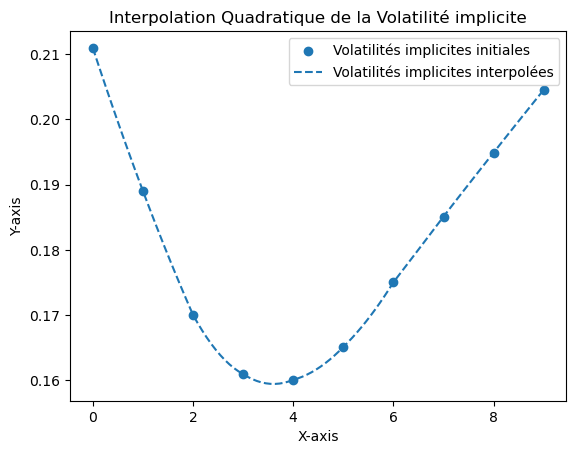

In [74]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Volatilités implicites initiales')
plt.plot(x_interpolated, vol_interpolated, label='Volatilités implicites interpolées', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

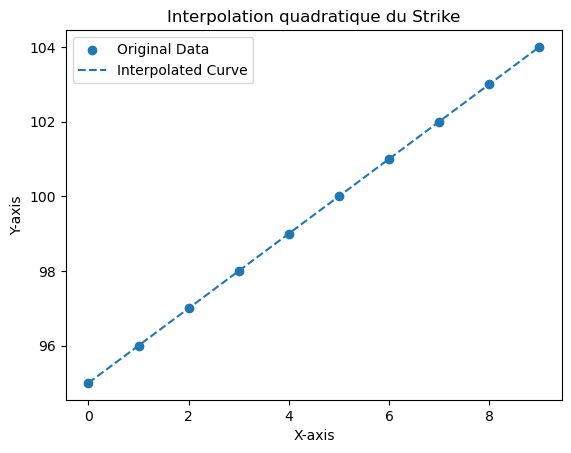

In [75]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

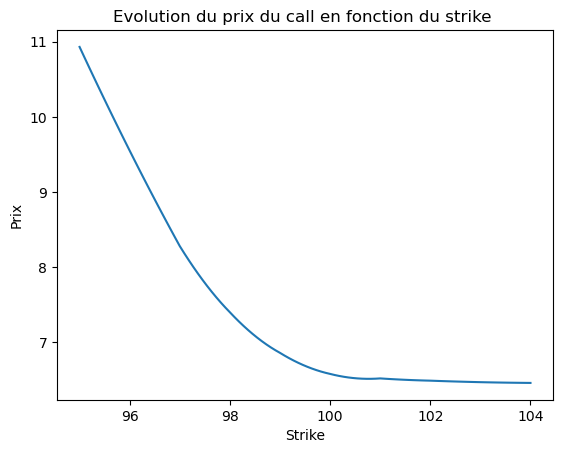

In [76]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S0,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(np.array(df["Strike"]),np.array(df["Price"]))
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [77]:
def neutral_risk_density(strikes , r , S0 , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S0 , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S0 , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S0 , K , T , r , implied_vols[i] )

        # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

density_risque_neutre = neutral_risk_density (strike_interpolated , r , S0 , T , vol_interpolated )

In [78]:
def gaussian(x, mu, sigma, ratio):
    return ratio * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def objective(params, args):
    mu, sigma, ratio = params
    return np.sum((gaussian(args[0], mu, sigma, ratio) - args[1])**2)

initial_guess = [98., 5., 2.]
result = nelder_mead_gpt(objective,np.array(initial_guess),df["Strike"],density_risque_neutre)

fitted_mu, fitted_sigma, fitted_ratio = result['x']

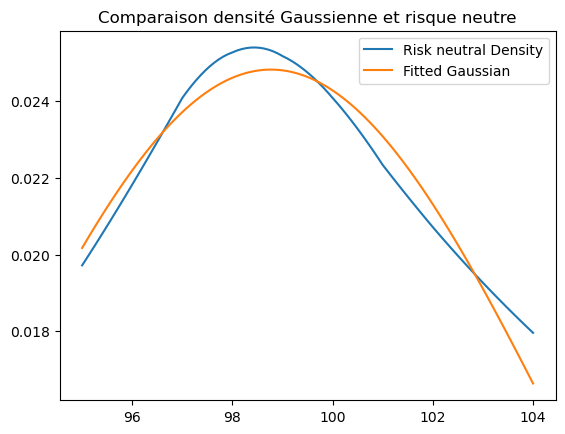

Fitted Mean: 98.76793618089212
Fitted Standard Deviation: 5.852217977950856
Fitted Amplitude (Ratio): 0.3640658899201633


In [79]:
plt.plot(df["Strike"], density_risque_neutre, label='Risk neutral Density')
plt.plot(df["Strike"], gaussian(df["Strike"], fitted_mu, fitted_sigma, fitted_ratio), label='Fitted Gaussian')
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.legend()
plt.show()

print("Fitted Mean:", fitted_mu)
print("Fitted Standard Deviation:", fitted_sigma)
print("Fitted Amplitude (Ratio):", fitted_ratio)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

## Garder ça + coder Algorithme de Metropolis-Hastings pour tirage dans la loi

In [80]:
# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, K, T, r, pas, sigma,nb_simulations):
    dt=T/pas
    paths = np.zeros((nb_simulations, pas + 1))   #on créé une matrice de taille nb_simulations x pas
    paths[:, 0] = S   #on remplit la première valeur de chaque ligne avec le spot
    
    for i in range(pas):
        paths[:, i + 1] = paths[:, i] *np.exp(dt*(r - 0.5*sigma**2) + sigma*np.sqrt(dt)* ((np.random.normal(fitted_mu,fitted_sigma,size=nb_simulations)-fitted_mu)/fitted_sigma))   #tirage dans notre loi implicite
        #pour chaque pas on calcule le prix future en utilisant le spot précédent
    option_payoffs = np.maximum(paths[:, -1] - K, 0)     #on prend ensuite le max entre notre dernier spot futur calculé - strike et 0
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  # on calcule la moyenne des payoffs qu'on actualise
    
    return option_value

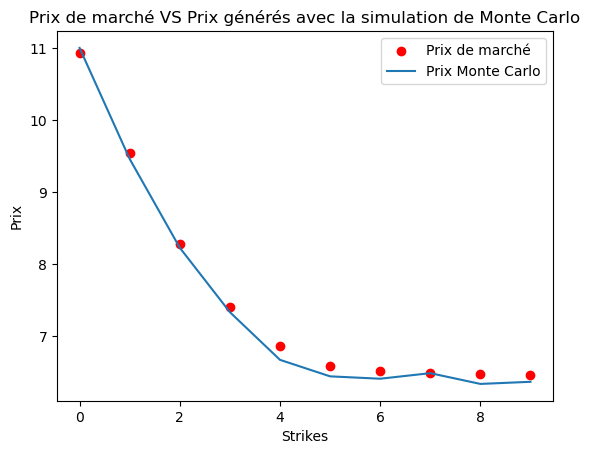

In [81]:
option_prices_mc = [valorisation_MC(S0, strike, T, r, 252, vol, 10000) for strike, vol in zip(data["strikes"], data["implied_vol"])]

fig, ax = plt.subplots()

index = np.arange(len(data["strikes"]))

rects1 = ax.scatter(index, data["prices"], label='Prix de marché',color='red')
rects2 = ax.plot(index, option_prices_mc, label='Prix Monte Carlo')

ax.set_xlabel('Strikes')
ax.set_ylabel('Prix')
ax.set_title('Prix de marché VS Prix générés avec la simulation de Monte Carlo')
ax.legend()
plt.show()


In [82]:
for strike,vol,market_price,mc_price in zip(data["strikes"],data["implied_vol"],data["prices"],option_prices_mc):
    print(f"Option : K = {strike}, Sigma = {vol:.2f}")
    print(f"Prix par simulation de Monte Carlo = {mc_price:.2f}")
    print(f"Market Price = {market_price:.2f}\nDifference = {abs(mc_price-market_price):.2f}\n")


Option : K = 95, Sigma = 0.21
Prix par simulation de Monte Carlo = 11.00
Market Price = 10.93
Difference = 0.07

Option : K = 96, Sigma = 0.19
Prix par simulation de Monte Carlo = 9.46
Market Price = 9.55
Difference = 0.09

Option : K = 97, Sigma = 0.17
Prix par simulation de Monte Carlo = 8.23
Market Price = 8.28
Difference = 0.05

Option : K = 98, Sigma = 0.16
Prix par simulation de Monte Carlo = 7.33
Market Price = 7.40
Difference = 0.07

Option : K = 99, Sigma = 0.16
Prix par simulation de Monte Carlo = 6.67
Market Price = 6.86
Difference = 0.19

Option : K = 100, Sigma = 0.17
Prix par simulation de Monte Carlo = 6.44
Market Price = 6.58
Difference = 0.14

Option : K = 101, Sigma = 0.18
Prix par simulation de Monte Carlo = 6.41
Market Price = 6.52
Difference = 0.11

Option : K = 102, Sigma = 0.19
Prix par simulation de Monte Carlo = 6.48
Market Price = 6.49
Difference = 0.01

Option : K = 103, Sigma = 0.19
Prix par simulation de Monte Carlo = 6.33
Market Price = 6.47
Difference = 0

## II – Interpolation et volatilité locale

En plus du tableau donné précédemment, on va utiliser pour cette partie les prix d’options suivants <br>
On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [83]:
def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])
 
    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S0,i,T,r,j))
   
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [84]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}
data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}
data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_12_months = pd.DataFrame(data_12_months)
df_9_months = pd.DataFrame(data_9_months)
df_6_months = pd.DataFrame(data_6_months)
df_3_months = pd.DataFrame(data_3_months)

# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 3/12), axis=1)


df_12_months_interp = interpolation(df_12_months,1)
df_9_months_interp = interpolation(df_9_months,0.75)
df_6_months_interp = interpolation(df_6_months,0.5)
df_3_months_interp = interpolation(df_3_months,0.25)

df_12_months['maturity'] =  [1]*10
df_9_months['maturity'] = [0.75]*10
df_6_months['maturity'] = [0.5]*10
df_3_months['maturity'] = [0.25]*10

df_12_months_interp['maturity'] =  [1]*100
df_9_months_interp['maturity'] = [0.75]*100
df_6_months_interp['maturity'] = [0.5]*100
df_3_months_interp['maturity'] = [0.25]*100


df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])
df_concatenated_interp = pd.concat([df_12_months_interp,df_9_months_interp, df_6_months_interp, df_3_months_interp])

df_concatenated.reset_index(drop=True,inplace=True)
df_concatenated_interp.reset_index(drop=True,inplace=True)

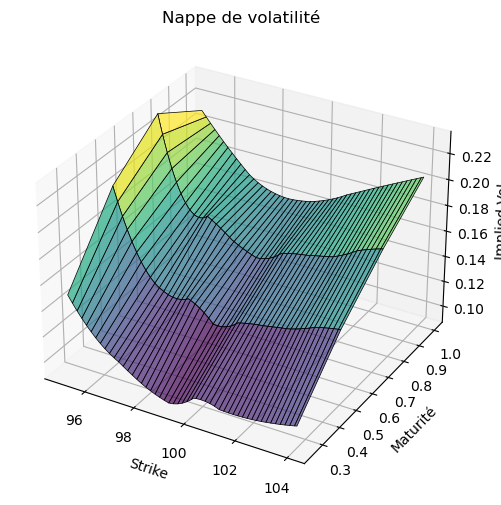

In [85]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated_interp['strikes'].values.reshape(4, -1),
                df_concatenated_interp['maturity'].values.reshape(4, -1),
                df_concatenated_interp['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_title("Nappe de volatilité")
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue). 

In [86]:
def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

On test l'interpolation quadratique avec une valeur que l'on connait pour estimer son erreur.<br>
Ici avec un Call K=99 T=1

In [87]:
volatility_interpolated = quadratic_interpolation([99], data["strikes"], data["implied_vol"])

print('K = 99')
print(f"The interpolated volatility = {volatility_interpolated[0]:.4f}")
print(f"Implied vol = {float(data[data['strikes']==99]['implied_vol'].values):.4f}")

K = 99
The interpolated volatility = 0.1601
Implied vol = 0.1601


In [88]:
y_interpolated = quadratic_interpolation([8/12], [0.25, 0.5, 0.75, 1], list(df_concatenated['implied_vol']))
 
print('K = 99.50 and T = 8/12')
print(f"Implied vol interpolated : {y_interpolated[0]:.4f}")

K = 99.50 and T = 8/12
Implied vol interpolated : 0.1760


We will use interp2d as a benchmark to test our functions

In [89]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

strike_prices = list(df_concatenated_interp[df_concatenated_interp['maturity']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months_interp['implied_vol'].values),
    list(df_9_months_interp['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")

Implied Volatility for maturity 8/12 and strike 99.5: 0.1371


We remark that the error is too big, and the quadratic interpolation function is not adapted to fit both interpolated strikes and maturity, so we will use the bilinear interpolation which is more adapted to interpolate 2 parameters

In [90]:
def bilinear_interpolation(x, y, points):
# Fvoir sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

In [91]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months_interp[df_12_months_interp['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months_interp[df_12_months_interp['strikes'] == 100]['implied_vol'].values))])

In [92]:
true_z_val = float(df_12_months_interp[df_12_months_interp['strikes']==99]['implied_vol'].values)
print(f'Implied vol from the dataframe : {true_z_val:.4f}')
print(f'Bilinear interpolated implied vol : {z_val:.4f}')
print(f'The error between bilinear interpolation and true value is : {abs(true_z_val - z_val):.4f}')

Implied vol from the dataframe : 0.1601
Bilinear interpolated implied vol : 0.1630
The error between bilinear interpolation and true value is : 0.0030


In [93]:
t1 = float(df_concatenated_interp[(df_concatenated_interp['strikes'] == 99) & (df_concatenated_interp['maturity'] == 1)]['prices'].values)
print(f'Market Price: {t1:.4f}')
t2 = black_scholes_call_price(100,99,1,0,z_val)
print(f'BS Call price with bilinear interpolated implied vol : {t2:.4f}')
print(f'The error is {abs(t1-t2):.4f} or {abs((t1-t2)/t1):.4f}%')

Market Price: 6.8600
BS Call price with bilinear interpolated implied vol : 6.9769
The error is 0.1169 or 0.0170%


We consider the error is acceptable so we will go with this method

In [94]:
x_val = 99.5
y_val = 8/12
z_995_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months_interp[df_6_months_interp['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months_interp[df_6_months_interp['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )

In [95]:
print(f'Implied vol from interp2d : {implied_volatility_8_12[0]:.4f}')
print(f'Bilinear interpolated implied vol : {z_995_val:.4f}')
print(f'The error between bilinear interpolation and true value is : {abs(implied_volatility_8_12[0] - z_995_val):.4f}')


prix_quad = black_scholes_call_price(100,99.5,8/12,0,y_interpolated[0])
print(f"Prix trouvé avec l'interpolation quadratique : {prix_quad:.4f}")
prix_bi = black_scholes_call_price(100,99.5,8/12,0,z_995_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique avec interp2d: {prix_interp2d:.4f}")

Implied vol from interp2d : 0.1371
Bilinear interpolated implied vol : 0.1446
The error between bilinear interpolation and true value is : 0.0075
Prix trouvé avec l'interpolation quadratique : 5.9683
Prix trouvé avec l'interpolation bilinéeaire : 4.9494
Prix théorique avec interp2d: 4.7066


4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes 

écrire l’algorithme de valorisation d’une option avec le modèle SVI, par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres 

In [96]:
param = [0.1] * 5

def svi_model(x, param):
    a,b,rho,m,sigma = param
    variance = abs(a) + abs(b) * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)

def forward_price_calculation(S0, r, T):
    return S0 * np.exp(r*T)

def log_moneyness_calculation(strike, forward_price):
    return np.log(strike/forward_price)

In [97]:
def valorisation_EDP(S0,K,r,T,sigma,N,I,Smin,Smax):
    step=(Smax-Smin)/I
    dt=T/N
    S=np.arange(Smin,Smax+step,step)
    S_squared = np.array([x**2 for x in S])  
    grille = np.arange(0,T+dt,dt)
    alpha=pow(sigma,2)/(2*pow(step,2))*S_squared
    beta=(r*S)/(2*step)
    option_prices = np.zeros((I,1))
    A = np.zeros((I,I))

    for i in range(I):
        option_prices[i] = max(S[i]-K,0)
    for i in range(1,len(A)+1):
        A[i-1][i-1]=2*alpha[i]+r
        if i>1:
            A[i-1][i-2]=-alpha[i]+beta[i]

        if i<I:
            A[i-1][i]=-alpha[i]-beta[i]

    
    y=np.zeros((I,1))
    alpha1=pow(sigma,2)/(2*pow(step,2))*S_squared[1]
    beta1=(r*S[1])/(2*step)
    y[0]=0
    alphaI=pow(sigma,2)/(2*pow(step,2))*S_squared[I]
    betaI=(r*S[I])/(2*step)

    for n in range(0, N):
        y[I-1]=(-alphaI-betaI)*(Smax-K*np.exp(-r*grille[n]))
        option_prices= option_prices - dt * (A @ option_prices + y)
        
    return pd.DataFrame(option_prices,index=S[:-1]).loc[S0]

In [265]:
for strike,market_price,maturity in zip(df_12_months["strikes"],df_12_months["prices"], df_12_months["maturity"]):
    forward_price = forward_price_calculation(S0, r, maturity)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    sigma = svi_model(log_moneyness, param)  
    option_price_EDP_SVI = valorisation_EDP(S0,strike,r,maturity,sigma,10000,200,0,200)
    print(f"Prix par EDP pour K = {strike}: {option_price_EDP_SVI[0]:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_EDP_SVI[0]-market_price):.2f}")

Prix par EDP pour K = 95: 16.00
Market Price = 10.93, Difference = 5.07
Prix par EDP pour K = 96: 15.47
Market Price = 9.55, Difference = 5.92
Prix par EDP pour K = 97: 14.96
Market Price = 8.28, Difference = 6.68
Prix par EDP pour K = 98: 14.45
Market Price = 7.40, Difference = 7.05
Prix par EDP pour K = 99: 13.96
Market Price = 6.86, Difference = 7.10
Prix par EDP pour K = 100: 13.49
Market Price = 6.58, Difference = 6.91
Prix par EDP pour K = 101: 13.03
Market Price = 6.52, Difference = 6.51
Prix par EDP pour K = 102: 12.58
Market Price = 6.49, Difference = 6.09
Prix par EDP pour K = 103: 12.14
Market Price = 6.47, Difference = 5.67
Prix par EDP pour K = 104: 11.72
Market Price = 6.46, Difference = 5.26


In [99]:
def valorisation_MC_SVI(S0, param, r, nb_simulations, pas, strike, maturity):
    dt = maturity / pas
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0] = S0   

    for i in range(pas):
        forward_price = forward_price_calculation(S0, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol = svi_model(log_moneyness, param)  
        paths[:, i + 1] = paths[:, i] * np.exp((r - 0.5 * vol**2) * dt + np.sqrt(dt * vol**2) * np.random.normal(0, 1, size=nb_simulations))

    option_payoffs = np.maximum(paths[:, -1] - strike, 0)
    option_value = np.exp(-r * maturity) * np.mean(option_payoffs)  

    return option_value

- estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 


In [100]:
for strike,market_price,maturity in zip(df_12_months["strikes"],df_12_months["prices"], df_12_months["maturity"]):
    option_price_mc_SVI = valorisation_MC_SVI(S0, param, r, 1000, 252, strike, maturity)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}: {option_price_mc_SVI:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc_SVI-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95: 15.83
Market Price = 10.93, Difference = 4.90
Prix par simulation de Monte Carlo pour K = 96: 16.99
Market Price = 9.55, Difference = 7.44
Prix par simulation de Monte Carlo pour K = 97: 15.15
Market Price = 8.28, Difference = 6.87
Prix par simulation de Monte Carlo pour K = 98: 13.77
Market Price = 7.40, Difference = 6.37
Prix par simulation de Monte Carlo pour K = 99: 14.26
Market Price = 6.86, Difference = 7.40
Prix par simulation de Monte Carlo pour K = 100: 13.32
Market Price = 6.58, Difference = 6.74
Prix par simulation de Monte Carlo pour K = 101: 13.21
Market Price = 6.52, Difference = 6.69
Prix par simulation de Monte Carlo pour K = 102: 11.59
Market Price = 6.49, Difference = 5.10
Prix par simulation de Monte Carlo pour K = 103: 11.34
Market Price = 6.47, Difference = 4.87
Prix par simulation de Monte Carlo pour K = 104: 11.27
Market Price = 6.46, Difference = 4.81


In [101]:
def cost_function_SVI(param,args):
    strikes,vols_market,maturity=args
    vols_model = [] 
    for strike in strikes : 
        forward_price = forward_price_calculation(S0, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vols_model.append(svi_model(log_moneyness, param))
    return np.sum((vols_model - vols_market) ** 2)

In [404]:
def check_results_svi(results,data):
    calibrated_params = results
    pas=252
    diff_totale=0
    opt = []
    for strike,market_price,maturity in zip(data["strikes"],data["prices"], data["maturity"]):
        option_price_mc_SVI = valorisation_MC_SVI(S0, calibrated_params, r, 5000, pas, strike, maturity)
        print(f"Prix par simulation de Monte Carlo pour K = {strike}: {option_price_mc_SVI:.2f}")
        print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc_SVI-market_price):.2f}")
        opt.append(option_price_mc_SVI)
        diff_totale+=abs(option_price_mc_SVI-market_price)
    print(diff_totale)
    fig, ax = plt.subplots()

    rects1 = ax.plot(data["strikes"], data["prices"],'-o',label='Prix de marché',color='red')
    rects2 = ax.plot(data["strikes"], opt, label='Prix modèle (SVI)')
    #rects3 = ax.plot(data["strikes"], prices,'-', label='Prix EDP (SVI)')
 
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Prices')
    ax.set_title('Graphique des prix obtenus')
    ax.legend()
    plt.show()

param init 12 months 
[5e-3,0.6,0.05,0.12,0.1]

Prix par simulation de Monte Carlo pour K = 95: 9.24
Market Price = 10.93, Difference = 1.69
Prix par simulation de Monte Carlo pour K = 96: 8.68
Market Price = 9.55, Difference = 0.87
Prix par simulation de Monte Carlo pour K = 97: 8.06
Market Price = 8.28, Difference = 0.22
Prix par simulation de Monte Carlo pour K = 98: 7.45
Market Price = 7.40, Difference = 0.05
Prix par simulation de Monte Carlo pour K = 99: 6.99
Market Price = 6.86, Difference = 0.13
Prix par simulation de Monte Carlo pour K = 100: 6.22
Market Price = 6.58, Difference = 0.36
Prix par simulation de Monte Carlo pour K = 101: 5.94
Market Price = 6.52, Difference = 0.58
Prix par simulation de Monte Carlo pour K = 102: 5.41
Market Price = 6.49, Difference = 1.08
Prix par simulation de Monte Carlo pour K = 103: 5.00
Market Price = 6.47, Difference = 1.47
Prix par simulation de Monte Carlo pour K = 104: 4.68
Market Price = 6.46, Difference = 1.78
8.243474131839342


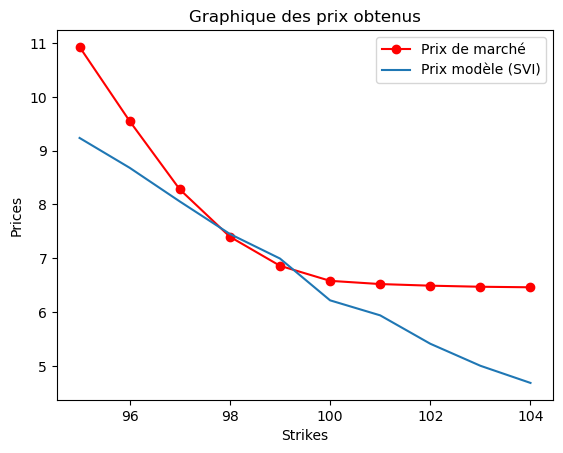

In [405]:
result_svi_12m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_12_months["strikes"],df_12_months["implied_vol"],1)['x']
check_results_svi(result_svi_12m,df_12_months) 

In [279]:
result_svi_12m

array([-0.0176 , -0.09072,  0.59392,  0.18256, -0.0848 ])

On reste notre EDP avec le modèle SVI calibré

In [267]:
prices =[]
for strike,market_price,maturity in zip(df_12_months["strikes"],df_12_months["prices"], df_12_months["maturity"]):
    forward_price = forward_price_calculation(S0, r, maturity)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    sigma = svi_model(log_moneyness, result_svi_12m)  
    option_price_EDP_SVI = valorisation_EDP(S0,strike,r,maturity,sigma,1000,100,0,200)
    prices.append(option_price_EDP_SVI[0])
    print(f"Prix avec EDP pour K = {strike}: {option_price_EDP_SVI[0]:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_EDP_SVI[0]-market_price):.2f}")

Prix avec EDP pour K = 95: 10.70
Market Price = 10.93, Difference = 0.23
Prix avec EDP pour K = 96: 9.67
Market Price = 9.55, Difference = 0.12
Prix avec EDP pour K = 97: 8.70
Market Price = 8.28, Difference = 0.42
Prix avec EDP pour K = 98: 7.80
Market Price = 7.40, Difference = 0.40
Prix avec EDP pour K = 99: 7.09
Market Price = 6.86, Difference = 0.23
Prix avec EDP pour K = 100: 6.59
Market Price = 6.58, Difference = 0.01
Prix avec EDP pour K = 101: 6.40
Market Price = 6.52, Difference = 0.12
Prix avec EDP pour K = 102: 6.44
Market Price = 6.49, Difference = 0.05
Prix avec EDP pour K = 103: 6.65
Market Price = 6.47, Difference = 0.18
Prix avec EDP pour K = 104: 6.91
Market Price = 6.46, Difference = 0.45


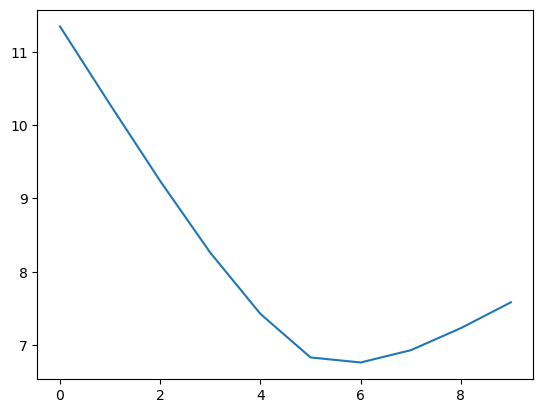

In [108]:
plt.plot(prices)

In [109]:
prices

[11.345781166999052,
 10.281058648875495,
 9.237495610959646,
 8.260174980727994,
 7.425777957744851,
 6.832036378841434,
 6.763190629508353,
 6.930298404085356,
 7.231675069416041,
 7.5842728351817765]

On teste la valorisation des options 12 mois et comparons à nos vraies valeurs de marché.
Pour le set de paramètres nous utilisons celui déterminé dans la suite du projet, qui minimise l'erreur moyenne.

Prix par simulation de Monte Carlo pour K = 95: 10.34
Market Price = 11.79, Difference = 1.45
Prix par simulation de Monte Carlo pour K = 96: 8.17
Market Price = 8.95, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 97: 6.88
Market Price = 8.07, Difference = 1.19
Prix par simulation de Monte Carlo pour K = 98: 6.45
Market Price = 7.03, Difference = 0.58
Prix par simulation de Monte Carlo pour K = 99: 5.76
Market Price = 6.18, Difference = 0.42
Prix par simulation de Monte Carlo pour K = 100: 5.05
Market Price = 6.04, Difference = 0.99
Prix par simulation de Monte Carlo pour K = 101: 5.04
Market Price = 5.76, Difference = 0.72
Prix par simulation de Monte Carlo pour K = 102: 4.65
Market Price = 5.50, Difference = 0.85
Prix par simulation de Monte Carlo pour K = 103: 4.67
Market Price = 5.50, Difference = 0.83
Prix par simulation de Monte Carlo pour K = 104: 4.53
Market Price = 5.39, Difference = 0.86
8.676328637681037


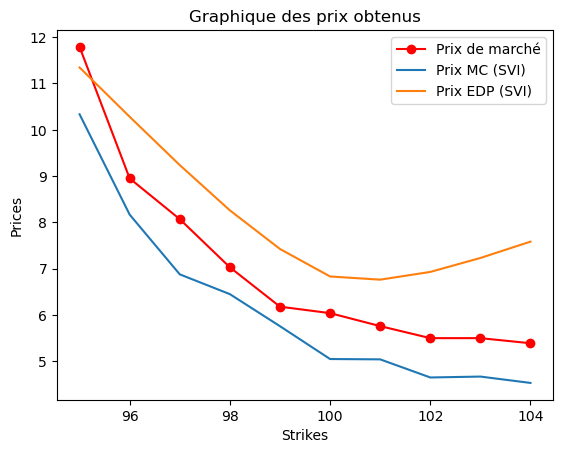

In [110]:
result_svi_9m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_9_months["strikes"],df_9_months["implied_vol"],0.75)['x']
check_results_svi(result_svi_9m,df_9_months) 

Notre algorithme de valorisation par Monte Carlo nous donne des prix proches

In [111]:
result_svi_6m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_6_months["strikes"],df_6_months["implied_vol"],0.5)['x']
result_svi_3m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_3_months["strikes"],df_3_months["implied_vol"],0.25)['x']

In [112]:
result_svi_3m

array([-0.00640117,  0.35034492, -0.83973108, -0.02884243, -0.01345534])

In [407]:
result_NM = [result_svi_12m , result_svi_9m , result_svi_6m , result_svi_3m ]

NM=pd.DataFrame(result_NM,index=["12 months","9 months","6 months","3 months"],columns=["a","b","rho","m","sigma"])
NM

a         b       rho         m     sigma
12 months -1.760000e-02 -0.090720  0.593920  0.182560 -0.084800
9 months   6.699056e-17 -5.461080 -0.950492 -0.055174 -0.013091
6 months   1.247204e-10  3.325039 -0.944192 -0.053479 -0.014539
3 months  -6.401172e-03  0.350345 -0.839731 -0.028842 -0.013455

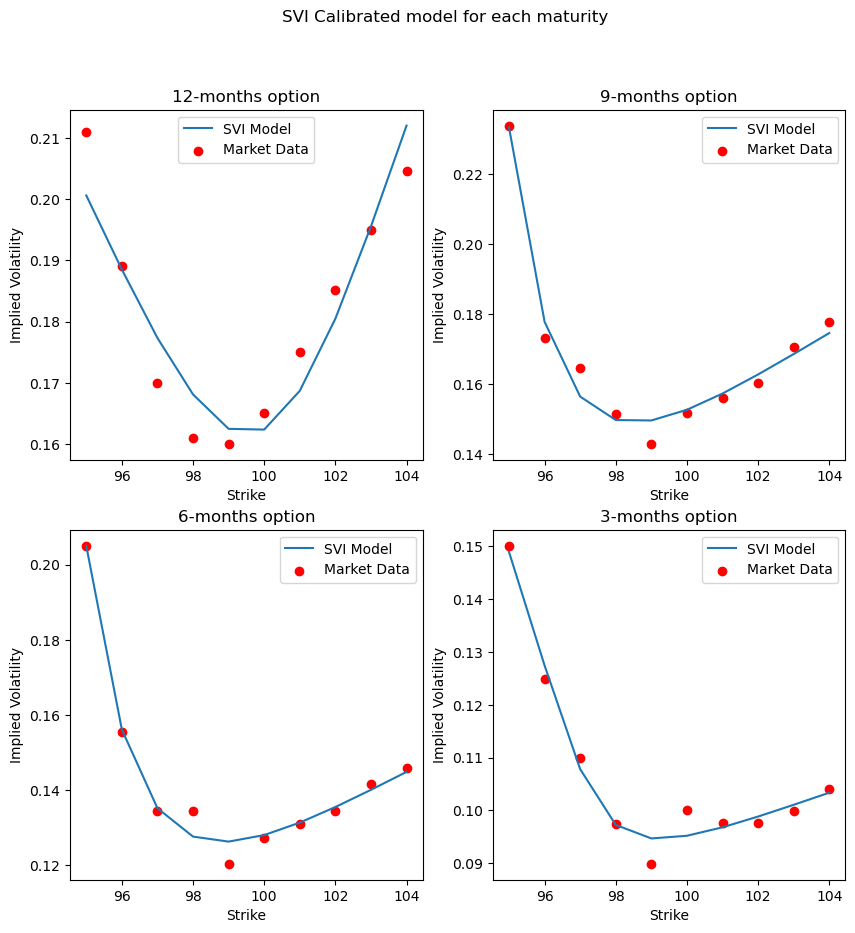

In [113]:
vols_market_12m = df_12_months["implied_vol"]
vols_market_9m = df_9_months["implied_vol"]
vols_market_6m = df_6_months["implied_vol"]
vols_market_3m = df_3_months["implied_vol"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(95, 104, 10)
vols_plot_12m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 1)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_12m.append(svi_model(log_moneyness, result_svi_12m))

ax1.plot(strikes_plot, vols_plot_12m, label='SVI Model')
ax1.scatter(strikes_plot, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

vols_plot_9m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 0.75)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_9m.append(svi_model(log_moneyness, result_svi_9m))

ax2.plot(strikes_plot, vols_plot_9m, label='SVI Model')
ax2.scatter(strikes_plot, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

vols_plot_6m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 0.5)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_6m.append(svi_model(log_moneyness, result_svi_6m))

ax3.plot(strikes_plot, vols_plot_6m, label='SVI Model')
ax3.scatter(strikes_plot, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

vols_plot_3m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 0.25)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_3m.append(svi_model(log_moneyness, result_svi_3m))

ax4.plot(strikes_plot, vols_plot_3m, label='SVI Model')
ax4.scatter(strikes_plot, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("3-months option")
ax4.legend()

plt.show()


- on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation. 

In [114]:
calibrated_params_svi = [result_svi_12m]+[result_svi_9m]+[result_svi_6m]+[result_svi_3m]

In [115]:
def svi_fixed(param, calibrated_params,x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    variance = abs(a) + abs(b) * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)
 
# Fonction d'erreur pour l'optimisation
def cost_function_SVI_fixed(param, args):
    calibrated_params, strike, vols_market,maturity = args
    forward_price = forward_price_calculation(S0, r, maturity)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vol = svi_fixed(param, calibrated_params,log_moneyness)
    return np.sum((vol - vols_market) ** 2)


In [116]:
a_values_12m = []
a_values_9m = []
a_values_6m = []
a_values_3m = []
b_values_12m = []
b_values_9m = []
b_values_6m = []
b_values_3m = []

In [117]:
for k,sigma in zip(strikes_plot, df_12_months['implied_vol']):
    res_12m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[0], k, sigma,1)['x']
    a_12m, b_12m = res_12m
    a_values_12m.append(a_12m)
    b_values_12m.append(b_12m)
for k,sigma in zip(strikes_plot, df_9_months['implied_vol']):
    res_9m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[1], k, sigma,0.75)['x']
    a_9m, b_9m = res_9m
    a_values_9m.append(a_9m)
    b_values_9m.append(b_9m)

for k,sigma in zip(strikes_plot, df_6_months['implied_vol']):
    res_6m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[2], k, sigma,0.5)['x']
    a_6m, b_6m = res_6m
    a_values_6m.append(a_6m)
    b_values_6m.append(b_6m)

for k,sigma in zip(strikes_plot, df_3_months['implied_vol']):
    res_3m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[3], k, sigma,0.25)['x']
    a_3m, b_3m = res_3m
    a_values_3m.append(a_3m)
    b_values_3m.append(b_3m)

In [118]:
a_values = a_values_12m+a_values_9m+a_values_6m+a_values_3m
b_values = b_values_12m+b_values_9m+b_values_6m+b_values_3m
strikes = df_concatenated["strikes"]
maturities = df_concatenated['maturity']
vol_market = df_concatenated['implied_vol']

In [119]:
def surface(strikes,maturities,values):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Utilisation de plot_surface pour créer une surface 3D
    ax.plot_surface(np.array(strikes).reshape(4,-1), 
                    np.array(maturities).reshape(4,-1),
                    np.array(values).reshape(4,-1), 
                    cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

    # Configurations supplémentaires
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('A values')

    # Affichage de la figure
    plt.show()

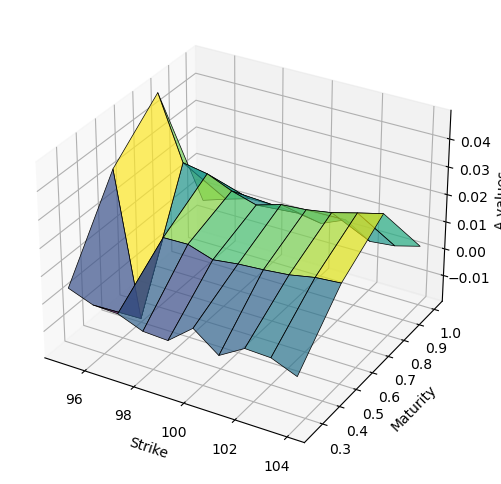

In [120]:
surface(strikes,maturities,a_values)

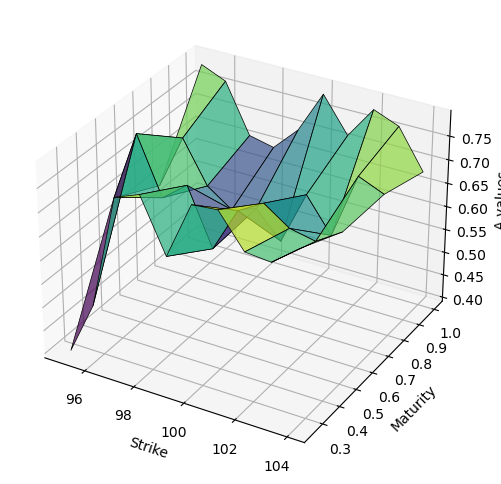

In [121]:
surface(strikes,maturities,b_values)

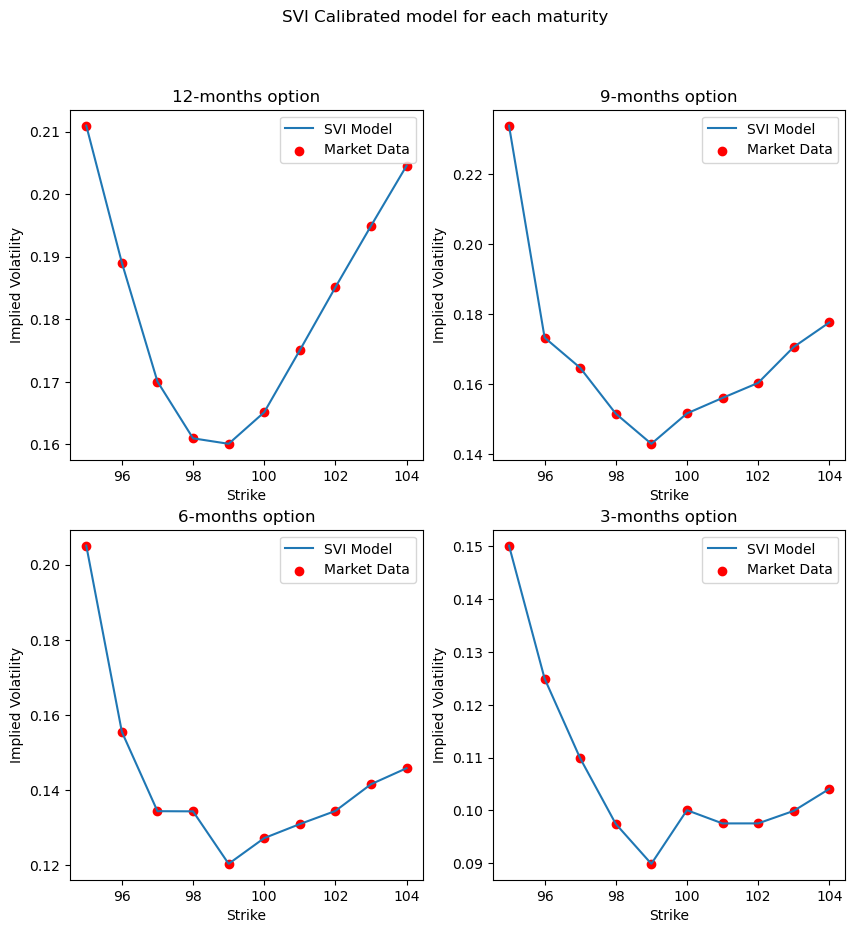

In [122]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(95, 104, 10)
vols_plot_12m =[] 
for strike,a,b in zip(strikes_plot,a_values_12m,b_values_12m): 
    forward_price = forward_price_calculation(S0, r, 1)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_12m.append(svi_model(log_moneyness, list([a,b]) + list(result_svi_12m[2:5])))

ax1.plot(strikes_plot, vols_plot_12m, label='SVI Model')
ax1.scatter(strikes_plot, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

vols_plot_9m =[] 
for strike,a,b  in zip(strikes_plot,a_values_9m,b_values_9m) : 
    forward_price = forward_price_calculation(S0, r, 0.75)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_9m.append(svi_model(log_moneyness,list([a,b]) + list(result_svi_9m[2:5])))

ax2.plot(strikes_plot, vols_plot_9m, label='SVI Model')
ax2.scatter(strikes_plot, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

vols_plot_6m =[] 
for strike,a,b in zip(strikes_plot,a_values_6m,b_values_6m)  : 
    forward_price = forward_price_calculation(S0, r, 0.5)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_6m.append(svi_model(log_moneyness, list([a,b]) + list(result_svi_6m[2:5])))

ax3.plot(strikes_plot, vols_plot_6m, label='SVI Model')
ax3.scatter(strikes_plot, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

vols_plot_3m =[] 
for strike,a,b in zip(strikes_plot,a_values_3m,b_values_3m)  : 
    forward_price = forward_price_calculation(S0, r, 0.25)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_3m.append(svi_model(log_moneyness, list([a,b]) + list(result_svi_3m[2:5])))

ax4.plot(strikes_plot, vols_plot_3m, label='SVI Model')
ax4.scatter(strikes_plot, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("3-months option")
ax4.legend()

plt.show()


In [123]:
def cost_function_reg_b(values,args):
    
    vol_market,lam,mu = args
    values_12m,values_9m,values_6m,values_3m = np.array_split(values,4)

    vol_model = []
    for strike,a,values in zip(strikes_plot,a_values_12m,values_12m)  : 
        forward_price = forward_price_calculation(S0, r, 1)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_12m[2:5])))
    for strike,a,values in zip(strikes_plot,a_values_9m,values_9m)  : 
        forward_price = forward_price_calculation(S0, r, 0.75)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_9m[2:5])))
    for strike,a,values in zip(strikes_plot,a_values_6m,values_6m)  : 
        forward_price = forward_price_calculation(S0, r, 0.5)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_6m[2:5])))
    for strike,a,values in zip(strikes_plot,a_values_3m,values_3m)  : 
        forward_price = forward_price_calculation(S0, r, 0.25)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_3m[2:5])))

    error_vol = np.sum((vol_market-vol_model)**2)

    values_surface = pd.DataFrame()
    values_surface.index = strikes_plot
    values_surface['12'] = values_12m
    values_surface['9'] = values_9m
    values_surface['6'] = values_6m
    values_surface['3'] = values_3m

    error_strike = 0
    for i in range(1,values_surface.shape[0]):
        error_strike += (lam * np.sum(((values_surface.iloc[i]) - values_surface.iloc[i-1])**2))
    error_maturity = 0
    for m in range(3,15,3):
        error_maturity+=(mu * np.sum((values_surface[f'{m}'] - values_surface[f'{m}'])**2))
    
    print(error_vol + error_strike + error_maturity)
    
    return error_vol + error_strike + error_maturity




#### Ajouter dans le nelder mead la condition stop si < 0.001 pour b et 0.125 pour a

In [125]:
result_reg_b = nelder_mead_gpt(cost_function_reg_b,np.array(b_values),vol_market,1,1)['x']

0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.1929521528956344
1.0584017856668202
1.7029765682807352
2.0112355179260057
1.1223658096802642
1.2264221820877665
3.647319628021085
3.5195623583072084
4.042161484499757
4.991405750378082
4.851397537740084
6.686267200101102
5.995834696941944
8.110080491634111
4.18379424266031
4.060247063004771
11.134927080940065
10.120915143028325
12.557523728427997
11.70907388816821
14.132954457433842
15.217493092613209
15.813781680096733
16.83010494475546
9.484517458518118
9.239037577625657
19.97815997794077
23.531938434645298
24.296167410000415
23.166865056610956
27.031398292835835
28.21080163816517
28.681890499303332
30.341003771348756
16.63219728177902
34.214668638472645
7.330239939358337
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765

4.939830875294085
4.991405750378082
5.440767367052437
5.558708396499064
5.995834696941944
6.206043117303064
6.686267200101102
6.928538420068568
7.002710880486061
7.146520111948569
7.330239939358337
8.110080491634111
9.239037577625657
9.484517458518118
10.120915143028325
11.134927080940065
11.70907388816821
12.557523728427997
14.132954457433842
15.217493092613209
15.813781680096733
16.63219728177902
4.125821133535253
16.584469509684265
4.35032883116054
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765682807352
2.0112355179260057
3.5195623583072084
3.647319628021085
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.851397537740084
4.939830875294085
4.991405750378082
5.440767367052437
5.558708396499064
5.995834696941944
6.206043117303064
6.686267200101102
6.928538420068568
7.002710880486061
7.146520111948569
7.3302399

0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765682807352
2.0112355179260057
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
3.3623004852573186
3.5195623583072084
3.647319628021085
3.676771668813458
3.946466280225673
3.9656822916135726
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.35032883116054
4.851397537740084
4.939830875294085
4.991405750378082
5.440767367052437
5.558708396499064
5.995834696941944
6.206043117303064
6.686267200101102
6.928538420068568
7.002710880486061
7.146520111948569
7.330239939358337
8.110080491634111
2.264401205125154
7.544745934614435
2.2549200084125545
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765682807352
2.0112355179260057
2.264401205125154
2.3836752829867605
2.5446369573266554
2.

3.946466280225673
3.9656822916135726
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.35032883116054
4.851397537740084
4.939830875294085
4.991405750378082
5.0439860450538845
5.440767367052437
5.558708396499064
1.513775849466819
6.502276643793983
1.407302136539648
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
3.3623004852573186
3.5195623583072084
3.647319628021085
3.676771668813458
3.946466280225673
3.9656822916135726
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.35032883116054
4.851397537740084
4.939830875294085
4.991405750378082
5.04398604

1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
3.3623004852573186
3.5195623583072084
3.647319628021085
3.676771668813458
3.946466280225673
3.9656822916135726
4.003026571426791
4.042161484499757
1.0716200055400142
4.278759038598015
1.1099494889314536
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.0716200055400142
1.0805455978133793
1.1223658096802642
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4755739070732925
1.513775849466819
1.7029765

2.777756328443808
2.7999503421934633
0.7097377321541496
3.373356495046638
0.7320761166150948
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.7097377321541496
0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
0.7320761166150948
3.539333340991068
0.7061383806656605
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.

0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4585991020594218
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.7893483444414522
1.819673111860062
1.8414574889825084
0.5432353808350033
1.9694479899953978
0.5258989029811308
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7320761166150948
0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.10994948893145

0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7320761166150948
0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.290529436253466
1.2926072126829118
1.2268744133371399
1.430318584455784
0.3844511233865414
0.2736314108481267
0.28827669288505375
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989

0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7150247201234644
0.7320761166150948
0.737605445005372
0.7732369657798132
0.9561183731516852
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
0.3413993356535984
1.0954075972613482
0.3413889431069487
0.2736314108481267
0.28827669288505375
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.52

0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7150247201234644
0.7320761166150948
0.737605445005372
0.7732369657798132
0.8565584778046992
0.9139132562327628
0.9561183731516852
0.8518488839680263
1.1172721908071872
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.

0.5441718002428086
0.5925406269268814
0.6064048883795453
0.6297224818719659
0.633655526704906
0.6386470361863588
0.7061383806656605
0.20730355934321668
0.8795423209375646
0.20954669905397108
0.18048172146563768
0.20647635472068826
0.20730355934321668
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.6064048883795453
0.6297224818719659
0.633655526704906
0.6386470361863588
0.20954669905397108
0.638481311333

0.18328060562366344
0.5788943008654052
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4438827886329089
0.46790455144409304
0.4838760472904081
0.5061414494268193
0.1702252949130876
0.4164945520436231
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.2

0.3903891705079265
0.14064598682953544
0.3932441372561986
0.1462705862471198
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.15231344759534268
0.1560180738069711
0.1596597095525586
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.32686818877518536
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.38675150498646643
0.1462705862471198
0.43632020557210544
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198


0.31183477899960244
0.31567246395698434
0.32145858393129934
0.32686818877518536
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.1300533464558612
0.3831492485225077
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.31567246395698434
0.32145858393129934
0.32686818877518536
0.3413889431069487
0.3413993356535984
0.34466400184447893

0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.2389149077927914
0.25310591906339425
0.2533448510912786
0.254965824213133
0.2599511814042537
0.2639212000017711
0.26770268669775427
0.2724481953859212
0.2736314108481267
0.2752273563458966
0.16360509761967454
0.3202865012793555
0.09862335460249182
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936

0.25159143435293635
0.24438122196769504
0.26365315696100927
0.09542435299658894
0.09078390079541107
0.09429390064090434
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.16360509761967454
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18502660003841445
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.2389149077927914
0.24438122196769504
0.09542435299658894
0.2527582411479369
0.09403607022101729
0.09078390079541107
0.09429390064090434
0.09542435299658894
0.09718644

0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.16253596984956786
0.16360509761967454
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18453095543274314
0.18502660003841445
0.18810684894155963
0.15598371114950782
0.17956768133262102
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598

0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13105471262150506
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.15598371114950782
0.1560180738069711
0.15716265414196356
0.1573516802805144
0.1596597095525586
0.06705170533395044
0.1113137092930128
0.06291700678296744
0.06705170533395044
0.06761917625509693
0.06888159153045728
0.07095298916231896
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332

0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.1113137092930128
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13105471262150506
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14121047693448277
0.10958067768430331
0.1426979245721933
0.06462188020053125
0.05643320032726629
0.06291700678296744
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.10958067768430331
0.11078092082456338
0.1113137092930128
0.1121871

0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.09078390079541107
0.09270479878489446
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09877475215595755
0.09966071326483134
0.09994383861635592
0.10193887968476391
0.10958067768430331
0.11078092082456338
0.1113137092930128
0.11218716692250023
0.12001023068053991
0.12079010779982872
0.12206256927891194
0.10037697167320037
0.10353952814154266
0.05643320032726629
0.0578235906578307
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.09078390079541107
0.09270479878489446
0.094036

0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07247881463945344
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.09078390079541107
0.09270479878489446
0.09352865352275835
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09877475215595755
0.09966071326483134
0.09994383861635592
0.04773531233208124
0.09703654149222263
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06097304139542177
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.

0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07247881463945344
0.07319891480873122
0.07508842448287581
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08355827934038643
0.08456719271850305
0.0849989404237863
0.08983768848329059
0.09078390079541107
0.09081469309718816
0.09270479878489446
0.09352865352275835
0.06684553720601377
0.10782459500676894
0.04445672690238531
0.04643317095685116
0.04687599451270933
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06684553720601377
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.0

0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06491820254840254
0.06548033389918774
0.06642259295725303
0.06684553720601377
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07247881463945344
0.07319891480873122
0.07395539100128053
0.07508842448287581
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.06271754547579164
0.06673272889809088
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06084914052450178

0.04237789837286648
0.04263084865857176
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.050235523185462275
0.05091066231385748
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06271754547579164
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06491820254840254
0.06548033389918774
0.06642259295725303
0.06673272889809088
0.06684553720601377
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06874278525958527
0.05555930950301494
0.07438872664667677
0.037339143317698324
0.03680083529124177
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.04509737132839549
0.04643317095685116

0.04643317095685116
0.04687599451270933
0.047299114023604774
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.050235523185462275
0.05091066231385748
0.05381430100666683
0.05484893626030056
0.05555930950301494
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06271754547579164
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.03520306529279035
0.03926421094170425
0.03440432275228965
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.044582056693865994
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.047299114023604774
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.049380452597

0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.044582056693865994
0.04509737132839549
0.046090457386387236
0.04643317095685116
0.04687599451270933
0.047299114023604774
0.04741717580518784
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.050235523185462275
0.05091066231385748
0.05381430100666683
0.05484893626030056
0.05555930950301494
0.05482060567011946
0.06361356078041891
0.0312063576899463
0.02906220622744904
0.031343125602723676
0.03203655993087579
0.03294476900027857
0.03440432275228965
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.044387790325458

0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.0400805267287088
0.04061890575537366
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.04394147009857661
0.04438779032545877
0.04445672690238531
0.044582056693865994
0.04509737132839549
0.046090457386387236
0.04643317095685116
0.04687599451270933
0.047299114023604774
0.04741717580518784
0.04773531233208124
0.033502286801049705
0.03366984740958953
0.02906220622744904
0.029253225276997922
0.029557794493062218
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033502286801049705
0.03440432275228965
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.037393158206372394
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.0400805267287088
0.040618905755

0.033502286801049705
0.03366984740958953
0.03440432275228965
0.03472380969634758
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.037393158206372394
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.03937457171456567
0.0400805267287088
0.04061890575537366
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.04394147009857661
0.02780740985946298
0.0486948040259646
0.026762713056345276
0.02561953946914492
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029253225276997922
0.02930284213931656
0.029557794493062218
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033395857583116535
0.033502286801049705
0.03366984740958953
0.03440432275228965
0.03472380969634758
0.03520306529279035
0.0355542783

0.0551473180006826
0.023728716209303658
0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026616860943352295
0.026762713056345276
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029253225276997922
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033395857583116535
0.033502286801049705
0.03366984740958953
0.03394778545500042
0.03440432275228965
0.03472380969634758
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.037393158206372394
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.023728716209303658
0.026400127931878965
0.023728716209303658
0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.0257

0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033395857583116535
0.033502286801049705
0.03366984740958953
0.03394778545500042
0.03440432275228965
0.03472380969634758
0.03520306529279035
0.026844165132815956
0.023287918442684907
0.04845683257518177
0.023728716209303658
0.023992628401155555
0.024217807055867256
0.02482073810234279
0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029070887292964646
0.02921233318733485
0.029253225276997922
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.030979694289566

0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029070887292964646
0.02921233318733485
0.029253225276997922
0.029286071928818647
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.022408260887880754
0.025369644463807954
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02234335910426158
0.022408260887880754
0.022710042207010228
0.023287918442684907
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.02640012793187

0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029070887292964646
0.02921233318733485
0.02250644885784761
0.029823129673769617
0.019799291994526402
0.018934728947284228
0.019535087021049374
0.019782015898790195
0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022710042207010228
0.023287918442684907
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.025369644463807954
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.0273548990

0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022710042207010228
0.023287918442684907
0.023718695363051486
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.025369644463807954
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02582677392879712
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.018845973307517007
0.02931689478490702
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.022343359

0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022567215563636868
0.022710042207010228
0.023287918442684907
0.023718695363051486
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.02535186737326858
0.017646822470166388
0.023762702489893393
0.016298107133256624
0.016424682735959876
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105

0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022567215563636868
0.022710042207010228
0.023287918442684907
0.023718695363051486
0.02041895807650254
0.022470581754124717
0.015571417314728048
0.016298107133256624
0.016424682735959876
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.02041895807650254
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720

0.015484136551990494
0.015571417314728048
0.015770962136918743
0.016183309504674136
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.016470362806751397
0.01651979880822102
0.0166747847007976
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997172977804563
0.01997265125776808
0.02041895807650254
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.014512142723281541
0.016847780709289217
0.014512142723281541
0.015484136551990494
0.015571417314728048
0.015770962136918743
0.016183309504674136
0.016298107133256624
0.0163830

0.0168119815604223
0.016812053825433944
0.016847780709289217
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.013902314793581519
0.014171551767146478
0.013902314793581519
0.014512142723281541
0.014664499426572358
0.015121390946266834
0.015161879455297383
0.015354742891489612
0.015484136551990494
0.015571417314728048
0.015695996882455956
0.015770962136918743
0.015967569398402395
0.016183309504674136
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.016470362806751397
0.01651979880822102
0.0166747847007976
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016847780709289217
0.016966288580395124
0.017200638081249962
0.0175

0.018482513061430207
0.018508424207467164
0.01858276430454501
0.018775958414643388
0.017792994999443916
0.013464594688612915
0.02025208868398553
0.013902314793581519
0.01413018458896897
0.014149292999104997
0.014171551767146478
0.014315577746981377
0.014364489333033293
0.014512142723281541
0.014633224291689945
0.014664499426572358
0.015121390946266834
0.015161879455297383
0.015354742891489612
0.015484136551990494
0.015571417314728048
0.015695996882455956
0.015770962136918743
0.015967569398402395
0.016183309504674136
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.016470362806751397
0.01651979880822102
0.0166747847007976
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016847780709289217
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.017646822470166388
0.017792994999443916
0.017848308848986905
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.01858276430454501
0.013464594688612915
0.0188

0.015121390946266834
0.015161879455297383
0.015354742891489612
0.015484136551990494
0.015571417314728048
0.015695996882455956
0.015770962136918743
0.015967569398402395
0.016183309504674136
0.016281933139617698
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.016470362806751397
0.01651979880822102
0.0166747847007976
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016847780709289217
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.013019039383963715
0.012205651959748327
0.017065895675436267
0.013019039383963715
0.013202498739675363
0.013464594688612915
0.013505083281134806
0.013766069711196222
0.013774593492860013
0.013902314793581519
0.013952344928243918
0.01413018458896897
0.014149292999104997
0.014171551767146478
0.014297275539962679
0.014315577746981377
0.014364489333033293
0.014512142723281541
0.014633224291689945
0.014664499426572358
0.014808442063046889
0.015121390946266834
0.015161879455297383
0.015354742891489612
0.015484136551990494


0.011118759839509053
0.012011101675199518
0.012205651959748327
0.012833031623187604
0.012928567290119753
0.013019039383963715
0.013193171481502411
0.013202498739675363
0.013464594688612915
0.013505083281134806
0.013684176382063032
0.013766069711196222
0.013774593492860013
0.013902314793581519
0.013952344928243918
0.014045611187736546
0.01413018458896897
0.014149292999104997
0.014171551767146478
0.014297275539962679
0.014315577746981377
0.014364489333033293
0.014512142723281541
0.014633224291689945
0.014664499426572358
0.014808442063046889
0.015121390946266834
0.015161879455297383
0.015354742891489612
0.015484136551990494
0.015571417314728048
0.015695996882455956
0.015770962136918743
0.015967569398402395
0.016183309504674136
0.016281933139617698
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.016470362806751397
0.01288133889650736
0.013414965486962954
0.011118759839509053
0.012011101675199518
0.012205651959748327
0.012833031623187604
0.01288133889650736
0.012928567290119

0.014149292999104997
0.014171551767146478
0.014231908169505368
0.014297275539962679
0.014315577746981377
0.014364489333033293
0.014410422187707937
0.014512142723281541
0.014633224291689945
0.014664499426572358
0.014808442063046889
0.015121390946266834
0.015161879455297383
0.015354742891489612
0.015484136551990494
0.015571417314728048
0.015695996882455956
0.014026052469077833
0.011404025445683714
0.011118759839509053
0.011782094574057595
0.011872212354615221
0.012011101675199518
0.012205651959748327
0.012419956892532696
0.012520508658202104
0.012833031623187604
0.01288133889650736
0.012928567290119753
0.013019039383963715
0.013193171481502411
0.013202498739675363
0.013414965486962954
0.013464594688612915
0.013505083281134806
0.013684176382063032
0.013766069711196222
0.013774593492860013
0.013902314793581519
0.013952344928243918
0.014026052469077833
0.014045611187736546
0.01413018458896897
0.014149292999104997
0.014171551767146478
0.014231908169505368
0.014297275539962679
0.0143155777469

0.013193171481502411
0.013202498739675363
0.013414965486962954
0.013464594688612915
0.013505083281134806
0.013684176382063032
0.013766069711196222
0.013774593492860013
0.013810147961674964
0.013902314793581519
0.013952344928243918
0.014026052469077833
0.014045611187736546
0.01413018458896897
0.014149292999104997
0.014171551767146478
0.014231908169505368
0.014297275539962679
0.014315577746981377
0.014364489333033293
0.014410422187707937
0.014512142723281541
0.014076319561207383
0.013547943362137283
0.010360872553435993
0.011118759839509053
0.011404025445683714
0.01158316434181076
0.011776074589574354
0.011782094574057595
0.011872212354615221
0.012011101675199518
0.012205651959748327
0.012324977810075764
0.012419956892532696
0.012520508658202104
0.01276035112216532
0.012800068743494611
0.012833031623187604
0.01288133889650736
0.012928567290119753
0.013019039383963715
0.013193171481502411
0.013202498739675363
0.013414965486962954
0.013464594688612915
0.013505083281134806
0.013684176382063

0.013684176382063032
0.013766069711196222
0.013774593492860013
0.013810147961674964
0.013902314793581519
0.013952344928243918
0.014026052469077833
0.014045611187736546
0.014076319561207383
0.012740762260214013
0.014279726159092631
0.011323000416223594
0.010360872553435993
0.011118759839509053
0.011132313077862614
0.011394775473313917
0.011404025445683714
0.01141034457839992
0.01158316434181076
0.01169497204744944
0.011776074589574354
0.011782094574057595
0.011872212354615221
0.012011101675199518
0.012137243868108081
0.012205651959748327
0.012324977810075764
0.012419956892532696
0.012520508658202104
0.012740762260214013
0.01276035112216532
0.012800068743494611
0.012833031623187604
0.01288133889650736
0.012928567290119753
0.013019039383963715
0.013193171481502411
0.013202498739675363
0.013383361469618714
0.013414965486962954
0.013464594688612915
0.013505083281134806
0.013547943362137283
0.013660665807335118
0.013684176382063032
0.013766069711196222
0.013774593492860013
0.0138101479616749

0.012693967167153248
0.012740762260214013
0.01276035112216532
0.012800068743494611
0.012833031623187604
0.01288133889650736
0.012928567290119753
0.013019039383963715
0.013193171481502411
0.013202498739675363
0.013383361469618714
0.013414965486962954
0.013464594688612915
0.013505083281134806
0.013547943362137283
0.013234080177729955
0.013441337033119666
0.010252242698204284
0.010360872553435993
0.011118759839509053
0.011132313077862614
0.011158943185464976
0.011265448590205934
0.011323000416223594
0.011385894275207475
0.011394775473313917
0.011404025445683714
0.01141034457839992
0.01158316434181076
0.01169497204744944
0.01169902907867973
0.011776074589574354
0.011782094574057595
0.011872212354615221
0.01192622025061722
0.012011101675199518
0.012137243868108081
0.012154316262310812
0.012205651959748327
0.012324977810075764
0.012419956892532696
0.012520508658202104
0.012693967167153248
0.012740762260214013
0.01276035112216532
0.012800068743494611
0.012833031623187604
0.01288133889650736
0

0.011132313077862614
0.011158943185464976
0.011161282192455504
0.011265448590205934
0.011323000416223594
0.01136446827342928
0.011385894275207475
0.011394775473313917
0.011404025445683714
0.01141034457839992
0.01158316434181076
0.011645154322436855
0.01169497204744944
0.01169902907867973
0.011776074589574354
0.011782094574057595
0.011796021926012406
0.011872212354615221
0.01192622025061722
0.012011101675199518
0.012137243868108081
0.012154316262310812
0.012205651959748327
0.012324977810075764
0.012419956892532696
0.012520508658202104
0.012693967167153248
0.012740762260214013
0.01276035112216532
0.012800068743494611
0.012833031623187604
0.01288133889650736
0.012928567290119753
0.013019039383963715
0.013133180258930495
0.013079532428187253
0.013062578929727606
0.009990270877685661
0.010252242698204284
0.010360872553435993
0.010738574721127487
0.011118759839509053
0.011132313077862614
0.011158943185464976
0.011161282192455504
0.011265448590205934
0.011323000416223594
0.01136446827342928
0

0.011796021926012406
0.011872212354615221
0.01192622025061722
0.012011101675199518
0.012137243868108081
0.012154316262310812
0.012205651959748327
0.012324977810075764
0.012419956892532696
0.012520508658202104
0.012693967167153248
0.012740762260214013
0.01073563238965923
0.011794913626600729
0.009990270877685661
0.010110529713404736
0.010252242698204284
0.010360872553435993
0.010391493455683755
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.01073563238965923
0.010738574721127487
0.010752279442864788
0.011118759839509053
0.011132313077862614
0.011158943185464976
0.011161282192455504
0.011265448590205934
0.011323000416223594
0.01136446827342928
0.011385894275207475
0.011388668117614957
0.011394775473313917
0.011404025445683714
0.01141034457839992
0.01158316434181076
0.011645154322436855
0.01169497204744944
0.01169902907867973
0.011776074589574354
0.011782094574057595
0.011796021926012406
0.011872212354615221
0.01192622025061722
0.012011101675199518
0.012137243868108081
0.

0.010391493455683755
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.010641141920171506
0.01073563238965923
0.010738574721127487
0.010752279442864788
0.011118759839509053
0.011132313077862614
0.011158943185464976
0.011161282192455504
0.011265448590205934
0.011323000416223594
0.01136446827342928
0.011385894275207475
0.011388668117614957
0.011394775473313917
0.011404025445683714
0.01141034457839992
0.01158316434181076
0.011645154322436855
0.01169497204744944
0.01169902907867973
0.011776074589574354
0.011782094574057595
0.011794913626600729
0.011796021926012406
0.011850096722351317
0.011872212354615221
0.01192622025061722
0.012007451598871177
0.012011101675199518
0.011100830242189118
0.011294610199790648
0.009990270877685661
0.010100844404184895
0.010110529713404736
0.010133571261432796
0.010156890373456937
0.010252242698204284
0.010360872553435993
0.010391493455683755
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.010641141920171506
0.01073563238965923
0.

0.011394775473313917
0.011404025445683714
0.01141034457839992
0.011448286571720069
0.01158316434181076
0.011645154322436855
0.01169497204744944
0.01169902907867973
0.011776074589574354
0.01062964250056638
0.009322280318288785
0.01192550694123774
0.00982490097438235
0.009892465737536051
0.00990586034287378
0.009931137569360215
0.009990270877685661
0.010100844404184895
0.010110529713404736
0.010133571261432796
0.010156890373456937
0.010252242698204284
0.010360872553435993
0.010391493455683755
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.01062964250056638
0.010641141920171506
0.01073563238965923
0.010738574721127487
0.010752279442864788
0.010802529066105227
0.011100830242189118
0.011118759839509053
0.011132313077862614
0.011158943185464976
0.011161282192455504
0.011265448590205934
0.011294610199790648
0.011323000416223594
0.01136446827342928
0.011385894275207475
0.011388668117614957
0.011394775473313917
0.011404025445683714
0.01141034457839992
0.011448286571720069
0.011

0.009892465737536051
0.00990586034287378
0.009931137569360215
0.009990270877685661
0.010068148650138721
0.010100844404184895
0.010110529713404736
0.010133571261432796
0.010138982399255836
0.010156890373456937
0.010252242698204284
0.010297337189013852
0.010360872553435993
0.010391493455683755
0.010599487472827077
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.01062964250056638
0.010641141920171506
0.01073563238965923
0.010738574721127487
0.010752279442864788
0.010802529066105227
0.010994884674317784
0.011100830242189118
0.011118759839509053
0.011132313077862614
0.011158943185464976
0.011161282192455504
0.011254677603074923
0.011265448590205934
0.011294610199790648
0.011323000416223594
0.01136446827342928
0.011385894275207475
0.00959483589922556
0.011515139288519194
0.009617366815802775
0.009322280318288785
0.009337101719254061
0.00959483589922556
0.009806135615690397
0.00982490097438235
0.009892465737536051
0.00990586034287378
0.009931137569360215
0.009990270877685661
0

0.01062964250056638
0.010641141920171506
0.01073563238965923
0.010738574721127487
0.010752279442864788
0.010802529066105227
0.010994884674317784
0.011100830242189118
0.011118759839509053
0.010268269819116991
0.00997599386958589
0.008715887415227774
0.008953850908740233
0.008959096255614227
0.009322280318288785
0.009337101719254061
0.009458192715015646
0.00952933795452228
0.00959483589922556
0.009611909576649615
0.009617366815802775
0.009806135615690397
0.00982490097438235
0.009892465737536051
0.00990586034287378
0.009931137569360215
0.009990270877685661
0.010068148650138721
0.010100844404184895
0.010110529713404736
0.010133571261432796
0.010138982399255836
0.010156890373456937
0.010252242698204284
0.010268269819116991
0.010297337189013852
0.010360872553435993
0.010391493455683755
0.010459151292537947
0.010599487472827077
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.01062964250056638
0.010641141920171506
0.01073563238965923
0.010738574721127487
0.010752279442864788
0.

0.00997599386958589
0.009990270877685661
0.010068148650138721
0.010100844404184895
0.010110529713404736
0.010133571261432796
0.010138982399255836
0.010156890373456937
0.010252242698204284
0.010268269819116991
0.010297337189013852
0.010360872553435993
0.010391493455683755
0.010459151292537947
0.010599487472827077
0.01061061324103557
0.010620301044991134
0.010628163140495573
0.01062964250056638
0.009208498270403563
0.0108190985695995
0.009199476181555937
0.008559835496737654
0.008715887415227774
0.008953850908740233
0.008959096255614227
0.009114521760709938
0.009208498270403563
0.009211634894978504
0.009281566982421717
0.009298033916549712
0.009305750163298786
0.009322280318288785
0.009337101719254061
0.009458192715015646
0.00952933795452228
0.00959483589922556
0.009611909576649615
0.009617366815802775
0.009806135615690397
0.00982490097438235
0.009892465737536051
0.00990586034287378
0.009931137569360215
0.00997599386958589
0.009990270877685661
0.010068148650138721
0.010100844404184895
0.

0.010252242698204284
0.010268269819116991
0.008907334001563426
0.01084124164855526
0.008961335213275622
0.00840627859812181
0.008559835496737654
0.008618916723056484
0.008691995067238315
0.008715887415227774
0.008907334001563426
0.008953850908740233
0.008959096255614227
0.00903923889821195
0.009084748548925606
0.009114521760709938
0.009119863929889106
0.009199476181555937
0.009208498270403563
0.009211634894978504
0.009281566982421717
0.009298033916549712
0.009305750163298786
0.009322280318288785
0.009337101719254061
0.009458192715015646
0.00952933795452228
0.00959483589922556
0.009611909576649615
0.009617366815802775
0.009806135615690397
0.00982490097438235
0.009892465737536051
0.00990586034287378
0.009931137569360215
0.00997599386958589
0.009990270877685661
0.010068148650138721
0.010100844404184895
0.010110529713404736
0.010133571261432796
0.010138982399255836
0.010156890373456937
0.010208513212275441
0.010252242698204284
0.008961335213275622
0.010448552779222455
0.009003034451921679


0.00903923889821195
0.009084748548925606
0.009114521760709938
0.009119863929889106
0.009199476181555937
0.009208498270403563
0.009211634894978504
0.009281566982421717
0.009298033916549712
0.009305750163298786
0.009322280318288785
0.009337101719254061
0.009458192715015646
0.00952933795452228
0.00959483589922556
0.009611909576649615
0.009617366815802775
0.009806135615690397
0.00982490097438235
0.009892465737536051
0.00990586034287378
0.009919798032404593
0.009931137569360215
0.00997599386958589
0.009990270877685661
0.009895138929267676
0.009599282777257702
0.00840627859812181
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008630921751554175
0.008691995067238315
0.008715887415227774
0.008889141721174124
0.008907334001563426
0.008930527393826956
0.008953850908740233
0.008959096255614227
0.008961335213275622
0.009000796694235683
0.009003034451921679
0.00903923889821195
0.009084748548925606
0.009114521760709938
0.009119863929889106
0.009199476181555937
0.009208498270403563


0.009599282777257702
0.009611909576649615
0.009617366815802775
0.008195144321248807
0.00820072801511002
0.008195144321248807
0.008394912246237202
0.00840627859812181
0.008456399362590622
0.00849754600127425
0.00851581066484882
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008630921751554175
0.008691995067238315
0.008715887415227774
0.008807127661050462
0.008811488149485893
0.008839770000373498
0.008889141721174124
0.008907334001563426
0.008930527393826956
0.008953850908740233
0.008959096255614227
0.008961335213275622
0.009000796694235683
0.009003034451921679
0.00903923889821195
0.009084748548925606
0.009114521760709938
0.009119863929889106
0.009199476181555937
0.009208498270403563
0.009211634894978504
0.009281566982421717
0.009298033916549712
0.009305750163298786
0.009322280318288785
0.009337101719254061
0.009458192715015646
0.00952933795452228
0.00959483589922556
0.009599282777257702
0.009611909576649615
0.00820072801511002
0.008068941206318715
0.008935099300786932


0.008953850908740233
0.008959096255614227
0.008961335213275622
0.009000796694235683
0.009003034451921679
0.00903923889821195
0.009084748548925606
0.009114521760709938
0.009119863929889106
0.009192196559049712
0.009199476181555937
0.009208498270403563
0.009211634894978504
0.009281566982421717
0.009298033916549712
0.009305750163298786
0.009047598155726963
0.008382171578474464
0.008068941206318715
0.008160162457351756
0.008195144321248807
0.00820072801511002
0.00826369057889206
0.008394912246237202
0.00840627859812181
0.008453934465236247
0.008456399362590622
0.00849754600127425
0.00851581066484882
0.008532784077015998
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008630921751554175
0.008691995067238315
0.008715887415227774
0.008807127661050462
0.008811488149485893
0.008839770000373498
0.008889141721174124
0.008907334001563426
0.008930527393826956
0.008953850908740233
0.008959096255614227
0.008961335213275622
0.009000796694235683
0.009003034451921679
0.00903923889821195

0.008630921751554175
0.008691995067238315
0.008715887415227774
0.008807127661050462
0.008811488149485893
0.008839770000373498
0.008889141721174124
0.008907334001563426
0.008930527393826956
0.008953850908740233
0.008959096255614227
0.008961335213275622
0.008995748656771045
0.009000796694235683
0.009003034451921679
0.00903923889821195
0.009047598155726963
0.007977972911637682
0.008974182901839265
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.007977972911637682
0.008068941206318715
0.008091626078174707
0.008135148405568145
0.008160162457351756
0.008195144321248807
0.00820072801511002
0.00826369057889206
0.008342064947243955
0.008382171578474464
0.008394912246237202
0.00840627859812181
0.008453934465236247
0.008456399362590622
0.00849754600127425
0.00851581066484882
0.008532784077015998
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008630921751554175
0.008691995067238315
0.008715887415227774
0.008807127661050462
0.008811488149485893
0

0.007777570695982098
0.00778170788348277
0.007835127012135642
0.00785013946245423
0.007977972911637682
0.008011466802609456
0.008068941206318715
0.008091626078174707
0.008131069813711912
0.008135148405568145
0.008160162457351756
0.008195144321248807
0.00820072801511002
0.00826369057889206
0.008321996280573913
0.008342064947243955
0.008382171578474464
0.008394912246237202
0.00840627859812181
0.008453934465236247
0.008456399362590622
0.00849754600127425
0.00851581066484882
0.008532784077015998
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008630921751554175
0.008686357737775919
0.008691995067238315
0.008715887415227774
0.008807127661050462
0.008811488149485893
0.008830468116631261
0.008839770000373498
0.008889141721174124
0.008907334001563426
0.0074516599651271555
0.007988637558393956
0.007416702333514212
0.0074516599651271555
0.007663841654680645
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.00785013946245423
0.007977972911637682
0

0.008532784077015998
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008629651038920598
0.008630921751554175
0.008686357737775919
0.007706102701487958
0.008299391104645268
0.007153557419369694
0.007416702333514212
0.007449663788429824
0.0074516599651271555
0.007553554558452015
0.007663841654680645
0.007676101876407953
0.007706102701487958
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.00785013946245423
0.007977972911637682
0.007988637558393956
0.008011466802609456
0.008068941206318715
0.008069614319657765
0.008091626078174707
0.008131069813711912
0.008135148405568145
0.008160162457351756
0.008195144321248807
0.00820072801511002
0.00826369057889206
0.008321996280573913
0.008342064947243955
0.008382171578474464
0.008394912246237202
0.00840627859812181
0.008453934465236247
0.008456399362590622
0.00849754600127425
0.00851581066484882
0.008532784077015998
0.008533343508178269
0.008559835496737654
0.008618916723056484
0.008629651038920598


0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.007837355708338286
0.00785013946245423
0.007958531033290523
0.007977972911637682
0.007988637558393956
0.007997610285001986
0.008011466802609456
0.008068941206318715
0.008069614319657765
0.008091626078174707
0.008131069813711912
0.008135148405568145
0.008160162457351756
0.008195144321248807
0.00820072801511002
0.00826369057889206
0.008299391104645268
0.008321996280573913
0.008342064947243955
0.008382171578474464
0.008394912246237202
0.00840627859812181
0.008453934465236247
0.00761675855134465
0.00748614530320431
0.007153557419369694
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.0074516599651271555
0.007553554558452015
0.00761675855134465
0.007622005502482189
0.007663841654680645
0.007676101876407953
0.007706102701487958
0.007726635105870463
0.007738986926247637
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.007837355708338286
0.00

0.0073879040677372705
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.0074516599651271555
0.00748614530320431
0.007553554558452015
0.007586070507422122
0.00761675855134465
0.007622005502482189
0.007663841654680645
0.007676101876407953
0.007706102701487958
0.007726635105870463
0.007738986926247637
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.007837355708338286
0.00785013946245423
0.007905250259761267
0.007955054344468207
0.007958531033290523
0.007977972911637682
0.007988637558393956
0.007997610285001986
0.008011466802609456
0.008068941206318715
0.008069614319657765
0.008091626078174707
0.008113058644584262
0.008131069813711912
0.008135148405568145
0.008160162457351756
0.007549073601464166
0.007349545637069781
0.006835113332879027
0.007153557419369694
0.00731626816121884
0.007385712177882572
0.0073879040677372705
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.007451659965127

0.00778170788348277
0.007835127012135642
0.007837355708338286
0.00785013946245423
0.007905250259761267
0.007955054344468207
0.007958531033290523
0.007977972911637682
0.007988637558393956
0.007997610285001986
0.008011466802609456
0.007255133358585847
0.00786455780993164
0.006835113332879027
0.006953277750427321
0.007071980585246872
0.0071220868536061525
0.007148112705241673
0.007153557419369694
0.007255133358585847
0.00731626816121884
0.007349545637069781
0.007385712177882572
0.0073879040677372705
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.0074516599651271555
0.00748614530320431
0.007549073601464166
0.007553554558452015
0.007586070507422122
0.00761675855134465
0.007622005502482189
0.007634762860852988
0.007663841654680645
0.007676101876407953
0.007706102701487958
0.007726635105870463
0.007738986926247637
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.007837355708338286
0.00785013946245423
0.007905250259761267

0.007449663788429824
0.0074516599651271555
0.00748614530320431
0.007549073601464166
0.007553554558452015
0.007585672262599813
0.007586070507422122
0.00761675855134465
0.007622005502482189
0.007626662368447778
0.007632084803978243
0.007634762860852988
0.007663841654680645
0.007672232662781548
0.007676101876407953
0.007706102701487958
0.007726635105870463
0.007738986926247637
0.0077444094832932
0.007777570695982098
0.00778170788348277
0.007835127012135642
0.0075183525655939595
0.007296544594687575
0.006709444019515997
0.006835113332879027
0.006953277750427321
0.007071980585246872
0.007112662888934801
0.0071220868536061525
0.007136370605123907
0.007148112705241673
0.007153557419369694
0.007153781181064938
0.007255133358585847
0.00731626816121884
0.007349545637069781
0.007385712177882572
0.0073879040677372705
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.0074516599651271555
0.00748614530320431
0.0075183525655939595
0.007549073601464166
0.007553554558

0.0075183525655939595
0.007549073601464166
0.007553554558452015
0.007585672262599813
0.007586070507422122
0.00761675855134465
0.007622005502482189
0.007626662368447778
0.007632084803978243
0.007634762860852988
0.007663841654680645
0.0076406526529699675
0.006620429893323329
0.007334125277536286
0.006626717668177507
0.006709444019515997
0.006783308517386499
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006953277750427321
0.007071980585246872
0.007112662888934801
0.0071220868536061525
0.007136370605123907
0.007139238824339645
0.007148112705241673
0.0071504955356918865
0.007153557419369694
0.007153781181064938
0.007255133358585847
0.007296544594687575
0.00731626816121884
0.007349545637069781
0.007373648018725985
0.007385712177882572
0.0073879040677372705
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.0074516599651271555
0.00748614530320431
0.0075183525655939595
0.007549073601464166
0.007553554558452015
0.007585672262599813
0.0075860

0.007153557419369694
0.007153781181064938
0.007255133358585847
0.0072670425324324415
0.007296544594687575
0.00731626816121884
0.007349545637069781
0.007373648018725985
0.007385712177882572
0.0073879040677372705
0.007408922819645733
0.007415290170900931
0.007416702333514212
0.007441617960416626
0.007449663788429824
0.0074516599651271555
0.007484620218269429
0.00748614530320431
0.0075183525655939595
0.007532740576403187
0.007539375011319617
0.007549073601464166
0.007553554558452015
0.007440252612140029
0.006365120942338123
0.006697416554417643
0.006620429893323329
0.006626717668177507
0.006709444019515997
0.006783308517386499
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006953277750427321
0.007003365906669865
0.007071980585246872
0.007108816774504317
0.007112662888934801
0.0071220868536061525
0.007136370605123907
0.007139238824339645
0.007148112705241673
0.0071504955356918865
0.007153557419369694
0.007153781181064938
0.007255133358585847
0.0072670425324324415
0.007296

0.007440252612140029
0.0074408951041311285
0.007441617960416626
0.0065623474999277715
0.007153988829893353
0.006365120942338123
0.0065623474999277715
0.006602958497708246
0.006620429893323329
0.006626717668177507
0.006709444019515997
0.006783308517386499
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006953277750427321
0.006962357024473387
0.007003365906669865
0.007061338406270955
0.007071980585246872
0.007108816774504317
0.007112662888934801
0.0071220868536061525
0.007136370605123907
0.007139238824339645
0.007148112705241673
0.0071504955356918865
0.007153557419369694
0.007153781181064938
0.007255133358585847
0.0072670425324324415
0.007296544594687575
0.00731626816121884
0.007349545637069781
0.007355231355512866
0.007356225325803391
0.007373648018725985
0.007385712177882572
0.0073879040677372705
0.007408922819645733
0.007415290170900931
0.0074163411394113435
0.007416702333514212
0.007440252612140029
0.0074408951041311285
0.007153988829893353
0.00744239308441394
0.0067

0.007139238824339645
0.007148112705241673
0.0071504955356918865
0.007153557419369694
0.007153781181064938
0.007153988829893353
0.007255133358585847
0.0072670425324324415
0.007296544594687575
0.00731626816121884
0.007349545637069781
0.007355231355512866
0.007356225325803391
0.007373648018725985
0.007261199023245459
0.0069879419094322675
0.006365120942338123
0.006469823639605146
0.0065623474999277715
0.006602958497708246
0.006620429893323329
0.006626717668177507
0.006709444019515997
0.0067281905324505994
0.00674438035386818
0.006772009791496617
0.006783308517386499
0.006806588015362889
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006941757144260607
0.006953277750427321
0.006962357024473387
0.007003365906669865
0.007061338406270955
0.007067481270978573
0.007071980585246872
0.007108816774504317
0.007112662888934801
0.0071220868536061525
0.007136370605123907
0.007139238824339645
0.007148112705241673
0.0071504955356918865
0.007153557419369694
0.007153781181064938
0.007153

0.006598024981665408
0.006302805964650463
0.006365120942338123
0.006469823639605146
0.006532711007292467
0.0065623474999277715
0.006602958497708246
0.006616551257768564
0.006620429893323329
0.006626717668177507
0.006708754718894773
0.006709444019515997
0.0067281905324505994
0.00674438035386818
0.006772009791496617
0.006783308517386499
0.006806588015362889
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006888856291652196
0.006941757144260607
0.006953277750427321
0.006962357024473387
0.0069879419094322675
0.007003365906669865
0.0070420320669132555
0.007061338406270955
0.007067481270978573
0.007071980585246872
0.007108816774504317
0.007112662888934801
0.0071220868536061525
0.007125047980081739
0.007136370605123907
0.007139238824339645
0.007148112705241673
0.0071504955356918865
0.007153557419369694
0.007153781181064938
0.007153988829893353
0.006598024981665408
0.007069385590807855
0.006302805964650463
0.006365120942338123
0.006469823639605146
0.006532711007292467
0.006562

0.00674438035386818
0.006772009791496617
0.006783308517386499
0.006806588015362889
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006888856291652196
0.006941757144260607
0.006953277750427321
0.006962357024473387
0.006973093033217026
0.0069879419094322675
0.007003365906669865
0.0070420320669132555
0.007061338406270955
0.007067481270978573
0.007069385590807855
0.007071980585246872
0.007108816774504317
0.007112662888934801
0.006359793099914045
0.006327699783845657
0.006108486212088481
0.00624737738590632
0.006302805964650463
0.006359793099914045
0.006365120942338123
0.006469823639605146
0.006494768782364052
0.00651074851649387
0.006532711007292467
0.0065623474999277715
0.006598024981665408
0.006602275514881361
0.006602958497708246
0.006616551257768564
0.006620429893323329
0.006626717668177507
0.006630254512237619
0.006708754718894773
0.006709444019515997
0.0067281905324505994
0.00674438035386818
0.006772009791496617
0.006783308517386499
0.006806588015362889
0.00683511333

0.006931014874189146
0.006941757144260607
0.006953277750427321
0.006962357024473387
0.006973093033217026
0.006781498828113457
0.007039333278716534
0.006351632694620795
0.006108486212088481
0.00624737738590632
0.006300847345170838
0.006302805964650463
0.006327699783845657
0.006359793099914045
0.006365120942338123
0.006469823639605146
0.006494768782364052
0.00651074851649387
0.006532711007292467
0.0065623474999277715
0.0065630411137920334
0.006579473545434946
0.006598024981665408
0.006602275514881361
0.006602958497708246
0.006616551257768564
0.006620429893323329
0.006626717668177507
0.006630254512237619
0.006659988922897278
0.006681872774361154
0.006708754718894773
0.006709444019515997
0.0067281905324505994
0.00674438035386818
0.006772009791496617
0.006781498828113457
0.006783308517386499
0.006787002756058536
0.006806588015362889
0.006835113332879027
0.006878687299140604
0.006878954859796626
0.006888856291652196
0.006931014874189146
0.006941757144260607
0.006953277750427321
0.00696235702

0.006300847345170838
0.006302805964650463
0.006327699783845657
0.006351632694620795
0.006359793099914045
0.006365120942338123
0.006432479436481969
0.006469823639605146
0.006494768782364052
0.00651074851649387
0.006532711007292467
0.0065623474999277715
0.0065630411137920334
0.006577717493913792
0.006579473545434946
0.006598024981665408
0.006602275514881361
0.006602958497708246
0.006616551257768564
0.006620429893323329
0.006626717668177507
0.006630254512237619
0.006659988922897278
0.006681872774361154
0.0066992632138904145
0.006708754718894773
0.006709444019515997
0.006713706910689423
0.0067281905324505994
0.00674438035386818
0.0067493280077182225
0.006772009791496617
0.006781498828113457
0.006783308517386499
0.006787002756058536
0.006806588015362889
0.006268516198582631
0.006562171033659403
0.006087203841162882
0.006108486212088481
0.006214485217940206
0.00624737738590632
0.006268516198582631
0.006300847345170838
0.006302805964650463
0.006327699783845657
0.006351632694620795
0.006359793

0.006351632694620795
0.006359793099914045
0.006365120942338123
0.006432479436481969
0.006469823639605146
0.006494768782364052
0.00651074851649387
0.006532711007292467
0.006562171033659403
0.0065623474999277715
0.0065630411137920334
0.006577717493913792
0.006579473545434946
0.006598024981665408
0.006602275514881361
0.006602958497708246
0.006616551257768564
0.006620429893323329
0.006626717668177507
0.006630254512237619
0.006659988922897278
0.006681872774361154
0.0066992632138904145
0.006708754718894773
0.006709444019515997
0.006713706910689423
0.006724878467286701
0.006276588039432824
0.00668564141576232
0.005721146880754346
0.005770610324305374
0.006087203841162882
0.006108486212088481
0.006203367846192945
0.006214485217940206
0.006243610915280707
0.00624737738590632
0.006268516198582631
0.006276588039432824
0.00628998224250755
0.006300847345170838
0.006302805964650463
0.006327699783845657
0.006351632694620795
0.006359793099914045
0.006365120942338123
0.006432479436481969
0.006469823639

0.00651074851649387
0.006516948194233091
0.006532711007292467
0.006562171033659403
0.0065623474999277715
0.0065630411137920334
0.006577717493913792
0.006579473545434946
0.006589514255242622
0.006598024981665408
0.006602275514881361
0.006602958497708246
0.006604443277308607
0.006616551257768564
0.006620429893323329
0.006626717668177507
0.006363949881372557
0.006089189074824431
0.005721146880754346
0.005770610324305374
0.006087203841162882
0.006108486212088481
0.0061086784332431195
0.006125680677427149
0.006141643297365799
0.006203367846192945
0.006214485217940206
0.006243610915280707
0.00624737738590632
0.006268516198582631
0.006276588039432824
0.00628998224250755
0.006300847345170838
0.006302805964650463
0.006327699783845657
0.006351632694620795
0.006359793099914045
0.006363949881372557
0.006365120942338123
0.006432479436481969
0.006465591124563473
0.006469823639605146
0.006494768782364052
0.00651074851649387
0.006516948194233091
0.006532711007292467
0.006562171033659403
0.006562347499

0.005721146880754346
0.005726101037324839
0.005770610324305374
0.006087203841162882
0.006089189074824431
0.006108486212088481
0.0061086784332431195
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.006203367846192945
0.006214485217940206
0.006243610915280707
0.00624737738590632
0.006268516198582631
0.0062722423457253415
0.006276588039432824
0.00628998224250755
0.006300847345170838
0.006302805964650463
0.006327699783845657
0.006332617927184655
0.006351632694620795
0.006359793099914045
0.006363949881372557
0.006365120942338123
0.006432479436481969
0.00644178283848227
0.00646122128540169
0.006465591124563473
0.006469823639605146
0.006494768782364052
0.00651074851649387
0.006516948194233091
0.006532711007292467
0.00653358927966201
0.006562171033659403
0.0065623474999277715
0.0065630411137920334
0.006259624573157509
0.006295342710282953
0.005618114204500572
0.005721146880754346
0.005726101037324839
0.005770610324305374
0.006087203841162882
0.006089189074824431
0.0061084862120

0.006214485217940206
0.006220343523919843
0.006243610915280707
0.00624737738590632
0.006259624573157509
0.006268516198582631
0.0062722423457253415
0.006276588039432824
0.00628998224250755
0.00629248821054035
0.006295342710282953
0.006300847345170838
0.006302805964650463
0.006315491372639016
0.006327699783845657
0.006332617927184655
0.006351632694620795
0.006359793099914045
0.006363949881372557
0.006365120942338123
0.0063855268538526
0.006432479436481969
0.00644178283848227
0.00646122128540169
0.006465591124563473
0.005806651016939664
0.00648758609579287
0.0059442826261114565
0.005618114204500572
0.005721146880754346
0.005726101037324839
0.005770610324305374
0.005806651016939664
0.005877482081037196
0.005907207161961131
0.005995970353003829
0.006087203841162882
0.006089189074824431
0.006108486212088481
0.0061086784332431195
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.006203367846192945
0.006214485217940206
0.006220343523919843
0.006243610915280707
0.0062473773859063

0.006332617927184655
0.006351632694620795
0.006004670014450566
0.005464832031317862
0.00557277288868193
0.005618114204500572
0.005721146880754346
0.005726101037324839
0.005770610324305374
0.005785815231463721
0.005806651016939664
0.005877482081037196
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.0059442826261114565
0.005995970353003829
0.006004670014450566
0.006087203841162882
0.006089189074824431
0.006108486212088481
0.0061086784332431195
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.0061597841723212985
0.0061860052523067645
0.006203367846192945
0.006214485217940206
0.006220343523919843
0.006243610915280707
0.00624737738590632
0.006259624573157509
0.006268516198582631
0.0062722423457253415
0.006276588039432824
0.00628998224250755
0.00629248821054035
0.006295342710282953
0.006300847345170838
0.006302805964650463
0.006315491372639016
0.006317312547142738
0.006327699783845657
0.006332617927184655
0.005464832031317862
0.00635535707073729
0.00586553987

0.0061086784332431195
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.0061597841723212985
0.0061776270935464655
0.0061860052523067645
0.006203367846192945
0.006214485217940206
0.006218194657718359
0.006220343523919843
0.006243610915280707
0.00624737738590632
0.006259624573157509
0.006268516198582631
0.0062722423457253415
0.006276588039432824
0.006278584398944312
0.006286702750331514
0.005890750442218398
0.006251116822317244
0.005464832031317862
0.005618114204500572
0.005721146880754346
0.005726101037324839
0.005770610324305374
0.005785815231463721
0.0057892556391024525
0.005806651016939664
0.005855280516934224
0.005865539876367615
0.005877482081037196
0.005890750442218398
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.0059442826261114565
0.005995970353003829
0.006004670014450566
0.006005503764927427
0.006087203841162882
0.006089189074824431
0.006108486212088481
0.0061086784332431195
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.0061

0.005890750442218398
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.0059442826261114565
0.005995970353003829
0.006004670014450566
0.006005503764927427
0.006017010426836648
0.006087203841162882
0.006089189074824431
0.00610564944242086
0.006108486212088481
0.0061086784332431195
0.006124235849715158
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.006151187282125743
0.0061597841723212985
0.0061776270935464655
0.0061860052523067645
0.006203367846192945
0.006214485217940206
0.00621463175319611
0.006218194657718359
0.0060861151519914745
0.00626400245095808
0.0057652767110559725
0.005351009499957867
0.005464832031317862
0.005618114204500572
0.005721146880754346
0.005726101037324839
0.005770610324305374
0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005806316094620633
0.005806651016939664
0.005855280516934224
0.005865539876367615
0.005877482081037196
0.005890750442218398
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.00594

0.0060861151519914745
0.006087203841162882
0.006087648771571688
0.006089189074824431
0.00610564944242086
0.006108486212088481
0.0061086784332431195
0.006114413564074508
0.006124235849715158
0.006125680677427149
0.006141643297365799
0.006145338298601996
0.00572495443607327
0.0059377144701651605
0.005351009499957867
0.005464832031317862
0.005528850684293684
0.005618114204500572
0.005721146880754346
0.00572495443607327
0.005726101037324839
0.005738282334064165
0.00573835914997683
0.0057652767110559725
0.005770610324305374
0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005806316094620633
0.005806651016939664
0.005855280516934224
0.005865539876367615
0.005877482081037196
0.005890750442218398
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.005912117490229197
0.0059442826261114565
0.005995970353003829
0.006004670014450566
0.006005503764927427
0.006017010426836648
0.0060861151519914745
0.006087203841162882
0.006087648771571688
0.006089189074824431
0.0061056

0.005375420381553099
0.0054142994156747
0.00542954382483181
0.005464832031317862
0.005528850684293684
0.005618114204500572
0.005661194220894449
0.005721146880754346
0.00572495443607327
0.005726101037324839
0.005738282334064165
0.00573835914997683
0.0057652767110559725
0.005770610324305374
0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005806316094620633
0.005806651016939664
0.005827068857185152
0.005855280516934224
0.005865539876367615
0.005877482081037196
0.005890750442218398
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.005912117490229197
0.0059377144701651605
0.0059442826261114565
0.005995970353003829
0.006004670014450566
0.006005503764927427
0.006008093387304553
0.006017010426836648
0.0060861151519914745
0.006087203841162882
0.006087648771571688
0.006089189074824431
0.005665291577964914
0.005832547065060343
0.005351009499957867
0.005375420381553099
0.0054142994156747
0.00542954382483181
0.005464832031317862
0.005528850684293684
0.0056181142045

0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005806316094620633
0.005806651016939664
0.005827068857185152
0.005832547065060343
0.005855280516934224
0.005865539876367615
0.005877482081037196
0.005890750442218398
0.005899258338973701
0.005902889036314163
0.005907207161961131
0.005912117490229197
0.005931908723023775
0.0059377144701651605
0.0059442826261114565
0.005954008046962207
0.005995970353003829
0.005764772510712394
0.005249439817489272
0.005290831757589322
0.005351009499957867
0.005375420381553099
0.0054142994156747
0.00542954382483181
0.005464832031317862
0.005528850684293684
0.005587900577073982
0.005618114204500572
0.005625590892336007
0.005627666006704064
0.005631189961028458
0.005661194220894449
0.005665291577964914
0.005721146880754346
0.00572495443607327
0.005726101037324839
0.005738282334064165
0.00573835914997683
0.005764772510712394
0.0057652767110559725
0.005770610324305374
0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005806316

0.005272771750831702
0.005277445129727564
0.005351009499957867
0.005375420381553099
0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005464832031317862
0.005528850684293684
0.005587851779891284
0.005587900577073982
0.005618114204500572
0.005625590892336007
0.005627666006704064
0.005631189961028458
0.005661194220894449
0.005665291577964914
0.005721146880754346
0.00572495443607327
0.005726101037324839
0.005738282334064165
0.00573835914997683
0.005764772510712394
0.0057652767110559725
0.005770610324305374
0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005804017174789707
0.005806316094620633
0.005806651016939664
0.005811123073887653
0.005827068857185152
0.005832547065060343
0.005854547436026565
0.005855280516934224
0.005865539876367615
0.005877482081037196
0.005890750442218398
0.005866236176254756
0.00572384272291936
0.005249439817489272
0.005272771750831702
0.005277445129727564
0.005351009499957867
0.005375420381553099
0.0054142994156747
0.005416977626561

0.005721146880754346
0.00572384272291936
0.00572495443607327
0.005726101037324839
0.005738282334064165
0.00573835914997683
0.005763747023692487
0.005764772510712394
0.0057652767110559725
0.005770610324305374
0.0057723337823953735
0.0057732278781706175
0.005785815231463721
0.0057892556391024525
0.005804017174789707
0.005806316094620633
0.005806651016939664
0.00548710212589555
0.005653869745904332
0.005249439817489272
0.0052542631159978835
0.005272771750831702
0.005277445129727564
0.005310720403543165
0.005351009499957867
0.005375420381553099
0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005464832031317862
0.00548710212589555
0.005498241803110057
0.005526205927998696
0.005528850684293684
0.005587851779891284
0.005587900577073982
0.005618114204500572
0.005625590892336007
0.005627666006704064
0.005631189961028458
0.005661194220894449
0.005665291577964914
0.005718024222228357
0.005721146880754346
0.00572384272291936
0.00572495443607327
0.005726101037324839
0.005738282334064

0.005272771750831702
0.005277445129727564
0.005310720403543165
0.005351009499957867
0.005375420381553099
0.005390917793238218
0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005464832031317862
0.00548710212589555
0.005498241803110057
0.005526205927998696
0.005528850684293684
0.005534709027408317
0.005587851779891284
0.005587900577073982
0.005618114204500572
0.005624801650797758
0.005625590892336007
0.005627666006704064
0.005631189961028458
0.005642467710899552
0.005653869745904332
0.005661194220894449
0.005665291577964914
0.005718024222228357
0.005721146880754346
0.00572384272291936
0.00572495443607327
0.005726101037324839
0.005738282334064165
0.00573835914997683
0.005761950598569406
0.005763747023692487
0.005763772171635739
0.005687883253123549
0.005724551977523694
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005261250764318532
0.005272771750831702
0.005277445129727564
0.005310720403543165
0.005351009499957867
0.005375420381553099
0.005390917793238

0.005687883253123549
0.005700894877883986
0.005718024222228357
0.005721146880754346
0.0056854467295567625
0.005186066757913393
0.005150643703624118
0.005160060723012984
0.005205398249082229
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005261250764318532
0.005272771750831702
0.005277445129727564
0.005310720403543165
0.005351009499957867
0.005375420381553099
0.005379056525713165
0.005390917793238218
0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005464832031317862
0.00548710212589555
0.005498241803110057
0.005526205927998696
0.005528850684293684
0.005534709027408317
0.005587851779891284
0.005587900577073982
0.005618114204500572
0.005624801650797758
0.005625590892336007
0.005627666006704064
0.005631189961028458
0.005642467710899552
0.005653869745904332
0.005654932579610972
0.005661194220894449
0.005665291577964914
0.005671434804798085
0.0056854467295567625
0.005687883253123549
0.005700894877883986
0.005718024222228357
0.005186066757913393
0.0055027277

0.005631189961028458
0.005642467710899552
0.005476782938042662
0.005514153623779782
0.005124754139326853
0.005150643703624118
0.005160060723012984
0.005186066757913393
0.005190178336274674
0.005205398249082229
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005261250764318532
0.005272771750831702
0.005277445129727564
0.005310720403543165
0.005350245648709307
0.005351009499957867
0.005375420381553099
0.005379056525713165
0.005390917793238218
0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005464832031317862
0.005476782938042662
0.00548710212589555
0.005498241803110057
0.005502727774816779
0.005526205927998696
0.005528850684293684
0.005534709027408317
0.005582567683683483
0.005587851779891284
0.005587900577073982
0.005610500509407739
0.005618114204500572
0.005622928430512838
0.005622980578613714
0.005624801650797758
0.005625590892336007
0.005627666006704064
0.005631189961028458
0.005514153623779782
0.005091204043740633
0.005283839905068608
0.005124754139

0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005438461876687471
0.005449972152830185
0.005464832031317862
0.005476782938042662
0.00548710212589555
0.005498241803110057
0.005502727774816779
0.005514153623779782
0.005522270129663525
0.005526205927998696
0.005528850684293684
0.005534709027408317
0.005582567683683483
0.005587851779891284
0.005347905693395643
0.00498831146283331
0.004969466947531025
0.005052503404200501
0.005091204043740633
0.005124754139326853
0.005136412538185224
0.005150643703624118
0.005160060723012984
0.005186066757913393
0.005190178336274674
0.005205398249082229
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005261250764318532
0.005272771750831702
0.005277445129727564
0.005310720403543165
0.005347905693395643
0.005350245648709307
0.005351009499957867
0.005368654041793293
0.005375420381553099
0.005379056525713165
0.005390917793238218
0.0054142994156747
0.0054169776265619324
0.00542954382483181
0.005438461876687471
0.005449972152830

0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005261250764318532
0.005272771750831702
0.0052763484423916365
0.005277445129727564
0.005310720403543165
0.005334062612814768
0.005347905693395643
0.005350245648709307
0.005351009499957867
0.005368654041793293
0.005375420381553099
0.005379056525713165
0.005390917793238218
0.0054142994156747
0.0054169776265619324
0.005418240816985248
0.00542954382483181
0.0054346599274419285
0.005438461876687471
0.005449972152830185
0.005464832031317862
0.005476782938042662
0.00548710212589555
0.0054623321855094865
0.004926838217115705
0.004916108143702424
0.004926217269653878
0.004969466947531025
0.00498831146283331
0.005052503404200501
0.005091204043740633
0.005105415663242263
0.005124754139326853
0.005136412538185224
0.005150643703624118
0.005160060723012984
0.005186066757913393
0.005190178336274674
0.005205398249082229
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005261250764318532
0.005272771750831702
0.00527634

0.005310720403543165
0.00531459489319338
0.005320615701007471
0.005334062612814768
0.005347905693395643
0.005350245648709307
0.005351009499957867
0.005368654041793293
0.005375420381553099
0.005379056525713165
0.005390917793238218
0.005410984847185118
0.0054142994156747
0.0054169776265619324
0.005418240816985248
0.005115913331802283
0.005385445019489344
0.004916108143702424
0.004926217269653878
0.004926838217115705
0.004969466947531025
0.00498831146283331
0.005052503404200501
0.005053921650895023
0.005091204043740633
0.005105415663242263
0.005115913331802283
0.005124754139326853
0.005129184151658881
0.005136412538185224
0.005150643703624118
0.005160060723012984
0.005186066757913393
0.005190178336274674
0.005205398249082229
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005256493374967173
0.005261250764318532
0.005272771750831702
0.0052763484423916365
0.005277445129727564
0.005310720403543165
0.00531459489319338
0.005320615701007471
0.005334062612814768
0.005347905693

0.005150643703624118
0.005160060723012984
0.005186066757913393
0.005190178336274674
0.005205398249082229
0.0052206503673317434
0.005249439817489272
0.0052542631159978835
0.005256493374967173
0.005261250764318532
0.005265850529231323
0.005272771750831702
0.0052763484423916365
0.005277445129727564
0.005310720403543165
0.00531459489319338
0.005320615701007471
0.005334062612814768
0.005347905693395643
0.005350245648709307
0.00535044766828271
0.005351009499957867
0.005345547316216797
0.004898490063852857
0.004876819729302068
0.004916108143702424
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004969466947531025
0.00498831146283331
0.0049936627774327105
0.005052503404200501
0.005053921650895023
0.005091204043740633
0.005099627718364674
0.0051046651126641605
0.005105415663242263
0.005115913331802283
0.005124754139326853
0.005129184151658881
0.005136412538185224
0.005150643703624118
0.005160060723012984
0.005186066757913393
0.005190178336274674
0.005205398249082229
0.005220650

0.004916906063395452
0.004777603511938445
0.004876819729302068
0.004898490063852857
0.004916108143702424
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004969466947531025
0.00498831146283331
0.0049936627774327105
0.005052503404200501
0.005053921650895023
0.005091204043740633
0.005099627718364674
0.0051046651126641605
0.005105415663242263
0.005115913331802283
0.005124754139326853
0.005129184151658881
0.005136412538185224
0.005150643703624118
0.005160060723012984
0.005180390502288532
0.005186066757913393
0.005190178336274674
0.005203547064486315
0.005205398249082229
0.0052206503673317434
0.0052323065445362155
0.005249439817489272
0.0052542631159978835
0.005256493374967173
0.005258005062771145
0.005261250764318532
0.005265850529231323
0.005271025442299746
0.005272771750831702
0.0052763484423916365
0.005277445129727564
0.005302599718774028
0.004916906063395452
0.005317972808706164
0.005012294574337443
0.004777603511938445
0.004876819729302068
0.004898490063852857
0.004916

0.00498831146283331
0.0049936627774327105
0.005012294574337443
0.005052503404200501
0.005053921650895023
0.005082193664933578
0.005091204043740633
0.005099627718364674
0.0051046651126641605
0.005105415663242263
0.005115913331802283
0.005124754139326853
0.005129184151658881
0.005136412538185224
0.005150643703624118
0.005160060723012984
0.005180390502288532
0.005186066757913393
0.005190178336274674
0.005203547064486315
0.005205398249082229
0.00520955752226753
0.005215615602686338
0.0052206503673317434
0.0052323065445362155
0.005249439817489272
0.0052542631159978835
0.0051070687229654
0.004860768313702305
0.004777603511938445
0.0048354316354616905
0.004841235914530004
0.004876819729302068
0.004898490063852857
0.004916108143702424
0.004916906063395452
0.0049238176239662645
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004969466947531025
0.004987965856124809
0.00498831146283331
0.0049936627774327105
0.005012294574337443
0.005052503404200501
0.005053921650895023
0.00508219

0.005150643703624118
0.005160060723012984
0.005163503439322956
0.005180390502288532
0.005186066757913393
0.005190178336274674
0.005196725018003517
0.0051566405475237725
0.005171049080290634
0.004722210952800811
0.004750122893043402
0.004777603511938445
0.004799642985890513
0.0048354316354616905
0.004841235914530004
0.004860768313702305
0.004876819729302068
0.004898490063852857
0.004916108143702424
0.004916906063395452
0.0049238176239662645
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004969466947531025
0.004987965856124809
0.00498831146283331
0.0049936627774327105
0.005012294574337443
0.005052503404200501
0.005053921650895023
0.005082193664933578
0.005091204043740633
0.005099627718364674
0.0051046651126641605
0.005105415663242263
0.0051070687229654
0.0051096415017617075
0.005115913331802283
0.005124754139326853
0.005129184151658881
0.005136412538185224
0.005150643703624118
0.0051566405475237725
0.005160060723012984
0.005163503439322956
0.005180390502288532
0.0051860

0.004916906063395452
0.0049238176239662645
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004969466947531025
0.004987965856124809
0.00498831146283331
0.0049936627774327105
0.005012294574337443
0.005052503404200501
0.005053921650895023
0.005082193664933578
0.005091204043740633
0.005093361503894464
0.005099627718364674
0.005103022506177236
0.005104603355119317
0.0051046651126641605
0.005105415663242263
0.0051070687229654
0.0051096415017617075
0.005115913331802283
0.005124754139326853
0.005129184151658881
0.005132894965453729
0.005136412538185224
0.0046934863159341185
0.0049593335212764385
0.0046795109193696815
0.0046934863159341185
0.004722210952800811
0.004750122893043402
0.004777603511938445
0.004799642985890513
0.0048354316354616905
0.004841235914530004
0.004845879242870357
0.004860768313702305
0.004876819729302068
0.004898490063852857
0.0049003461001218
0.004916108143702424
0.004916906063395452
0.0049238176239662645
0.004926217269653878
0.004926838217115705
0.004948

0.004787529344863999
0.004799642985890513
0.0048354316354616905
0.004841235914530004
0.004845879242870357
0.004860768313702305
0.004876337518468636
0.004876819729302068
0.004898490063852857
0.0049003461001218
0.004916108143702424
0.004916906063395452
0.004919188746069761
0.0049238176239662645
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004952346520049847
0.0049593335212764385
0.004969466947531025
0.004987965856124809
0.00498831146283331
0.0049936627774327105
0.005012294574337443
0.005032834490915612
0.005052503404200501
0.005053921650895023
0.005082193664933578
0.005091204043740633
0.005093361503894464
0.005099627718364674
0.005103022506177236
0.005103810166709553
0.005065061377119032
0.005033004239582386
0.0046762111336574605
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004722210952800811
0.004750122893043402
0.004777603511938445
0.004787529344863999
0.004799642985890513
0.0048354316354616905
0.004841235914530004
0.004845879242870357
0.004860

0.004860768313702305
0.004876337518468636
0.004876819729302068
0.004887381268386283
0.004898490063852857
0.0049003461001218
0.004916108143702424
0.004916906063395452
0.004919188746069761
0.0049238176239662645
0.004926217269653878
0.004926838217115705
0.004948503747002312
0.004952346520049847
0.004956247748438803
0.0049593335212764385
0.00496022397558472
0.0049162082432429935
0.004928411780268735
0.004526402154750539
0.004557167652933304
0.004557952418021321
0.004562801069355437
0.004657879135745113
0.0046762111336574605
0.00467660716407926
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004722210952800811
0.004732717293025294
0.004750122893043402
0.004762535709657241
0.004777603511938445
0.004787529344863999
0.004790588084912861
0.004796906099778309
0.004799642985890513
0.0048110671630636846
0.0048354316354616905
0.004841235914530004
0.004845879242870357
0.004860768313702305
0.004876337518468636
0.004876819729302068
0.004887381268386283
0.004898490063852857
0.0049003

0.004557167652933304
0.004557952418021321
0.004562801069355437
0.004587339810020127
0.004657879135745113
0.0046762111336574605
0.00467660716407926
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004697371865675341
0.0047004742708010834
0.00472100152499999
0.004722210952800811
0.004732717293025294
0.004750122893043402
0.004762535709657241
0.004777603511938445
0.004787529344863999
0.004790588084912861
0.004796906099778309
0.004799642985890513
0.0048110671630636846
0.004834257048592786
0.0048354316354616905
0.004841235914530004
0.004845879242870357
0.004856196022110735
0.004860768313702305
0.004876337518468636
0.004876819729302068
0.004887381268386283
0.004898490063852857
0.0049003461001218
0.004916108143702424
0.0049162082432429935
0.004916906063395452
0.004919188746069761
0.004623232313902953
0.004792278445559292
0.004526402154750539
0.004548563879324101
0.004557167652933304
0.004557952418021321
0.004562801069355437
0.004587339810020127
0.004623232313902953
0.00465787

0.0047004742708010834
0.00472100152499999
0.004722210952800811
0.004732717293025294
0.004741967939433759
0.004750122893043402
0.004762535709657241
0.004777603511938445
0.004787529344863999
0.004790588084912861
0.004792278445559292
0.004796906099778309
0.004799642985890513
0.0048110671630636846
0.004834257048592786
0.0048354316354616905
0.004841235914530004
0.004845879242870357
0.004856196022110735
0.004860768313702305
0.004860817907265391
0.004876337518468636
0.004575331154637204
0.00474632487571765
0.004525493463243433
0.004526402154750539
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004562801069355437
0.004575331154637204
0.004587339810020127
0.004623232313902953
0.004657879135745113
0.004666348727965453
0.0046762111336574605
0.00467660716407926
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004697371865675341
0.004699065501093783
0.0047004742708010834
0.00472100152499999
0.004722210952800811
0.004732717293025294
0.0047419

0.004834257048592786
0.00448514048167525
0.004652649140140331
0.00448514048167525
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004545701486324565
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004562801069355437
0.004575331154637204
0.004587339810020127
0.004607176737105359
0.004623232313902953
0.004657879135745113
0.004666348727965453
0.0046762111336574605
0.00467660716407926
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004697371865675341
0.004699065501093783
0.0047004742708010834
0.00472100152499999
0.004722210952800811
0.004732717293025294
0.004741967939433759
0.00474632487571765
0.004750122893043402
0.004755278909861862
0.004762535709657241
0.004777603511938445
0.004787529344863999
0.004790588084912861
0.004792278445559292
0.004796906099778309
0.004799642985890513
0.004809432680284883
0.0048110671630636846
0.004652649140140331
0.004663857723681063
0.00448514048167525
0.00451677053390428
0.0045254934632

0.004583266844543927
0.004587339810020127
0.004607176737105359
0.004623232313902953
0.004640330258390958
0.004652649140140331
0.004657879135745113
0.004663857723681063
0.004666348727965453
0.0046762111336574605
0.00467660716407926
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004697371865675341
0.004699065501093783
0.0047004742708010834
0.004717629234729176
0.00472100152499999
0.004722210952800811
0.004732717293025294
0.004741967939433759
0.00474632487571765
0.004750122893043402
0.004755278909861862
0.004349776827298707
0.0046771401827939785
0.004349776827298707
0.004387792494506352
0.0044662269546964645
0.00448514048167525
0.0045140453269636015
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004545701486324565
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004562801069355437
0.004569885958269741
0.004575331154637204
0.004583266844543927
0.004587339810020127
0.004607176737105359
0.004623232313902953
0.00464033

0.004640330258390958
0.004651167131818403
0.004652649140140331
0.004657879135745113
0.004663857723681063
0.004666348727965453
0.004673729477076198
0.0046762111336574605
0.00467660716407926
0.0046771401827939785
0.0046795109193696815
0.004691465890918669
0.0046934863159341185
0.004697371865675341
0.004699065501093783
0.004339098210575581
0.0045660315241928305
0.004339098210575581
0.004349776827298707
0.004376401102331848
0.004387792494506352
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.0045140453269636015
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004529340365765818
0.004545701486324565
0.004546880295800955
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004562801069355437
0.004569885958269741
0.004575331154637204
0.004583266844543927
0.004587339810020127
0.004607176737105359
0.004623232313902953
0.004639611024874214
0.004640330258390958
0.004651167131818403
0.004652649140140331
0.004657879135745113
0.004663

0.0044428108864830165
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.0045140453269636015
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004529340365765818
0.004545701486324565
0.004546880295800955
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004562801069355437
0.0045660315241928305
0.0045668292227580565
0.004569885958269741
0.004575331154637204
0.004583266844543927
0.004587339810020127
0.004594291105427774
0.004607176737105359
0.004623232313902953
0.004639611024874214
0.004640330258390958
0.004651167131818403
0.004652649140140331
0.004657879135745113
0.004663857723681063
0.004527963425540404
0.004511014753868458
0.0042862958453867474
0.004335896080898101
0.004339098210575581
0.004349776827298707
0.004368830728486007
0.004376401102331848
0.004387792494506352
0.004403182857614908
0.004413357169434962
0.0044428108864830165
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.0045140453269636015
0.0045

0.004339098210575581
0.004349776827298707
0.004368830728486007
0.004376401102331848
0.004387792494506352
0.004403182857614908
0.004413357169434962
0.0044428108864830165
0.0044599901391297065
0.004460415056540462
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.004490792645910227
0.004511014753868458
0.0045140453269636015
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004527963425540404
0.004529340365765818
0.0045363214299921325
0.004545701486324565
0.004546880295800955
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004562801069355437
0.004565870935764921
0.0045660315241928305
0.0045668292227580565
0.004569885958269741
0.004575331154637204
0.004583266844543927
0.004587339810020127
0.004594291105427774
0.004399006791801777
0.004584823775242909
0.0042862958453867474
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004349776827298707
0.004368830728486007
0.004376401102331848
0.004387792494506352
0.0043

0.004413357169434962
0.004424285917215865
0.0044428108864830165
0.0044599901391297065
0.004460415056540462
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.004490792645910227
0.004511014753868458
0.0045140453269636015
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004527963425540404
0.004529340365765818
0.0045363214299921325
0.004545701486324565
0.004546880295800955
0.004548563879324101
0.004557167652933304
0.0045575539060345414
0.004557952418021321
0.004560704869990486
0.004562801069355437
0.004563865799036025
0.004565870935764921
0.004435425703862801
0.004585763807132369
0.004370528881770471
0.004240328832054044
0.0042862958453867474
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004349776827298707
0.004368830728486007
0.004376401102331848
0.004387792494506352
0.004397200271318437
0.004399006791801777
0.004403182857614908
0.004413357169434962
0.004424285917215865
0.004435425703862801
0.0044428108864830165
0.00445

0.0044428108864830165
0.0044599901391297065
0.004460415056540462
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.004490792645910227
0.004511014753868458
0.0045140453269636015
0.00451677053390428
0.004525493463243433
0.004526402154750539
0.004527963425540404
0.004529340365765818
0.0045363214299921325
0.004545701486324565
0.004546880295800955
0.004548563879324101
0.0045493416101744545
0.004526513057943918
0.00451633843323239
0.004208910148238747
0.004239234338894908
0.004240328832054044
0.0042862958453867474
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004343338615858961
0.004349776827298707
0.004368830728486007
0.004370528881770471
0.004376401102331848
0.004387792494506352
0.004397200271318437
0.004399006791801777
0.004403182857614908
0.004410619976224534
0.004413357169434962
0.004424285917215865
0.004435425703862801
0.0044428108864830165
0.0044599901391297065
0.004460415056540462
0.0044662269546964645
0.004475555834630978
0.0044

0.004507221112075597
0.004511014753868458
0.0045140453269636015
0.00451633843323239
0.00451677053390428
0.004525493463243433
0.004167999940908588
0.004231745756295443
0.004167999940908588
0.004208910148238747
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.0042862958453867474
0.004329540534584966
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004343338615858961
0.004344216637808425
0.004349776827298707
0.004368830728486007
0.004370528881770471
0.004376401102331848
0.004387792494506352
0.004393643749565013
0.004397200271318437
0.004399006791801777
0.004403182857614908
0.004405550446353613
0.004410619976224534
0.004413357169434962
0.004424285917215865
0.004435425703862801
0.0044428108864830165
0.0044599901391297065
0.004460415056540462
0.0044662269546964645
0.004475555834630978
0.00448514048167525
0.004490792645910227
0.004494908058243706
0.004507221112075597
0.004511014753868458
0.0045140453269636015
0.00451633843323239
0.004516770

0.0042862958453867474
0.004329540534584966
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004343338615858961
0.004344216637808425
0.004349776827298707
0.004368830728486007
0.004370528881770471
0.004376401102331848
0.004378204814779017
0.004387792494506352
0.004393643749565013
0.004397200271318437
0.004399006791801777
0.004403182857614908
0.004405550446353613
0.004410619976224534
0.004413357169434962
0.004414957927710899
0.004424285917215865
0.0044328340960269625
0.004435425703862801
0.004437446270255617
0.0044428108864830165
0.0044599901391297065
0.004460415056540462
0.0044662269546964645
0.004469661662850342
0.004259628900383933
0.004480280244118231
0.004269571413164869
0.004167999940908588
0.004193900302924835
0.004208910148238747
0.004229323718306161
0.004231745756295443
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004247440373189275
0.004259628900383933
0.0042862958453867474
0.004329540534584966
0.004335857898786254
0.00433

0.004397200271318437
0.004399006791801777
0.004403182857614908
0.004405550446353613
0.004410619976224534
0.004413357169434962
0.004414957927710899
0.004416767567864126
0.004423439378570296
0.0043223271338538715
0.0044345493140971175
0.004241564855435576
0.004167999940908588
0.004193900302924835
0.004208910148238747
0.004221000427952926
0.004229323718306161
0.004231745756295443
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004247440373189275
0.004259628900383933
0.004269571413164869
0.00427936826923657
0.0042862958453867474
0.004301948643880541
0.0043223271338538715
0.004329540534584966
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004343338615858961
0.004344216637808425
0.004349067352738191
0.004349776827298707
0.004350999941958153
0.004368830728486007
0.004370528881770471
0.004376401102331848
0.004378204814779017
0.004387792494506352
0.004393643749565013
0.004397200271318437
0.004399006791801777
0.004403182857614908
0.00440555

0.004343338615858961
0.004344216637808425
0.004349067352738191
0.004349776827298707
0.004350999941958153
0.004355516698726152
0.004368830728486007
0.004370528881770471
0.004376401102331848
0.004378204814779017
0.004387792494506352
0.004352067768527559
0.004092562709296565
0.004075520090194748
0.004167999940908588
0.004178395209803072
0.004193900302924835
0.004208910148238747
0.004215020973609331
0.004221000427952926
0.004229323718306161
0.004231745756295443
0.004237775698013105
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004240864459675836
0.004241564855435576
0.004247440373189275
0.004259628900383933
0.004269571413164869
0.00427936826923657
0.0042862958453867474
0.0042868177961536864
0.004301948643880541
0.004310044673138844
0.0043223271338538715
0.004329540534584966
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004343338615858961
0.004344216637808425
0.004349067352738191
0.004349776827298707
0.004350999941958153
0.004352067

0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004240864459675836
0.004241564855435576
0.004247440373189275
0.004259628900383933
0.004269571413164869
0.00427936826923657
0.0042862958453867474
0.0042868177961536864
0.004301948643880541
0.004310044673138844
0.004319249038689582
0.0043223271338538715
0.004329446888264185
0.004329540534584966
0.004335857898786254
0.004335896080898101
0.004336164163061709
0.004339098210575581
0.004343338615858961
0.004344216637808425
0.004347062565368237
0.004349067352738191
0.004349776827298707
0.004326107144547685
0.004131829834691025
0.004075520090194748
0.004092562709296565
0.004115771304827204
0.004155894086668626
0.004167999940908588
0.004170729948167567
0.004178395209803072
0.004193900302924835
0.004208910148238747
0.004215020973609331
0.004221000427952926
0.004229323718306161
0.004231745756295443
0.004237775698013105
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004240864459675836
0.004241564855435576
0.004247440

0.004329446888264185
0.004329540534584966
0.004334873830109335
0.0040688828155096045
0.0042914823436899195
0.004064028263764424
0.0040688828155096045
0.004075520090194748
0.004092562709296565
0.00411040555702626
0.004115771304827204
0.004131829834691025
0.0041536389695864965
0.004155894086668626
0.0041658434604771605
0.004167999940908588
0.004170729948167567
0.004178395209803072
0.004193900302924835
0.004206397838051632
0.004208910148238747
0.004215020973609331
0.004221000427952926
0.004229323718306161
0.004231745756295443
0.004237775698013105
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004240864459675836
0.004241564855435576
0.004247440373189275
0.004259628900383933
0.004269571413164869
0.00427936826923657
0.0042862958453867474
0.0042868177961536864
0.004301948643880541
0.004304564626689773
0.004310044673138844
0.004319249038689582
0.0043223271338538715
0.004326107144547685
0.004329446888264185
0.004329540534584966
0.0042914823436899195
0.004196228453954866
0.0040

0.004155894086668626
0.0041658434604771605
0.004167999940908588
0.004170729948167567
0.004170980508502158
0.004178395209803072
0.004193900302924835
0.004196228453954866
0.004206397838051632
0.004208910148238747
0.004215020973609331
0.004221000427952926
0.004229323718306161
0.004231745756295443
0.004237775698013105
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004240864459675836
0.004240866079062664
0.004241564855435576
0.004242941973122761
0.004246722822178698
0.004247440373189275
0.004250399444512972
0.0042579073974380426
0.004259628900383933
0.004269571413164869
0.004275400122484251
0.00427936826923657
0.0042862958453867474
0.0042868177961536864
0.004129273794017192
0.004237152580750623
0.004064028263764424
0.0040688828155096045
0.004075520090194748
0.004092562709296565
0.00411040555702626
0.004115771304827204
0.004129273794017192
0.004131829834691025
0.0041536389695864965
0.004155894086668626
0.0041658434604771605
0.004167999940908588
0.004170729948167567
0.004170

0.004170980508502158
0.004178395209803072
0.004193900302924835
0.004196228453954866
0.004206397838051632
0.004206763576235841
0.004208910148238747
0.004215020973609331
0.004221000427952926
0.004224474794203051
0.004229323718306161
0.004231745756295443
0.004237152580750623
0.004237775698013105
0.004238916965372334
0.004239234338894908
0.004240328832054044
0.004240864459675836
0.004240866079062664
0.004241564855435576
0.004242941973122761
0.004246722822178698
0.004130152400611077
0.004274656572683403
0.004100687746240986
0.00400234252846926
0.0040353652979577175
0.004064028263764424
0.0040688828155096045
0.004075520090194748
0.004092562709296565
0.004103217707624304
0.004109548571363593
0.00411040555702626
0.004115771304827204
0.004118114906395258
0.004129273794017192
0.004130152400611077
0.004131829834691025
0.0041536389695864965
0.004155894086668626
0.0041658434604771605
0.004167999940908588
0.004170729948167567
0.004170980508502158
0.004178395209803072
0.004193900302924835
0.004196228

0.004229323718306161
0.004231745756295443
0.004236681514596447
0.004237152580750623
0.003954102978178164
0.004206497304754857
0.003954102978178164
0.003984081045335066
0.0040013227259389555
0.00400234252846926
0.00402337581934931
0.0040268611551458056
0.0040353652979577175
0.004039919420726212
0.004064028263764424
0.0040688828155096045
0.004075520090194748
0.004092562709296565
0.004100687746240986
0.004101267293378617
0.004103217707624304
0.004109548571363593
0.00411040555702626
0.004115771304827204
0.004118114906395258
0.004129273794017192
0.004130152400611077
0.004131829834691025
0.0041536389695864965
0.004155894086668626
0.0041658434604771605
0.004167999940908588
0.004170729948167567
0.004170980508502158
0.004178395209803072
0.004193900302924835
0.004196228453954866
0.004206397838051632
0.004206763576235841
0.004208910148238747
0.004215020973609331
0.004221000427952926
0.004224474794203051
0.004229323718306161
0.004231745756295443
0.004236681514596447
0.004206497304754857
0.00418021

0.004118114906395258
0.004129273794017192
0.004130152400611077
0.004131829834691025
0.0041536389695864965
0.004155894086668626
0.004164127215170619
0.0041658434604771605
0.004167999940908588
0.004170729948167567
0.004170980508502158
0.004178395209803072
0.004180216313427082
0.004193900302924835
0.004196228453954866
0.004206397838051632
0.004181648512052534
0.004069189814240575
0.003954102978178164
0.003984081045335066
0.0040013227259389555
0.00400234252846926
0.004007763176956126
0.00402337581934931
0.0040268611551458056
0.0040353652979577175
0.00403651283375751
0.004036696034268717
0.004039919420726212
0.004064028263764424
0.0040688828155096045
0.004071757801196506
0.004075520090194748
0.004092562709296565
0.0040941142389439135
0.004100687746240986
0.004101267293378617
0.004103217707624304
0.004104113202118597
0.004109548571363593
0.00411040555702626
0.004115771304827204
0.004118114906395258
0.004129273794017192
0.004130152400611077
0.004131829834691025
0.0041536389695864965
0.0041558

0.004166500374556849
0.003970713998343665
0.004151531862126292
0.003954102978178164
0.003970713998343665
0.003984081045335066
0.0040013227259389555
0.00400234252846926
0.004007763176956126
0.00402337581934931
0.0040268611551458056
0.004033305168136773
0.0040353652979577175
0.00403651283375751
0.004036696034268717
0.004039919420726212
0.004044543319937264
0.004054894864417121
0.004064028263764424
0.0040688828155096045
0.004069189814240575
0.0040709423432560305
0.004071757801196506
0.004075520090194748
0.004092562709296565
0.0040941142389439135
0.004100687746240986
0.004101267293378617
0.004103217707624304
0.004104113202118597
0.004109548571363593
0.00411040555702626
0.004115771304827204
0.004118114906395258
0.004129273794017192
0.004130152400611077
0.004131829834691025
0.0041337207179567344
0.0041536389695864965
0.004155894086668626
0.004164127215170619
0.004165677679069425
0.0041658434604771605
0.004151531862126292
0.004038817410404927
0.003954102978178164
0.003970713998343665
0.003984

0.00400234252846926
0.004005340614392274
0.004007763176956126
0.004012329366599
0.004017322415395038
0.00402337581934931
0.0040268611551458056
0.004033305168136773
0.0040353652979577175
0.00403651283375751
0.004036696034268717
0.004038817410404927
0.004039919420726212
0.004044543319937264
0.004054894864417121
0.004064028263764424
0.0040688828155096045
0.004069189814240575
0.0040709423432560305
0.004071757801196506
0.004075520090194748
0.004084620531552958
0.004092562709296565
0.0040941142389439135
0.004100687746240986
0.004101267293378617
0.004103217707624304
0.004104113202118597
0.004109548571363593
0.00411040555702626
0.004115771304827204
0.004118114906395258
0.004129273794017192
0.004130152400611077
0.004131829834691025
0.004006695836679669
0.004011554569669472
0.003954102978178164
0.003970713998343665
0.003984081045335066
0.003987820205889661
0.0040013227259389555
0.00400234252846926
0.004005340614392274
0.004006695836679669
0.004007763176956126
0.004012329366599
0.0040173224153950

0.00402337581934931
0.0040268611551458056
0.004033305168136773
0.0040353652979577175
0.00403651283375751
0.004036696034268717
0.004038817410404927
0.004039919420726212
0.004044543319937264
0.004052370558793733
0.004054894864417121
0.004064028263764424
0.0040688828155096045
0.004069189814240575
0.004070198884030733
0.0040709423432560305
0.004071757801196506
0.004075520090194748
0.004084620531552958
0.004092562709296565
0.0040941142389439135
0.004100687746240986
0.004101267293378617
0.0038778895420435687
0.0038802960165228925
0.0038778895420435687
0.0038859464631487584
0.0038980631800377068
0.003899726148034759
0.003954102978178164
0.003970713998343665
0.003971801193311092
0.003984081045335066
0.003987820205889661
0.0040013227259389555
0.00400234252846926
0.004005340614392274
0.004006695836679669
0.004007763176956126
0.004011554569669472
0.004012329366599
0.004015870593897006
0.004017322415395038
0.00402337581934931
0.0040268611551458056
0.004033305168136773
0.0040353652979577175
0.00403

0.0040515603143372655
0.003843468026540611
0.003845036878447293
0.0038778895420435687
0.0038802960165228925
0.0038859464631487584
0.0038980631800377068
0.003899726148034759
0.003933057290643583
0.003954102978178164
0.003970713998343665
0.003971801193311092
0.003978719901289311
0.003984081045335066
0.003987820205889661
0.0040013227259389555
0.00400234252846926
0.004005340614392274
0.004006695836679669
0.004007763176956126
0.004011554569669472
0.004012329366599
0.004015870593897006
0.004017322415395038
0.00402337581934931
0.0040268611551458056
0.004033305168136773
0.0040353652979577175
0.00403651283375751
0.004036696034268717
0.004038817410404927
0.004039919420726212
0.004044543319937264
0.004047594772058681
0.004052370558793733
0.004054894864417121
0.004061439945843098
0.004061675395912866
0.004064028263764424
0.004064450554016002
0.0040688828155096045
0.0040515603143372655
0.003916549456787038
0.003843468026540611
0.003845036878447293
0.0038778895420435687
0.0038802960165228925
0.00388

0.004038817410404927
0.004039919420726212
0.004044543319937264
0.004047594772058681
0.004051318532031592
0.003933855850256031
0.004051115445990368
0.003934521255570115
0.003843468026540611
0.003845036878447293
0.0038778895420435687
0.0038802960165228925
0.0038859464631487584
0.0038980631800377068
0.003899726148034759
0.003916549456787038
0.003933057290643583
0.003933855850256031
0.003938485899207594
0.003938641663074225
0.003939688493855021
0.003954102978178164
0.003970713998343665
0.003971801193311092
0.003978719901289311
0.003984081045335066
0.003987820205889661
0.00399563667940816
0.003996265330848877
0.0040013227259389555
0.00400234252846926
0.004005340614392274
0.004006695836679669
0.004007763176956126
0.004011554569669472
0.004012329366599
0.004015870593897006
0.004017322415395038
0.00402337581934931
0.0040268611551458056
0.004033305168136773
0.0040353652979577175
0.00403651283375751
0.004036696034268717
0.004038817410404927
0.004039919420726212
0.004044543319937264
0.00404759477

0.003916549456787038
0.00393214051539657
0.003932787068412004
0.003933057290643583
0.003933855850256031
0.003934521255570115
0.003938485899207594
0.003938641663074225
0.003939688493855021
0.0039480841744430895
0.003954102978178164
0.003970713998343665
0.003971801193311092
0.003976293857204863
0.003978719901289311
0.003984081045335066
0.003987820205889661
0.00399563667940816
0.003996265330848877
0.0040013227259389555
0.00400234252846926
0.004005063561434622
0.004005340614392274
0.004006695836679669
0.004007763176956126
0.004009627556157622
0.004011554569669472
0.004012329366599
0.004015870593897006
0.004017322415395038
0.00402337581934931
0.00395252875270866
0.003922966969014706
0.0038385133373438044
0.003843468026540611
0.003845036878447293
0.0038778895420435687
0.0038802960165228925
0.0038859464631487584
0.0038881840880877466
0.0038980631800377068
0.003899726148034759
0.003916549456787038
0.00393214051539657
0.003932787068412004
0.003933057290643583
0.003933855850256031
0.003934521255

0.003939688493855021
0.0039480841744430895
0.00395252875270866
0.0039537427999799864
0.003954102978178164
0.003970713998343665
0.003970922558727816
0.003971801193311092
0.003976293857204863
0.003977166013383771
0.003978719901289311
0.003984081045335066
0.003987820205889661
0.00399563667940816
0.003996265330848877
0.0040013227259389555
0.00400234252846926
0.004005063561434622
0.003815532817625288
0.003951146527400295
0.003809163890727888
0.003815532817625288
0.003835352349897238
0.0038385133373438044
0.003840698061121475
0.003843468026540611
0.003845036878447293
0.003866945772283868
0.0038778895420435687
0.0038802960165228925
0.0038859464631487584
0.0038881840880877466
0.0038980631800377068
0.003899726148034759
0.003916549456787038
0.003922966969014706
0.00393214051539657
0.003932787068412004
0.003933057290643583
0.003933855850256031
0.003934521255570115
0.003938485899207594
0.003938641663074225
0.003939688493855021
0.0039480841744430895
0.00395252875270866
0.0039537427999799864
0.00395

0.0038802960165228925
0.0038859464631487584
0.0038881840880877466
0.0038980631800377068
0.003899726148034759
0.003916549456787038
0.003922966969014706
0.00393214051539657
0.003932787068412004
0.003933057290643583
0.003933855850256031
0.003934521255570115
0.003938485899207594
0.003938641663074225
0.003938673525101116
0.003939688493855021
0.0039480841744430895
0.003949047810437614
0.003951146527400295
0.00395252875270866
0.0039537427999799864
0.003954102978178164
0.003956043613768567
0.0039611932724538815
0.003970713998343665
0.003970922558727816
0.003971801193311092
0.0039264491329175175
0.003883529854627886
0.003804389622230981
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003835352349897238
0.0038385133373438044
0.003840698061121475
0.003843468026540611
0.003845036878447293
0.0038597715866688725
0.003866945772283868
0.0038778895420435687
0.0038802960165228925
0.0038859464631487584
0.0038881840880877466
0.0038980631800377068
0.003899726148034759

0.003938673525101116
0.003939688493855021
0.0039480841744430895
0.003949047810437614
0.003951146527400295
0.0039445239590762005
0.003932516263391495
0.003804389622230981
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003835352349897238
0.00383817336079805
0.0038385133373438044
0.003840698061121475
0.003843468026540611
0.003845036878447293
0.003854560994567339
0.0038570347769923763
0.0038597715866688725
0.003866945772283868
0.0038778895420435687
0.0038802960165228925
0.003883529854627886
0.0038859464631487584
0.0038881840880877466
0.0038963042898301093
0.0038980631800377068
0.003899726148034759
0.003916549456787038
0.00391677049597603
0.00391880835924595
0.003922966969014706
0.0039264491329175175
0.00393214051539657
0.003932787068412004
0.003933057290643583
0.003933855850256031
0.003934521255570115
0.003938485899207594
0.003938641663074225
0.003938673525101116
0.003939688493855021
0.0039445239590762005
0.0039480841744430895
0.003949047810437614
0.

0.003883529854627886
0.0038859464631487584
0.0038881840880877466
0.0038963042898301093
0.0038980631800377068
0.003899726148034759
0.003916549456787038
0.00391677049597603
0.00391880835924595
0.003922966969014706
0.0039264491329175175
0.00393214051539657
0.003932516263391495
0.003932787068412004
0.003933057290643583
0.003751046992546194
0.003824225494327311
0.003738198305450609
0.003751046992546194
0.0037699165473827085
0.0037740467725103266
0.003804389622230981
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003835352349897238
0.00383817336079805
0.0038385133373438044
0.003840698061121475
0.0038423972920600185
0.003843468026540611
0.003845036878447293
0.003847808101230455
0.0038508655138027263
0.003854560994567339
0.0038570347769923763
0.0038597715866688725
0.003866945772283868
0.0038686395631186074
0.0038774939884718973
0.0038778895420435687
0.0038802960165228925
0.003883529854627886
0.0038859464631487584
0.0038881840880877466
0.00389630428983010

0.0038774939884718973
0.0038778895420435687
0.0038802960165228925
0.003883529854627886
0.0038859464631487584
0.0038881840880877466
0.003889884499047843
0.0038963042898301093
0.0038980631800377068
0.003899726148034759
0.0039044905760527403
0.0037970289568689765
0.003920137945829949
0.0038036925730232617
0.0037241251563724436
0.0037375875474442745
0.003738198305450609
0.003751046992546194
0.0037699165473827085
0.0037740467725103266
0.0037970289568689765
0.003804389622230981
0.003805249939067804
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003824225494327311
0.003835352349897238
0.00383817336079805
0.0038385133373438044
0.003840698061121475
0.0038423972920600185
0.003843468026540611
0.003845036878447293
0.003847808101230455
0.0038508655138027263
0.003854560994567339
0.003854886331227864
0.0038570347769923763
0.0038597715866688725
0.003866945772283868
0.0038686395631186074
0.0038757223216103606
0.0038774939884718973
0.0038778895420435687
0.00388029

0.0037241251563724436
0.003725060109189322
0.003727723821157056
0.0037375875474442745
0.003738198305450609
0.003751046992546194
0.0037699165473827085
0.0037740467725103266
0.0037894034332826114
0.0037970289568689765
0.0038036925730232617
0.003804389622230981
0.003805249939067804
0.0038090009126230413
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003824225494327311
0.0038291770738848084
0.003835352349897238
0.00383817336079805
0.0038385133373438044
0.003840698061121475
0.0038419917795648705
0.0038423972920600185
0.003843468026540611
0.003845036878447293
0.003847808101230455
0.0038508655138027263
0.003854560994567339
0.003854886331227864
0.0038570347769923763
0.0038597715866688725
0.003866945772283868
0.0038686395631186074
0.0038757223216103606
0.0038774939884718973
0.0038778895420435687
0.0037341613952287384
0.0037312577071256375
0.003719128160574292
0.0037241251563724436
0.003725060109189322
0.003727723821157056
0.0037341613952287384
0.003737587

0.003805249939067804
0.00380873170666209
0.0038090009126230413
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003824225494327311
0.0038291770738848084
0.003831256640977764
0.003835352349897238
0.00383817336079805
0.0038385133373438044
0.003840698061121475
0.0038419917795648705
0.0038423972920600185
0.003843468026540611
0.003845036878447293
0.003847808101230455
0.003849247599854299
0.0038508655138027263
0.0037770703085490557
0.003676748151455667
0.0036853230693835097
0.0036972784764850693
0.003719128160574292
0.0037241251563724436
0.003725060109189322
0.003727723821157056
0.0037312577071256375
0.0037341613952287384
0.0037375875474442745
0.003738198305450609
0.003751046992546194
0.0037699165473827085
0.0037740467725103266
0.0037770703085490557
0.003779934594034788
0.0037887617873920924
0.0037894034332826114
0.0037970289568689765
0.0038010254131281575
0.0038036925730232617
0.003804389622230981
0.003805249939067804
0.00380873170666209
0.0038090009126

0.003835352349897238
0.00383817336079805
0.0038385133373438044
0.003682904221312786
0.0036774515811058618
0.0036541936802841858
0.0036675367973053085
0.003676748151455667
0.003682904221312786
0.0036875280844797303
0.0036972784764850693
0.003719128160574292
0.0037241251563724436
0.003725060109189322
0.003727723821157056
0.0037312577071256375
0.0037322084544615997
0.0037341613952287384
0.0037375875474442745
0.003738198305450609
0.003751046992546194
0.0037699165473827085
0.0037740467725103266
0.003774594992663436
0.0037770703085490557
0.003779934594034788
0.0037887617873920924
0.0037894034332826114
0.0037970289568689765
0.0038010254131281575
0.0038036925730232617
0.003804389622230981
0.003805249939067804
0.00380873170666209
0.0038090009126230413
0.003809163890727888
0.0038154861337193944
0.003815532817625288
0.003824083370840051
0.003824225494327311
0.0038291770738848084
0.003831256640977764
0.0038326716196281363
0.003835352349897238
0.00383817336079805
0.0036774515811058618
0.00372643110

0.0037740467725103266
0.003774594992663436
0.0037770703085490557
0.003779934594034788
0.0037887617873920924
0.0037894034332826114
0.0037970289568689765
0.0038010254131281575
0.003801702412566026
0.0038036925730232617
0.003804389622230981
0.003805249939067804
0.00380873170666209
0.0038090009126230413
0.003809163890727888
0.0036864990611925512
0.003677000034677428
0.0036541936802841858
0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.003676748151455667
0.0036774515811058618
0.003677567825428986
0.003682904221312786
0.0036864990611925512
0.0036875280844797303
0.0036972784764850693
0.003719128160574292
0.0037241251563724436
0.003725060109189322
0.0037264311075784528
0.003727723821157056
0.003728141052748429
0.0037312577071256375
0.0037322084544615997
0.0037341613952287384
0.0037375875474442745
0.003738198305450609
0.003750884406293057
0.003751046992546194
0.003760475945019087
0.0037699165473827085
0.0037740467725103266
0.003774594992663436
0.0037770703085490557
0.00377993

0.0036972784764850693
0.003702547930665886
0.003719128160574292
0.0037212555936206476
0.003721260165047838
0.0037241251563724436
0.003725060109189322
0.0037264311075784528
0.003727723821157056
0.003728141052748429
0.003728894210594973
0.003728930861488452
0.0037312577071256375
0.0037322084544615997
0.0037341613952287384
0.0037375875474442745
0.003738198305450609
0.003750884406293057
0.003751046992546194
0.003757490380911908
0.003760475945019087
0.0037699165473827085
0.0037740467725103266
0.003774594992663436
0.0037770703085490557
0.003779934594034788
0.0037887617873920924
0.00359852094566826
0.003687764391049816
0.00359852094566826
0.0036144302469475875
0.0036541936802841858
0.003660041720000868
0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.003676748151455667
0.003677000034677428
0.0036774515811058618
0.003677567825428986
0.003682904221312786
0.0036864990611925512
0.0036875280844797303
0.0036972784764850693
0.003702547930665886
0.003719128160574292
0.00372125559362

0.003727723821157056
0.003728141052748429
0.003728894210594973
0.003728930861488452
0.0037312577071256375
0.0037322084544615997
0.0037341613952287384
0.0037375875474442745
0.003738198305450609
0.003750884406293057
0.003600243627133206
0.0037143082103133123
0.0035453340186120783
0.003581272950513659
0.00359852094566826
0.003600243627133206
0.0036144302469475875
0.0036541936802841858
0.003660041720000868
0.003660793235484131
0.0036631212615767248
0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.003676748151455667
0.003677000034677428
0.0036774515811058618
0.003677567825428986
0.003682904221312786
0.0036864990611925512
0.0036875280844797303
0.003687764391049816
0.00369457177094877
0.0036972784764850693
0.003702547930665886
0.003704781481760692
0.0037066331582320676
0.003719128160574292
0.0037212555936206476
0.003721260165047838
0.0037241251563724436
0.003725060109189322
0.0037264311075784528
0.003727723821157056
0.003728141052748429
0.003728894210594973
0.003728930861488

0.0037264311075784528
0.003727723821157056
0.003642948651968787
0.003591618846065496
0.0035453340186120783
0.003581272950513659
0.00359852094566826
0.003600243627133206
0.003608768999024326
0.0036144302469475875
0.003620239439370381
0.0036244512767969286
0.0036320177948475623
0.003642948651968787
0.0036541936802841858
0.003660041720000868
0.003660793235484131
0.0036631212615767248
0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.0036752751482750064
0.003676748151455667
0.003677000034677428
0.0036774515811058618
0.003677567825428986
0.003682904221312786
0.0036861317519528893
0.0036864990611925512
0.0036875280844797303
0.003687764391049816
0.00369457177094877
0.0036962772155604163
0.0036972784764850693
0.003702547930665886
0.003704781481760692
0.0037066331582320676
0.0037143082103133123
0.003719128160574292
0.0037212555936206476
0.003721260165047838
0.0037241251563724436
0.003725060109189322
0.0037264311075784528
0.003591618846065496
0.0036284288686893847
0.003545334018

0.0036717283799035413
0.003671772886483912
0.0036752751482750064
0.003676748151455667
0.003677000034677428
0.0036774515811058618
0.003677567825428986
0.003682904221312786
0.0036861317519528893
0.0036864990611925512
0.0036875280844797303
0.003687764391049816
0.00369457177094877
0.0036962772155604163
0.0036972784764850693
0.003702547930665886
0.0036530054691641294
0.0036226756412112643
0.003520939148392797
0.0035350367161611313
0.0035453340186120783
0.0035727875689951748
0.003581272950513659
0.003591618846065496
0.00359852094566826
0.003600243627133206
0.003608768999024326
0.0036144302469475875
0.003620239439370381
0.0036244512767969286
0.0036284288686893847
0.0036320177948475623
0.003632277071815201
0.003642948651968787
0.0036436555782752298
0.0036471419622966573
0.0036530054691641294
0.003654065485089904
0.0036541936802841858
0.003660041720000868
0.003660793235484131
0.0036631212615767248
0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.0036752751482750064
0.003676748

0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.0036752751482750064
0.003676748151455667
0.003677000034677428
0.0036774515811058618
0.003677567825428986
0.00355527849703257
0.003554644909679069
0.003520939148392797
0.0035239057717295196
0.0035350367161611313
0.0035453340186120783
0.003551708407583054
0.00355527849703257
0.0035727875689951748
0.0035797028809548717
0.003581272950513659
0.003591618846065496
0.00359852094566826
0.003600243627133206
0.003608768999024326
0.0036144302469475875
0.0036178739670777163
0.003620239439370381
0.0036226756412112643
0.0036244512767969286
0.0036284288686893847
0.0036320177948475623
0.003632277071815201
0.0036418382963726674
0.003642948651968787
0.0036436555782752298
0.0036471419622966573
0.003647161328887867
0.0036481802912579067
0.0036530054691641294
0.003654065485089904
0.0036541936802841858
0.003660041720000868
0.003660793235484131
0.0036631212615767248
0.0036675367973053085
0.0036717283799035413
0.003671772886483912
0.00367527514

0.0035350367161611313
0.003539556827793878
0.0035453340186120783
0.003551708407583054
0.003554644909679069
0.00355527849703257
0.0035727875689951748
0.0035752441505208735
0.0035797028809548717
0.003581272950513659
0.003587645334691202
0.003591618846065496
0.00359852094566826
0.003600243627133206
0.003608768999024326
0.0036144302469475875
0.0036178739670777163
0.003620239439370381
0.0036226756412112643
0.0036244512767969286
0.0036284288686893847
0.0036320177948475623
0.003632277071815201
0.0036418382963726674
0.003642948651968787
0.0036436555782752298
0.0036471419622966573
0.003647161328887867
0.0036481802912579067
0.0036530054691641294
0.003654065485089904
0.0036541936802841858
0.003660041720000868
0.0035421821969032277
0.0034948180439380006
0.0034690003184005324
0.0034854541704058863
0.0034986310084033218
0.003509040305373528
0.003520939148392797
0.0035239057717295196
0.0035260128714490148
0.0035350367161611313
0.003539556827793878
0.0035421821969032277
0.0035453340186120783
0.0035517

0.0035797028809548717
0.003581272950513659
0.003587645334691202
0.003591618846065496
0.00359852094566826
0.003600243627133206
0.003602280301754389
0.003608768999024326
0.0036097337603720908
0.0036144302469475875
0.0036178739670777163
0.003620239439370381
0.0036226756412112643
0.0036244512767969286
0.0036284288686893847
0.0036320177948475623
0.003632277071815201
0.0036418382963726674
0.003533912301737985
0.0035490628611751923
0.0034690003184005324
0.0034728903758513645
0.0034854541704058863
0.0034948180439380006
0.0034986310084033218
0.003509040305373528
0.003520939148392797
0.0035239057717295196
0.0035260128714490148
0.003533912301737985
0.0035350367161611313
0.003539556827793878
0.0035421821969032277
0.00354296313740489
0.0035453340186120783
0.003551708407583054
0.0035518933427445666
0.003554345230946371
0.003554644909679069
0.00355527849703257
0.003563140551268187
0.0035727875689951748
0.0035752441505208735
0.0035797028809548717
0.003581272950513659
0.003587645334691202
0.00359161884

0.003602280301754389
0.003608768999024326
0.0036097337603720908
0.0034593655091716196
0.003569097210737404
0.0034593655091716196
0.003460514743523169
0.0034664720514469
0.0034690003184005324
0.0034728903758513645
0.0034846364151043287
0.0034854541704058863
0.0034948180439380006
0.0034986310084033218
0.003509040305373528
0.003509542720660268
0.003520939148392797
0.0035239057717295196
0.0035260128714490148
0.0035313256930211605
0.003533912301737985
0.0035350367161611313
0.003539556827793878
0.0035421821969032277
0.00354296313740489
0.0035441919701601765
0.0035453340186120783
0.0035490628611751923
0.003551319622814442
0.003551708407583054
0.0035518933427445666
0.003554345230946371
0.003554644909679069
0.00355527849703257
0.003563140551268187
0.0035727875689951748
0.0035752441505208735
0.0035797028809548717
0.003581272950513659
0.003587645334691202
0.003591618846065496
0.00359852094566826
0.003600243627133206
0.003602280301754389
0.003608768999024326
0.003569097210737404
0.0034273907158100

0.0034664720514469
0.0034690003184005324
0.0034728903758513645
0.0034846364151043287
0.0034854541704058863
0.0034948180439380006
0.0034986310084033218
0.00350154883630708
0.003509040305373528
0.003509542720660268
0.003520939148392797
0.0035239057717295196
0.0035260128714490148
0.0035313256930211605
0.003533912301737985
0.0035350367161611313
0.003539556827793878
0.0035421821969032277
0.00354296313740489
0.0035441919701601765
0.0035453340186120783
0.0035490628611751923
0.003551319622814442
0.003551708407583054
0.0035518933427445666
0.003554345230946371
0.003554644909679069
0.00355527849703257
0.0035593510980783923
0.003563140551268187
0.003569097210737404
0.0035727875689951748
0.003435544547435736
0.0034115146979213193
0.00340388991524396
0.0034079818560470683
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.0034510210560997306
0.0034593655091716196
0.003460514743523169
0.0034664720514469
0.0034690003184005324
0.0034728903758513645
0.0034846364151043

0.003449044637940367
0.00340388991524396
0.0034079818560470683
0.0034115146979213193
0.003416108768329873
0.003421673542001474
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.0034510210560997306
0.0034593655091716196
0.003460514743523169
0.0034664720514469
0.0034690003184005324
0.0034728903758513645
0.0034846364151043287
0.0034854541704058863
0.0034891439211074513
0.003491912679537524
0.0034948180439380006
0.0034986310084033218
0.00350154883630708
0.003509040305373528
0.003509542720660268
0.003519684583818104
0.003520939148392797
0.0035239057717295196
0.0035260128714490148
0.0035293497299996486
0.0035313256930211605
0.003533912301737985
0.0035350367161611313
0.003539556827793878
0.0035421821969032277
0.00354296313740489
0.0035441919701601765
0.0035453340186120783
0.00354565600059478
0.0035490628611751923
0.003449044637940367
0.003493885294974417
0.00340388991524396
0.0034079818560470683
0.0034115146979213193
0.0034161087683298

0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.0034408723462398738
0.003449044637940367
0.0034510210560997306
0.0034512419372655983
0.0034593655091716196
0.003460514743523169
0.0034664720514469
0.0034690003184005324
0.0034728092909750556
0.0034728903758513645
0.003483495928152309
0.0034846364151043287
0.0034854541704058863
0.0034891439211074513
0.003491912679537524
0.003493885294974417
0.0034948180439380006
0.0034986310084033218
0.00350154883630708
0.003509040305373528
0.003509542720660268
0.0035158528453656432
0.003519684583818104
0.003520939148392797
0.0035239057717295196
0.0035260128714490148
0.0035293497299996486
0.0035313256930211605
0.003444515097940919
0.00346921475419182
0.0033842794351275005
0.00340388991524396
0.00340544793909935
0.0034079818560470683
0.0034115146979213193
0.003416108768329873
0.003421673542001474
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.0034355445474357

0.0034690003184005324
0.00346921475419182
0.0034728092909750556
0.0034728903758513645
0.0034793907489922317
0.003483495928152309
0.003484173249875022
0.0034846364151043287
0.0034854541704058863
0.0034891439211074513
0.003491912679537524
0.003493885294974417
0.0034948180439380006
0.0034986310084033218
0.00350154883630708
0.0033574006108546177
0.003436210634651842
0.0033574006108546177
0.003373139130871657
0.0033842794351275005
0.0033886626992881193
0.00340388991524396
0.003404141997584113
0.00340544793909935
0.0034079818560470683
0.0034115146979213193
0.003416108768329873
0.003421673542001474
0.0034234741508764226
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.0034408723462398738
0.003444515097940919
0.003449044637940367
0.0034510210560997306
0.0034512419372655983
0.003457671457354479
0.0034593655091716196
0.003460514743523169
0.0034664720514469
0.0034690003184005324
0.00346921475419182
0.0034728092909750556
0.0034728903758513

0.003460514743523169
0.0034664720514469
0.0034690003184005324
0.00346921475419182
0.0034728092909750556
0.0034728903758513645
0.0034793907489922317
0.003483495928152309
0.0034644438850808803
0.0034483084851797026
0.00332645990421377
0.00333848342069308
0.0033574006108546177
0.003373139130871657
0.0033842794351275005
0.0033881859158453155
0.0033886626992881193
0.00338878052491801
0.00340388991524396
0.003404141997584113
0.00340544793909935
0.0034079818560470683
0.003409707475686837
0.0034115146979213193
0.003416108768329873
0.003421673542001474
0.0034234741508764226
0.0034241688004877507
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.003436210634651842
0.0034372230256684397
0.0034408723462398738
0.003444515097940919
0.003449044637940367
0.0034510210560997306
0.0034512419372655983
0.003457671457354479
0.0034593655091716196
0.003460514743523169
0.0034644438850808803
0.0034664720514469
0.0034690003184005324
0.00346921475419182
0.

0.003404141997584113
0.00340544793909935
0.003405627311883118
0.0034079818560470683
0.003409707475686837
0.0034115146979213193
0.003416108768329873
0.003421673542001474
0.0034234741508764226
0.0034241688004877507
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.003436210634651842
0.0034372230256684397
0.0034408723462398738
0.003444515097940919
0.0034483084851797026
0.003449044637940367
0.003450699542098487
0.0034510210560997306
0.0034512419372655983
0.003452676304127829
0.003456667763351121
0.003457671457354479
0.0034593655091716196
0.003345622148250538
0.0033481102556478124
0.003311185714474697
0.003312391331599669
0.00332645990421377
0.0033366579218570428
0.00333848342069308
0.003345622148250538
0.0033574006108546177
0.003373139130871657
0.0033842794351275005
0.0033881859158453155
0.0033886626992881193
0.00338878052491801
0.00340388991524396
0.003404141997584113
0.00340544793909935
0.003405627311883118
0.0034079818560470683
0

0.003421673542001474
0.0034234741508764226
0.0034241688004877507
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003435544547435736
0.003436210634651842
0.0034372230256684397
0.0034408723462398738
0.003444515097940919
0.003447502432567214
0.0034478399789179253
0.003432203554285555
0.0034465601508346187
0.003311185714474697
0.003312391331599669
0.00332645990421377
0.003335541594571332
0.0033366579218570428
0.00333848342069308
0.003345622148250538
0.0033481102556478124
0.0033574006108546177
0.003369565021930832
0.003373139130871657
0.0033842794351275005
0.0033881859158453155
0.0033886626992881193
0.00338878052491801
0.0033938217877531817
0.00340388991524396
0.003404141997584113
0.00340544793909935
0.003405627311883118
0.0034079818560470683
0.003409707475686837
0.0034115146979213193
0.003414432974199381
0.003416108768329873
0.0034207449760240045
0.003421673542001474
0.0034234741508764226
0.0034241688004877507
0.003425553540124244
0.003425697516400049

0.0033392344859547907
0.003431690676504116
0.003311185714474697
0.003312391331599669
0.00332645990421377
0.003335541594571332
0.0033366579218570428
0.00333848342069308
0.0033392344859547907
0.003345622148250538
0.0033481102556478124
0.0033574006108546177
0.003362911480072485
0.003369565021930832
0.003373139130871657
0.003377117747012063
0.0033842794351275005
0.0033881859158453155
0.0033886626992881193
0.00338878052491801
0.0033938217877531817
0.0034007300579129403
0.003402412098917028
0.00340388991524396
0.003404141997584113
0.00340544793909935
0.003405627311883118
0.0034079818560470683
0.0034088144386955972
0.003409707475686837
0.0034115146979213193
0.003414432974199381
0.003416108768329873
0.0034207449760240045
0.003421673542001474
0.0034234741508764226
0.0034241688004877507
0.003425553540124244
0.003425697516400049
0.003427390715810083
0.0034303173384612204
0.003432203554285555
0.003431690676504116
0.003447512149900576
0.0033531636958456243
0.003311185714474697
0.003312391331599669


0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003335541594571332
0.0033366579218570428
0.00333848342069308
0.0033392344859547907
0.003345622148250538
0.0033481102556478124
0.0033531636958456243
0.0033549628364650187
0.0033574006108546177
0.0033625130768631557
0.003362911480072485
0.003369565021930832
0.003373139130871657
0.003377117747012063
0.0033842794351275005
0.00338746141333893
0.0033881859158453155
0.0033886626992881193
0.00338878052491801
0.0033938217877531817
0.0034007300579129403
0.003402412098917028
0.00340388991524396
0.003404141997584113
0.00340544793909935
0.003405627311883118
0.0034079818560470683
0.0034088144386955972
0.003409707475686837
0.0034115146979213193
0.003414432974199381
0.003416108768329873
0.0034207449760240045
0.003345325157177635
0.003425314123677657
0.003340802419943627
0.003311185714474697
0.003312391331599669
0.003319543387168454
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003335541594571332


0.00333848342069308
0.0033392344859547907
0.003340802419943627
0.003345325157177635
0.003345622148250538
0.0033481102556478124
0.0033531636958456243
0.0033549628364650187
0.0033574006108546177
0.0033625130768631557
0.003362911480072485
0.0033678361024207792
0.003369565021930832
0.003373139130871657
0.003376722456003496
0.003377117747012063
0.0033842794351275005
0.00338484431018222
0.00338746141333893
0.0033881859158453155
0.0033886626992881193
0.00338878052491801
0.0033938217877531817
0.003395480708830511
0.0034007300579129403
0.003402412098917028
0.00340388991524396
0.003404141997584113
0.0032937604059892238
0.003313044085072918
0.003286335096398585
0.0032937604059892238
0.0032975433690996094
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.003319543387168454
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003335541594571332
0.0033366579218570428
0.00333848342069308
0.0033392344859547907
0.003340802419943627
0.003345325157177635


0.003345325157177635
0.003345622148250538
0.0033458924558288916
0.0033481102556478124
0.0033504340757225934
0.0033531636958456243
0.0033549628364650187
0.0033574006108546177
0.0033625130768631557
0.003362904384743853
0.003362911480072485
0.00336569963926241
0.0033678361024207792
0.003369565021930832
0.003373139130871657
0.003376722456003496
0.003377117747012063
0.0033788427479940746
0.0033842794351275005
0.00338484431018222
0.00338746141333893
0.003296357701796724
0.003349068154377029
0.003261064423822651
0.003286335096398585
0.0032937604059892238
0.003296357701796724
0.0032975433690996094
0.003301547617906485
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.003313044085072918
0.003319543387168454
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003335541594571332
0.0033366579218570428
0.00333848342069308
0.0033392344859547907
0.003340802419943627
0.003345325157177635
0.003345622148250538
0.0033458924558288916
0.0033481102556478124

0.00336569963926241
0.0033678361024207792
0.003240616322175807
0.003334428521364236
0.003240616322175807
0.003261064423822651
0.0032804403332281646
0.0032850293038386973
0.003286335096398585
0.0032937604059892238
0.003296357701796724
0.0032975433690996094
0.003301547617906485
0.003302690608817973
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.003313044085072918
0.003319543387168454
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003335541594571332
0.0033366579218570428
0.00333848342069308
0.0033392344859547907
0.003340802419943627
0.003345325157177635
0.003345622148250538
0.0033458924558288916
0.0033481102556478124
0.003349068154377029
0.0033504340757225934
0.0033530388400055994
0.0033531636958456243
0.003354057530904782
0.0033549628364650187
0.0033574006108546177
0.0033622214737590757
0.0033625130768631557
0.003362904384743853
0.003362911480072485
0.00336569963926241
0.003334428521364236
0.0033650731840121424
0.0032978666217541

0.0032833795258242716
0.0032850293038386973
0.003286335096398585
0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.0032975433690996094
0.003297866621754162
0.003301547617906485
0.003302690608817973
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.003313044085072918
0.003319543387168454
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003327674769226854
0.003334428521364236
0.003335541594571332
0.0033359238695256778
0.0033366579218570428
0.00333848342069308
0.0033392344859547907
0.003340802419943627
0.003345325157177635
0.003345622148250538
0.0033458924558288916
0.0033481102556478124
0.003348751777047433
0.003349068154377029
0.0033504340757225934
0.0033530388400055994
0.0032433431481551467
0.0033379002436335807
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003254556322323821
0.003261064423822651
0.0032804403332281646
0.0032833795258242716
0.0032850293038386973
0.003286335096398585
0.0032937604059

0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.0032975433690996094
0.003297866621754162
0.003301547617906485
0.003302690608817973
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.003313044085072918
0.003319543387168454
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003327674769226854
0.003330547774759629
0.0033334187658646403
0.003334428521364236
0.003335541594571332
0.0033359238695256778
0.0033366579218570428
0.0033379002436335807
0.00333848342069308
0.0033392344859547907
0.003340802419943627
0.0033442938315728444
0.0033111754222827066
0.0033436930618274373
0.0032798551196460703
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003254556322323821
0.003261064423822651
0.003271306035575447
0.0032804403332281646
0.0032833795258242716
0.0032838919347880895
0.0032850293038386973
0.003286335096398585
0.003290975529555456
0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.003297543369

0.003319543387168454
0.00332256217838864
0.003323933936679071
0.0033249390063519956
0.00332645990421377
0.0033276338555752855
0.003327674769226854
0.0033303601375780654
0.003330547774759629
0.0033334187658646403
0.0033046396671998807
0.003305171982545003
0.0032226040778351424
0.003235966533313963
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003254556322323821
0.00325826299411649
0.003261064423822651
0.0032642744692488244
0.003271306035575447
0.0032798551196460703
0.0032804403332281646
0.0032833795258242716
0.0032838919347880895
0.0032850293038386973
0.003285965687519312
0.003286335096398585
0.003290975529555456
0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.0032975433690996094
0.003297866621754162
0.003301547617906485
0.003302690608817973
0.0033046396671998807
0.0033111754222827066
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.003313044085072918
0.003319543387168454
0.00332256217838864
0.003323933936679071
0.00332493900635199

0.003242238885268929
0.0032433431481551467
0.003254556322323821
0.00325826299411649
0.003261064423822651
0.003263342796815355
0.0032642744692488244
0.003271306035575447
0.0032790486487297415
0.0032798551196460703
0.0032804403332281646
0.0032833795258242716
0.0032838919347880895
0.0032850293038386973
0.003285965687519312
0.003286335096398585
0.003290975529555456
0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.0032975433690996094
0.003297866621754162
0.003301547617906485
0.003302690608817973
0.0033046396671998807
0.003305171982545003
0.0033069509288564574
0.0033111754222827066
0.003311185714474697
0.0033111876884065524
0.003312391331599669
0.0033129676309468785
0.003313044085072918
0.0033158766591403857
0.003319543387168454
0.0033180657155788733
0.003236613974739825
0.0032204884366748834
0.0032226040778351424
0.0032279161071971894
0.003235966533313963
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003254556322323821
0.00325826299411649
0.003261064423

0.0032549244313810426
0.00325826299411649
0.003261064423822651
0.003263342796815355
0.0032642744692488244
0.003271306035575447
0.0032738692151413444
0.0032790486487297415
0.0032798551196460703
0.0032804403332281646
0.0032833795258242716
0.0032838919347880895
0.0032850293038386973
0.003285965687519312
0.003286335096398585
0.003290975529555456
0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.0032975433690996094
0.003297866621754162
0.003301547617906485
0.003302690608817973
0.0033046396671998807
0.003305171982545003
0.0033069509288564574
0.00330738136037947
0.0033111754222827066
0.0032157558348677737
0.0033083462760259757
0.003248975998756342
0.0032157558348677737
0.0032204884366748834
0.0032226040778351424
0.0032234880370449305
0.0032279161071971894
0.003235966533313963
0.003236613974739825
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003252669110854537
0.0032542817422913798
0.003254556322323821
0.0032549244313810426
0.00325826299411649
0.0032610644

0.0032549244313810426
0.00325826299411649
0.003261064423822651
0.003263342796815355
0.0032642744692488244
0.003269913575130885
0.003271306035575447
0.0032738692151413444
0.0032790486487297415
0.0032798551196460703
0.0032804403332281646
0.0032831412753866404
0.0032833795258242716
0.0032838919347880895
0.0032850293038386973
0.003285965687519312
0.003286335096398585
0.003286435523557501
0.0032877130855944654
0.003290975529555456
0.0032937604059892238
0.0032945878221204246
0.003296357701796724
0.003297007849314109
0.003232693903087966
0.0032879048662252837
0.003188376834580716
0.003202947422639715
0.0032157558348677737
0.0032204884366748834
0.0032226040778351424
0.0032234880370449305
0.0032279161071971894
0.003232693903087966
0.003235966533313963
0.003236613974739825
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003248975998756342
0.003252669110854537
0.0032542817422913798
0.003254556322323821
0.0032549244313810426
0.00325826299411649
0.003261064423822651
0.003263342796

0.00325826299411649
0.003261064423822651
0.003263342796815355
0.0032642744692488244
0.003269913575130885
0.003271306035575447
0.0032738692151413444
0.0032790486487297415
0.0032798551196460703
0.0032804403332281646
0.003281093786348706
0.0032831412753866404
0.0032833795258242716
0.0032838919347880895
0.0032850293038386973
0.003285965687519312
0.003286335096398585
0.0032731494594725966
0.003221039998181876
0.0031841457587892565
0.003188376834580716
0.003202947422639715
0.0032157558348677737
0.0032204884366748834
0.0032226040778351424
0.0032234880370449305
0.0032279161071971894
0.003228456102892156
0.003229115465416904
0.0032298335094561887
0.003232693903087966
0.003235966533313963
0.003236613974739825
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003248975998756342
0.003250849917280413
0.003252669110854537
0.0032542817422913798
0.003254556322323821
0.0032549244313810426
0.00325826299411649
0.003261064423822651
0.003263342796815355
0.0032642744692488244
0.0032699135751

0.0031840380891086954
0.0031841457587892565
0.003188376834580716
0.003202947422639715
0.0032157558348677737
0.0032176300711994864
0.0032204884366748834
0.003221039998181876
0.0032226040778351424
0.0032234880370449305
0.003224474966924043
0.0032279161071971894
0.003228456102892156
0.003229115465416904
0.0032298335094561887
0.0032302558504873286
0.003232693903087966
0.003235966533313963
0.003236613974739825
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.003248975998756342
0.003250849917280413
0.003252669110854537
0.0032542817422913798
0.003254556322323821
0.0032549244313810426
0.0032549786578559255
0.00325826299411649
0.0032597641055146496
0.003261064423822651
0.003261212886452863
0.003263342796815355
0.0032642744692488244
0.003269913575130885
0.003271306035575447
0.0032731494594725966
0.0032738692151413444
0.0032404267436135967
0.0032332399591246293
0.0031603565063308197
0.0031840380891086954
0.0031841457587892565
0.003188376834580716
0.003202947422639715
0.0032157558

0.0032302558504873286
0.003232693903087966
0.0032332399591246293
0.003235966533313963
0.003236613974739825
0.0032404267436135967
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.0032459364166777514
0.0032464078181670313
0.003248975998756342
0.003249347726290883
0.003250849917280413
0.003252669110854537
0.0032542817422913798
0.003254556322323821
0.0032549244313810426
0.0032549786578559255
0.00325826299411649
0.0032518130752414937
0.003215118049096815
0.0031603565063308197
0.0031840380891086954
0.0031841457587892565
0.003188376834580716
0.003202947422639715
0.0032064457769578813
0.0032157558348677737
0.0032176300711994864
0.0032182837972268867
0.003218611290066584
0.0032204884366748834
0.003221039998181876
0.0032226040778351424
0.0032234880370449305
0.003224474966924043
0.00322480986404685
0.0032279161071971894
0.003228456102892156
0.003229115465416904
0.0032298335094561887
0.0032302558504873286
0.003232693903087966
0.0032332399591246293
0.003235966533313963
0.0032366139

0.0032361476508093612
0.003236613974739825
0.0032404267436135967
0.003240616322175807
0.003242238885268929
0.0032433431481551467
0.0032459364166777514
0.0032464078181670313
0.003248975998756342
0.003246661474877819
0.0031512738612369433
0.003148002430906053
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.0031840380891086954
0.0031841457587892565
0.003188376834580716
0.003197706763680064
0.003202947422639715
0.0032036926971444188
0.0032064457769578813
0.0032067329427966007
0.003215118049096815
0.0032157558348677737
0.0032176300711994864
0.0032182837972268867
0.003218611290066584
0.0032204884366748834
0.003221039998181876
0.0032226040778351424
0.0032234880370449305
0.003224474966924043
0.00322480986404685
0.0032279161071971894
0.003228456102892156
0.003229115465416904
0.0032298335094561887
0.0032302558504873286
0.003232693903087966
0.0032332399591246293
0.003235966533313963
0.0032361476508093612
0.003236613974739825
0.0032404267436135967
0.003240616322175807
0.003242238

0.0031596304316250145
0.00322880824375995
0.003148002430906053
0.0031512738612369433
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.0031628308300709683
0.0031663479535229975
0.0031840380891086954
0.0031841457587892565
0.003188376834580716
0.003197706763680064
0.003202947422639715
0.0032036926971444188
0.0032064457769578813
0.0032067329427966007
0.003215118049096815
0.0032157558348677737
0.0032176300711994864
0.0032182837972268867
0.003218611290066584
0.0032204884366748834
0.003221039998181876
0.0032226040778351424
0.0032234880370449305
0.003224474966924043
0.00322480986404685
0.0032279161071971894
0.0032284036132544454
0.003228456102892156
0.003229115465416904
0.0032298335094561887
0.0032302558504873286
0.003232693903087966
0.0032332399591246293
0.003235966533313963
0.0032361476508093612
0.003236613974739825
0.003237172834639565
0.003237306253090777
0.00322880824375995
0.003233795768724248
0.003148002430906053
0.0031512738612369433
0.00315963043

0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.0031628308300709683
0.0031663479535229975
0.003183362044188288
0.0031840380891086954
0.0031841457587892565
0.0031845064850749057
0.003188376834580716
0.003197706763680064
0.003199036258753522
0.003202947422639715
0.0032036926971444188
0.0032064457769578813
0.0032067329427966007
0.003215118049096815
0.0032157558348677737
0.003216635518576515
0.0032176300711994864
0.0032182837972268867
0.003218611290066584
0.0032204884366748834
0.003221039998181876
0.0032226040778351424
0.0032234880370449305
0.003224474966924043
0.00322480986404685
0.0032279161071971894
0.0032284036132544454
0.003228456102892156
0.00322880824375995
0.003229115465416904
0.003229588056855477
0.0032298335094561887
0.0032302558504873286
0.00323115420905801
0.003194924091802733
0.0032327608064225176
0.0031824851933107026
0.003148002430906053
0.0031512738612369433
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.00316283083

0.003202947422639715
0.0032036926971444188
0.003206428407286862
0.0032064457769578813
0.0032067329427966007
0.0032114889429319445
0.003215118049096815
0.0032157558348677737
0.003216635518576515
0.0032176300711994864
0.0032182837972268867
0.003218611290066584
0.0032203143932400093
0.0032204884366748834
0.003221039998181876
0.0032226040778351424
0.0032234880370449305
0.003224474966924043
0.00322480986404685
0.0031651229501789696
0.0032017703342708216
0.003141111595658902
0.003148002430906053
0.0031512738612369433
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.0031628308300709683
0.0031651229501789696
0.0031663479535229975
0.0031735626098148085
0.0031787382440774115
0.0031788511918010498
0.0031824851933107026
0.003183362044188288
0.0031840380891086954
0.0031841457587892565
0.0031845064850749057
0.003188376834580716
0.003194924091802733
0.003197706763680064
0.003199036258753522
0.003202947422639715
0.0032036926971444188
0.003206428407286862
0.003206

0.0032017703342708216
0.003202947422639715
0.0032036926971444188
0.003206428407286862
0.0032064457769578813
0.0032067329427966007
0.003207691172210308
0.0032114889429319445
0.003215118049096815
0.0032157558348677737
0.003216635518576515
0.0032176300711994864
0.0031798789670048283
0.0031828929237520424
0.003135135899367474
0.003138221017852589
0.003141111595658902
0.003148002430906053
0.0031512738612369433
0.0031526645749392745
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.0031627738618957386
0.0031628308300709683
0.0031651229501789696
0.0031663479535229975
0.0031735626098148085
0.0031767965427868545
0.0031787382440774115
0.0031788511918010498
0.0031798789670048283
0.0031824851933107026
0.003183362044188288
0.0031840380891086954
0.0031841457587892565
0.0031845064850749057
0.003188376834580716
0.003190240029664358
0.003194924091802733
0.003197706763680064
0.003199036258753522
0.0032017703342708216
0.003202947422639715
0.0032036926971444188
0.0032

0.0031627738618957386
0.0031628308300709683
0.0031651229501789696
0.0031657251495238684
0.0031663479535229975
0.0031735626098148085
0.0031767965427868545
0.0031787382440774115
0.0031788511918010498
0.0031798789670048283
0.0031824851933107026
0.0031828929237520424
0.0031833183235932725
0.003183362044188288
0.0031840380891086954
0.0031841457587892565
0.0031845064850749057
0.003186625134999484
0.003188186767372968
0.003188376834580716
0.003189019052876518
0.003190240029664358
0.003194924091802733
0.003197706763680064
0.003199036258753522
0.0032017703342708216
0.003202947422639715
0.0031124560814784477
0.00312003083720259
0.0031124560814784477
0.0031336145712711804
0.003135135899367474
0.003138221017852589
0.003141111595658902
0.003148002430906053
0.0031512738612369433
0.0031526645749392745
0.003159045369720285
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.003162718995108221
0.0031627738618957386
0.0031628308300709683
0.0031651229501789696
0.003165

0.003186625134999484
0.0031750984482481126
0.0031780944143052613
0.003097985601492834
0.0031124560814784477
0.0031169432003838597
0.00312003083720259
0.0031336145712711804
0.003135135899367474
0.003138221017852589
0.003141111595658902
0.003148002430906053
0.0031512738612369433
0.0031526645749392745
0.003159045369720285
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.003162718995108221
0.0031627738618957386
0.0031628308300709683
0.0031646484505019733
0.0031651229501789696
0.0031657251495238684
0.0031663479535229975
0.003167492967520661
0.0031735626098148085
0.0031750984482481126
0.003176610224331371
0.0031767965427868545
0.0031768902815820102
0.0031787382440774115
0.0031788511918010498
0.0031798789670048283
0.0031810542848758647
0.0031824851933107026
0.0031828929237520424
0.0031833183235932725
0.003183362044188288
0.0031840380891086954
0.0031841457587892565
0.0031845064850749057
0.0031780944143052613
0.0031415909389260087
0.003097985601492834
0.00

0.0031603565063308197
0.003160839320738202
0.003161182053499843
0.00316158125400163
0.003162718995108221
0.0031627738618957386
0.0031628308300709683
0.0031646484505019733
0.0031651229501789696
0.0031655159569326215
0.0031657251495238684
0.0031663479535229975
0.003167492967520661
0.0031696569162669623
0.0031735626098148085
0.0031750984482481126
0.003176610224331371
0.0031767965427868545
0.0031768902815820102
0.0031780944143052613
0.0031787382440774115
0.0031788511918010498
0.0031545771403519683
0.0030948715257431364
0.0031143744839716636
0.0030970716224344615
0.003097985601492834
0.0030991295760321785
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031169432003838597
0.00312003083720259
0.0031336145712711804
0.003135135899367474
0.003138221017852589
0.003141111595658902
0.0031415909389260087
0.003148002430906053
0.0031512738612369433
0.0031526645749392745
0.0031545771403519683
0.003159045369720285
0.0031596304316250145
0.0031603565063308197
0.003160839320738202
0.003

0.0031596304316250145
0.0031603565063308197
0.0031603776555945377
0.003160839320738202
0.003161182053499843
0.00316158125400163
0.003162718995108221
0.0031627738618957386
0.0031628308300709683
0.0031646484505019733
0.0031651229501789696
0.0031655159569326215
0.0031657251495238684
0.0031663479535229975
0.003167492967520661
0.003162402797142592
0.003146161294635776
0.0030948715257431364
0.0030970716224344615
0.003097985601492834
0.0030991295760321785
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031169432003838597
0.00312003083720259
0.0031332942389005114
0.0031336145712711804
0.003135135899367474
0.0031360711012876534
0.003138221017852589
0.003141111595658902
0.0031415909389260087
0.0031433457590883352
0.0031478107893219824
0.003148002430906053
0.0031510467449727643
0.0031512738612369433
0.003151776539489998
0.0031526645749392745
0.0031545771403519683
0.003159045369720285
0.0031596304316250145
0.0031603565063308197
0.0031603776555945377
0.003160839320738202
0.00316

0.0030948715257431364
0.0030970716224344615
0.003097985601492834
0.0030991295760321785
0.0031077992135467225
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031169432003838597
0.0031180450511120172
0.0031186612895012476
0.00312003083720259
0.003122001122467389
0.0031305768820107903
0.0031332942389005114
0.0031336145712711804
0.003135135899367474
0.0031360711012876534
0.003138221017852589
0.003140976126606349
0.003141111595658902
0.0031415909389260087
0.003142208483632322
0.0031433457590883352
0.003145214616004213
0.003146161294635776
0.0031478107893219824
0.003148002430906053
0.0031510467449727643
0.0031512738612369433
0.003151776539489998
0.0031526645749392745
0.0031545771403519683
0.003159045369720285
0.0031596304316250145
0.0031603565063308197
0.0031603776555945377
0.003160839320738202
0.003161182053499843
0.00316158125400163
0.0031512068301796405
0.0031439405857019943
0.0030948715257431364
0.0030970716224344615
0.003097985601492834
0.0030991295760321785
0.003107

0.0031077992135467225
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031169432003838597
0.0031180450511120172
0.0031186612895012476
0.00312003083720259
0.003122001122467389
0.0031305768820107903
0.00313318669011889
0.0031332942389005114
0.0031336145712711804
0.003135135899367474
0.0031360711012876534
0.003138221017852589
0.003140976126606349
0.003141111595658902
0.0031415909389260087
0.003142208483632322
0.0031433457590883352
0.003143473435873916
0.0031439405857019943
0.003145214616004213
0.003146161294635776
0.0031478107893219824
0.003148002430906053
0.0031510467449727643
0.0031512068301796405
0.0031512738612369433
0.003151776539489998
0.0030776581709310883
0.0031268704888348644
0.003035090548250213
0.0030735303856752293
0.0030776581709310883
0.0030832732085749525
0.003093251516769065
0.0030948715257431364
0.0030970716224344615
0.003097985601492834
0.0030991295760321785
0.0031009381203205857
0.0031077992135467225
0.003110723315934355
0.0031124560814784477
0.003113

0.00312003083720259
0.0031219687597326693
0.003122001122467389
0.0031268704888348644
0.003130357435777346
0.0031305768820107903
0.00313318669011889
0.0031332942389005114
0.0031336145712711804
0.003135135899367474
0.0031360711012876534
0.0031369299904635455
0.003138221017852589
0.003140976126606349
0.003141111595658902
0.0031415909389260087
0.003142208483632322
0.0031433457590883352
0.003143473435873916
0.0031082888961475232
0.00312429517441773
0.003035090548250213
0.0030620579497074056
0.003065831735509678
0.0030735303856752293
0.0030776581709310883
0.0030832732085749525
0.003093251516769065
0.0030948715257431364
0.0030970716224344615
0.003097985601492834
0.0030990343001800554
0.0030991295760321785
0.0031009381203205857
0.0031077992135467225
0.0031082888961475232
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031143154739939026
0.0031169432003838597
0.0031180450511120172
0.0031186612895012476
0.00312003083720259
0.0031219687597326693
0.003122001122467389
0.00312687

0.0031268704888348644
0.003130357435777346
0.0031305768820107903
0.003130787548879553
0.00313318669011889
0.0031332942389005114
0.0031336145712711804
0.003135135899367474
0.0030970910349760734
0.0030603299935968767
0.003035090548250213
0.003056578608318973
0.0030620579497074056
0.003065831735509678
0.0030671659517028035
0.0030735303856752293
0.0030776581709310883
0.0030832732085749525
0.0030843108199595246
0.0030927415461434443
0.003093251516769065
0.0030948715257431364
0.0030970716224344615
0.0030970910349760734
0.003097985601492834
0.0030990343001800554
0.0030991295760321785
0.0031009381203205857
0.0031061923449330754
0.0031077992135467225
0.0031082888961475232
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031143154739939026
0.0031169432003838597
0.003117586828301176
0.0031180450511120172
0.0031186612895012476
0.00312003083720259
0.0031219687597326693
0.003122001122467389
0.00312429517441773
0.0031268704888348644
0.003130357435777346
0.0031305768820107903
0.0031

0.0030671659517028035
0.0030735303856752293
0.003074857958560052
0.0030776581709310883
0.0030782048881062936
0.0030832732085749525
0.0030843108199595246
0.0030927415461434443
0.003093251516769065
0.0030948715257431364
0.0030970716224344615
0.0030970910349760734
0.0030978078335738373
0.003097985601492834
0.0030990343001800554
0.0030991295760321785
0.0030996754000445314
0.0031003369402271266
0.0031009381203205857
0.0031061923449330754
0.0031077992135467225
0.0031082888961475232
0.0031086490896630545
0.003110723315934355
0.0031124560814784477
0.0031137836294746943
0.0031143154739939026
0.0031169432003838597
0.003117586828301176
0.0031180450511120172
0.0031186612895012476
0.00312003083720259
0.0031219687597326693
0.003122001122467389
0.003119300187523654
0.0030333630159962797
0.0030420437487159156
0.003035090548250213
0.003052772351081547
0.003056578608318973
0.0030603299935968767
0.0030620579497074056
0.003065831735509678
0.0030671659517028035
0.0030735303856752293
0.003074857958560052
0.

0.0030832732085749525
0.0030843108199595246
0.0030927415461434443
0.003093251516769065
0.0030948715257431364
0.003095279850082789
0.0030970716224344615
0.0030970910349760734
0.0030978078335738373
0.003097985601492834
0.0030990343001800554
0.0030991295760321785
0.0030996754000445314
0.0031003369402271266
0.0031009381203205857
0.0031032168647830414
0.0031061923449330754
0.0031077992135467225
0.0031082888961475232
0.0031086490896630545
0.003110723315934355
0.00311073178361732
0.0031124560814784477
0.0031137836294746943
0.0030933036539343515
0.0030371327395332104
0.003033257788582615
0.0030333630159962797
0.003035090548250213
0.003052772351081547
0.003056578608318973
0.0030603299935968767
0.003060932183804572
0.0030610017148981405
0.0030620579497074056
0.003065831735509678
0.0030671659517028035
0.0030673210232506345
0.0030735303856752293
0.003074857958560052
0.0030776581709310883
0.0030782048881062936
0.0030832732085749525
0.0030843108199595246
0.0030927415461434443
0.003093251516769065
0.

0.003074857958560052
0.0030776581709310883
0.0030782048881062936
0.0030832732085749525
0.0030843108199595246
0.003089166221262157
0.0030927415461434443
0.003093251516769065
0.0030933036539343515
0.0030948715257431364
0.003095279850082789
0.0030970716224344615
0.0030970910349760734
0.0030978078335738373
0.003097985601492834
0.0030990343001800554
0.0030991295760321785
0.0030996754000445314
0.0031003369402271266
0.0031009381203205857
0.0031032168647830414
0.0031009595703368822
0.0030976180253292204
0.003021028404378733
0.003033257788582615
0.0030333630159962797
0.003035090548250213
0.0030371327395332104
0.003047539425525507
0.003052772351081547
0.0030531182442014703
0.003056578608318973
0.0030603299935968767
0.003060932183804572
0.0030610017148981405
0.0030611359430517617
0.003061206895106662
0.0030620579497074056
0.003065831735509678
0.0030671659517028035
0.0030673210232506345
0.0030735303856752293
0.003074857958560052
0.0030776581709310883
0.0030782048881062936
0.0030832732085749525
0.0

0.0030776581709310883
0.0030782048881062936
0.003078424936280796
0.0030832732085749525
0.0030843108199595246
0.003089166221262157
0.0030927415461434443
0.003093251516769065
0.0030933036539343515
0.0030948715257431364
0.003095279850082789
0.0030970716224344615
0.0030970910349760734
0.0030976180253292204
0.0030754088051888947
0.0030869993585540714
0.0030199738067876337
0.003021028404378733
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.003035090548250213
0.0030367868089475523
0.0030371327395332104
0.003038116201642278
0.003047539425525507
0.003052772351081547
0.0030531182442014703
0.0030564339280093303
0.003056578608318973
0.0030603299935968767
0.003060932183804572
0.0030610017148981405
0.0030611359430517617
0.003061206895106662
0.0030620579497074056
0.003065831735509678
0.0030671659517028035
0.0030673210232506345
0.0030735303856752293
0.003074857958560052
0.0030754088051888947
0.0030756494049966835
0.0030776581709310883
0.0030782048881062936
0.003078424936280796
0.003

0.0030754088051888947
0.0030756494049966835
0.0030776581709310883
0.0030782048881062936
0.003078424936280796
0.0030832732085749525
0.0030843108199595246
0.0030869993585540714
0.0030678910783184404
0.0030667737410255253
0.003006508404894263
0.0030071139736900614
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.003035090548250213
0.0030367868089475523
0.0030371327395332104
0.003038116201642278
0.003047539425525507
0.003049466951726136
0.003052772351081547
0.0030531182442014703
0.0030558589917459716
0.0030564339280093303
0.003056578608318973
0.0030603299935968767
0.003060932183804572
0.0030610017148981405
0.0030611359430517617
0.003061206895106662
0.0030620579497074056
0.003065831735509678
0.0030671659517028035
0.0030673210232506345
0.0030678910783184404
0.0030695441618606182
0.0030698797056773843
0.0030735303856752293
0.003074857958560052
0.0030754088051888947
0.0030756494049966835
0.0030776581709310883
0.00

0.003021028404378733
0.0030251252712177002
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.0030345193318092366
0.003035090548250213
0.0030367868089475523
0.0030371327395332104
0.003038116201642278
0.003040188745050623
0.003047539425525507
0.0030484151744519963
0.003049466951726136
0.003052772351081547
0.0030531182442014703
0.003053763103995221
0.0030558589917459716
0.0030564339280093303
0.003056578608318973
0.0030603299935968767
0.003060932183804572
0.0030610017148981405
0.0030611359430517617
0.003061206895106662
0.0030620579497074056
0.0030652400301578258
0.003065831735509678
0.0030667737410255253
0.0030671659517028035
0.0030673210232506345
0.0030678910783184404
0.0030695441618606182
0.0030698797056773843
0.002997783521663742
0.003053047619510139
0.002997783521663742
0.003006508404894263
0.0030071139736900614
0.0030121263165614398
0.0030160549651495608
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.0030251252712177002
0.003032941557649809
0.0030332

0.0030564339280093303
0.003056578608318973
0.0030585285850253056
0.0030603299935968767
0.003060932183804572
0.0030610017148981405
0.0030611359430517617
0.0030611673297693265
0.003061206895106662
0.0030000029071958235
0.002984615268004286
0.002997439393722306
0.002997783521663742
0.0030000029071958235
0.003006508404894263
0.0030071139736900614
0.003009684481525818
0.0030121263165614398
0.0030150498693368114
0.0030160549651495608
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.0030219046952621722
0.0030251252712177002
0.0030253468919775326
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.0030345193318092366
0.003035090548250213
0.0030367868089475523
0.0030371327395332104
0.003038116201642278
0.003040188745050623
0.003047539425525507
0.0030480645585182486
0.0030484151744519963
0.003049466951726136
0.003052772351081547
0.003053047619510139
0.0030531182442014703
0.003053763103995221
0.0030558589917459716
0.0030564339280093303
0.003056578608318973
0.0030585

0.003052772351081547
0.003053047619510139
0.0030531182442014703
0.003053763103995221
0.0030558589917459716
0.0029703317645930483
0.003025798203844554
0.0029703317645930483
0.002984615268004286
0.00299506396124579
0.002997783521663742
0.002998984367189054
0.0030000029071958235
0.0030027998845657687
0.003006508404894263
0.0030071139736900614
0.003009684481525818
0.0030121263165614398
0.003013166813497722
0.0030150498693368114
0.0030160549651495608
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.0030219046952621722
0.0030251252712177002
0.0030253468919775326
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.0030345193318092366
0.003035090548250213
0.003036603485141428
0.0030367868089475523
0.0030371327395332104
0.003038116201642278
0.003040188745050623
0.003047539425525507
0.0030480645585182486
0.0030484151744519963
0.003049466951726136
0.0030495174075943136
0.0030515513319406547
0.003052772351081547
0.003053047619510139
0.0030531182442014703
0.0030537631

0.002997783521663742
0.0029982471995817278
0.002998984367189054
0.0030000029071958235
0.0030027998845657687
0.003006508404894263
0.0030071139736900614
0.003009684481525818
0.0030121263165614398
0.003013166813497722
0.0030150498693368114
0.0030160549651495608
0.0030169018059361566
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.0030219046952621722
0.0030251252712177002
0.0030253468919775326
0.003025798203844554
0.0030273906799227848
0.003029048423691328
0.0030301118957514134
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.0030345193318092366
0.003035090548250213
0.003036603485141428
0.0030367868089475523
0.0030371327395332104
0.003037359593614748
0.003038116201642278
0.003040188745050623
0.0030401899435422534
0.003047539425525507
0.003024988801311001
0.0029907179084900973
0.0029703317645930483
0.002983455858437913
0.002984615268004286
0.00299506396124579
0.002997783521663742
0.0029982471995817278
0.002998984367189054
0.0030000029071958235
0.0030027998

0.0030169018059361566
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.0030219046952621722
0.003024988801311001
0.0030251252712177002
0.0030253468919775326
0.003025798203844554
0.0030273906799227848
0.003029048423691328
0.0030301118957514134
0.003032941557649809
0.003033257788582615
0.0030333630159962797
0.0030345193318092366
0.0029834977757037507
0.002990048309563705
0.0029703317645930483
0.002980126853520747
0.002983455858437913
0.0029834977757037507
0.002984615268004286
0.0029870552315341197
0.0029907179084900973
0.00299506396124579
0.002997783521663742
0.0029982471995817278
0.0029984652366936305
0.002998984367189054
0.0030000029071958235
0.0030002322028471243
0.0030005362476858925
0.0030027998845657687
0.003005330671215631
0.003006508404894263
0.0030071139736900614
0.003009684481525818
0.0030121263165614398
0.003013166813497722
0.00301465068506379
0.0030150498693368114
0.0030160549651495608
0.0030169018059361566
0.003019485379872064
0.0030199738067876337
0.00302102

0.0029703317645930483
0.002975454724181255
0.002980126853520747
0.002983455858437913
0.0029834977757037507
0.002984615268004286
0.0029870552315341197
0.0029876814124237126
0.002990048309563705
0.0029907179084900973
0.00299506396124579
0.002997783521663742
0.0029982471995817278
0.0029984652366936305
0.002998984367189054
0.0030000029071958235
0.0030002322028471243
0.0030005362476858925
0.0030027998845657687
0.003005330671215631
0.003006508404894263
0.0030071139736900614
0.00300928720309286
0.003009684481525818
0.0030113313802996107
0.0030121263165614398
0.003013166813497722
0.00301465068506379
0.0030150498693368114
0.0030160549651495608
0.0030169018059361566
0.003019485379872064
0.0030199738067876337
0.003021028404378733
0.0030219046952621722
0.003024988801311001
0.0030251252712177002
0.0030253468919775326
0.0029869346115954038
0.0029613784726349283
0.0029520870260878467
0.0029658843745313784
0.0029703317645930483
0.002975454724181255
0.002980126853520747
0.002983455858437913
0.002983497

0.0029876814124237126
0.002990048309563705
0.0029907179084900973
0.0029917029514092753
0.0029941075787693087
0.00299506396124579
0.002997783521663742
0.0029982471995817278
0.0029984652366936305
0.002998984367189054
0.0030000029071958235
0.0030002322028471243
0.0030005362476858925
0.0030027998845657687
0.0030030241032393268
0.003005330671215631
0.003006508404894263
0.0030071139736900614
0.00300928720309286
0.003009684481525818
0.0030113313802996107
0.0030121263165614398
0.003013166813497722
0.0030140854802017036
0.00301465068506379
0.0030150498693368114
0.0029899612693549855
0.0029807897994395672
0.0029520870260878467
0.002958463805587966
0.0029613784726349283
0.0029658843745313784
0.0029703317645930483
0.002972301213272087
0.002975454724181255
0.002980126853520747
0.002982523155556781
0.002983455858437913
0.0029834977757037507
0.002984615268004286
0.0029869346115954038
0.0029870552315341197
0.0029876814124237126
0.0029899612693549855
0.002990048309563705
0.0029907179084900973
0.0029917

0.0029907179084900973
0.0029917029514092753
0.0029941075787693087
0.00299506396124579
0.002997783521663742
0.0029982471995817278
0.0029984652366936305
0.002998984367189054
0.0030000029071958235
0.0030002322028471243
0.0030003668910894227
0.0030005362476858925
0.003002141556391614
0.0030027998845657687
0.0030030241032393268
0.00300511246759859
0.003005330671215631
0.003006508404894263
0.003007075818524969
0.002955721397567078
0.002999368245293565
0.0029520870260878467
0.002955721397567078
0.0029559307881074207
0.002958463805587966
0.0029599101698092535
0.0029613784726349283
0.0029658843745313784
0.0029703317645930483
0.002972301213272087
0.002975454724181255
0.002980126853520747
0.0029807897994395672
0.002982523155556781
0.002983154344976439
0.002983455858437913
0.0029834977757037507
0.002984615268004286
0.0029869346115954038
0.0029870552315341197
0.0029876814124237126
0.0029899612693549855
0.002990048309563705
0.0029907179084900973
0.0029917029514092753
0.0029941075787693087
0.00299506

0.002997783521663742
0.0029982471995817278
0.0029984652366936305
0.002998984367189054
0.002999201533220752
0.002999368245293565
0.0030000029071958235
0.0030002322028471243
0.002992882371630437
0.0029728436776883535
0.0029429609757510556
0.0029497793649817484
0.0029520870260878467
0.002955721397567078
0.0029559307881074207
0.002958463805587966
0.0029599101698092535
0.0029613784726349283
0.0029658843745313784
0.0029662482335022977
0.0029696554071361536
0.0029703317645930483
0.002972301213272087
0.002975454724181255
0.0029760517425233843
0.002980126853520747
0.0029807897994395672
0.002982523155556781
0.002983154344976439
0.002983455858437913
0.0029834977757037507
0.002984615268004286
0.0029869346115954038
0.0029870552315341197
0.0029876814124237126
0.0029899612693549855
0.002990048309563705
0.0029907179084900973
0.0029917029514092753
0.002992882371630437
0.0029941075787693087
0.00299506396124579
0.0029964552236086107
0.002997783521663742
0.0029982471995817278
0.0029984652366936305
0.00299

0.0029941075787693087
0.00299506396124579
0.0029964552236086107
0.0029872954390933984
0.002974601827049952
0.002928828582269926
0.0029385065590015356
0.0029429609757510556
0.0029497793649817484
0.0029520870260878467
0.0029549173776573846
0.002955721397567078
0.0029559307881074207
0.002958463805587966
0.0029599101698092535
0.0029613784726349283
0.0029658843745313784
0.0029662482335022977
0.0029696554071361536
0.0029703317645930483
0.002972301213272087
0.0029723870395503803
0.0029728436776883535
0.002973898510991637
0.002975454724181255
0.0029760517425233843
0.002980126853520747
0.0029807897994395672
0.002982523155556781
0.002983154344976439
0.002983455858437913
0.0029834977757037507
0.002984615268004286
0.0029869346115954038
0.0029870552315341197
0.0029872954390933984
0.0029876814124237126
0.0029899612693549855
0.002990048309563705
0.0029907179084900973
0.0029917029514092753
0.002992834414294069
0.002992882371630437
0.0029941075787693087
0.00299506396124579
0.002974601827049952
0.002959

0.0029613784726349283
0.002963965473529245
0.0029658843745313784
0.0029662095007228283
0.0029662482335022977
0.0029695730850675035
0.0029696554071361536
0.0029703317645930483
0.002972301213272087
0.0029723870395503803
0.0029728436776883535
0.002973316768877554
0.002973898510991637
0.0029742074026527397
0.002974601827049952
0.002975454724181255
0.0029760517425233843
0.002980126853520747
0.0029807897994395672
0.002982523155556781
0.002983154344976439
0.002983455858437913
0.0029834977757037507
0.0029841868379635755
0.002984615268004286
0.002986839773170879
0.0029869346115954038
0.0029870552315341197
0.0029872954390933984
0.0029357808025319756
0.002979381660321699
0.002928828582269926
0.0029357808025319756
0.0029385065590015356
0.0029429609757510556
0.0029497793649817484
0.0029520870260878467
0.0029549173776573846
0.002955721397567078
0.0029559307881074207
0.002958463805587966
0.0029598656271437223
0.0029599101698092535
0.0029613784726349283
0.002963965473529245
0.0029658843745313784
0.002

0.0029599101698092535
0.0029613784726349283
0.002963965473529245
0.0029658843745313784
0.0029662095007228283
0.0029662482335022977
0.0029695730850675035
0.0029696554071361536
0.0029703317645930483
0.002972301213272087
0.0029723870395503803
0.0029728436776883535
0.0029729233829655626
0.002973316768877554
0.002973898510991637
0.0029742074026527397
0.002974601827049952
0.002975454724181255
0.0029760517425233843
0.002979381660321699
0.002980126853520747
0.0029807897994395672
0.002981991527734274
0.002982523155556781
0.0029537929023338468
0.0029582955809399247
0.002916297335774495
0.0029280060353467983
0.002928828582269926
0.0029357808025319756
0.0029384005766813605
0.0029385065590015356
0.0029429609757510556
0.0029483431988459917
0.0029497793649817484
0.0029520870260878467
0.0029537929023338468
0.0029549173776573846
0.002955721397567078
0.0029559307881074207
0.0029584406147018984
0.002958463805587966
0.0029598656271437223
0.0029599101698092535
0.0029613784726349283
0.002963965473529245
0.0

0.0029662482335022977
0.0029695730850675035
0.0029696554071361536
0.0029703317645930483
0.002972301213272087
0.0029723870395503803
0.0029728436776883535
0.0029729233829655626
0.002973316768877554
0.002973898510991637
0.0029742074026527397
0.0029720314014653926
0.0029660612073506105
0.002916297335774495
0.0029280060353467983
0.002928828582269926
0.0029316586468576154
0.0029351953427727328
0.0029357808025319756
0.0029384005766813605
0.0029385065590015356
0.00294285699753727
0.0029429609757510556
0.0029483431988459917
0.0029497793649817484
0.0029516724968815114
0.0029520870260878467
0.0029537929023338468
0.0029549173776573846
0.002955721397567078
0.0029559307881074207
0.0029582955809399247
0.0029584406147018984
0.002958463805587966
0.0029598656271437223
0.0029599101698092535
0.002961107558788496
0.0029613784726349283
0.0029637252506667547
0.002963965473529245
0.0029658843745313784
0.0029662095007228283
0.0029662482335022977
0.0029695730850675035
0.0029696554071361536
0.0029703317645930483

0.002916297335774495
0.002924182406385787
0.0029280060353467983
0.002928828582269926
0.0029316586468576154
0.0029351953427727328
0.0029357808025319756
0.0029384005766813605
0.0029385065590015356
0.002941590477361031
0.00294285699753727
0.0029429609757510556
0.0029483431988459917
0.0029497793649817484
0.0029516724968815114
0.0029520870260878467
0.002952310292985138
0.0029530379647587372
0.0029537929023338468
0.0029549173776573846
0.002955721397567078
0.0029559307881074207
0.0029564476229378637
0.0029582955809399247
0.0029584406147018984
0.002958463805587966
0.0029598656271437223
0.0029599101698092535
0.002961107558788496
0.0029613784726349283
0.0029637252506667547
0.002963965473529245
0.0029658843745313784
0.0029660612073506105
0.0029662095007228283
0.0029662482335022977
0.0029692755700221414
0.0029695730850675035
0.0029696554071361536
0.002969956112660048
0.002909783292510241
0.0029683774603291692
0.002909783292510241
0.002916297335774495
0.002924182406385787
0.0029280060353467983
0.00

0.0029351953427727328
0.0029357808025319756
0.0029384005766813605
0.0029385065590015356
0.002939790121331708
0.002941590477361031
0.00294285699753727
0.0029429609757510556
0.0029474956042581774
0.0029483431988459917
0.0029497793649817484
0.002951453479861103
0.0029516724968815114
0.002951880611519003
0.0029520870260878467
0.002952310292985138
0.0029530379647587372
0.0029537929023338468
0.0029549173776573846
0.002955721397567078
0.0029559307881074207
0.0029564476229378637
0.0029582955809399247
0.0029584406147018984
0.002958463805587966
0.0029598656271437223
0.0029599101698092535
0.002961107558788496
0.0029613784726349283
0.0029637252506667547
0.002963965473529245
0.002964942912619644
0.0029207344356077455
0.0029687301368683185
0.002931882207453101
0.002909480606273207
0.002909783292510241
0.002916297335774495
0.0029207344356077455
0.002924182406385787
0.0029280060353467983
0.002928828582269926
0.0029316586468576154
0.00293518702891149
0.0029351953427727328
0.0029357808025319756
0.002938

0.0029530379647587372
0.0029537929023338468
0.0029549173776573846
0.0029555893906914855
0.002955721397567078
0.0029559307881074207
0.0029564476229378637
0.0029582955809399247
0.0029306981090316602
0.0029350126542587946
0.002909480606273207
0.002909783292510241
0.0029138580971513586
0.002914876477631419
0.002916297335774495
0.0029207344356077455
0.002924182406385787
0.0029280060353467983
0.002928828582269926
0.0029288994491379903
0.0029306981090316602
0.0029316586468576154
0.002931882207453101
0.00293518702891149
0.0029351953427727328
0.0029357808025319756
0.0029359365605201968
0.0029384005766813605
0.0029385065590015356
0.002939790121331708
0.002941590477361031
0.0029425296528951066
0.00294285699753727
0.0029429609757510556
0.0029474956042581774
0.0029483431988459917
0.0029497793649817484
0.002951453479861103
0.0029516724968815114
0.002951880611519003
0.0029520870260878467
0.002952310292985138
0.0029526815995094317
0.0029530379647587372
0.0029537929023338468
0.0029549173776573846
0.002

0.0029516724968815114
0.002951880611519003
0.0029520870260878467
0.002952310292985138
0.0029525461517707925
0.002947441616924497
0.0029538472069932206
0.0029216257445156806
0.002907457895228268
0.002909480606273207
0.002909783292510241
0.0029138580971513586
0.002914876477631419
0.002916297335774495
0.0029165910345174775
0.0029207344356077455
0.002923852520730622
0.002924182406385787
0.0029280060353467983
0.002928828582269926
0.0029288994491379903
0.0029306981090316602
0.0029316586468576154
0.002931882207453101
0.002933519420171147
0.0029350126542587946
0.00293518702891149
0.0029351953427727328
0.0029357808025319756
0.0029359365605201968
0.0029362571034497035
0.0029384005766813605
0.0029385065590015356
0.002939790121331708
0.002941590477361031
0.0029425296528951066
0.00294285699753727
0.0029429609757510556
0.002947441616924497
0.0029474956042581774
0.002948299682574814
0.0029483431988459917
0.0029497793649817484
0.002951453479861103
0.0029516724968815114
0.002951880611519003
0.002952087

0.002947441616924497
0.0029474956042581774
0.0029343576973773263
0.0029288071830210942
0.002899145676232835
0.0029012581291613868
0.002907457895228268
0.002909480606273207
0.002909783292510241
0.0029138580971513586
0.0029147602511399983
0.002914876477631419
0.002916297335774495
0.0029165910345174775
0.0029207344356077455
0.0029216257445156806
0.002923852520730622
0.002924182406385787
0.0029255478460167537
0.0029280060353467983
0.002928828582269926
0.0029288994491379903
0.0029306981090316602
0.0029316586468576154
0.002931882207453101
0.002933519420171147
0.0029343576973773263
0.0029350126542587946
0.00293518702891149
0.0029351953427727328
0.0029357808025319756
0.0029359365605201968
0.0029362571034497035
0.0029365691358080896
0.0029384005766813605
0.0029385065590015356
0.0029388228363948624
0.002939171615561313
0.002939790121331708
0.002941590477361031
0.0029425296528951066
0.00294285699753727
0.0029429609757510556
0.002947441616924497
0.0029288071830210942
0.0029351663200678814
0.002899

0.002933519420171147
0.0029343576973773263
0.0029350126542587946
0.0029351663200678814
0.00293518702891149
0.0029351953427727328
0.002935581761217013
0.0029357808025319756
0.0029359365605201968
0.0029362571034497035
0.0029365691358080896
0.0029378423239408064
0.0029384005766813605
0.0029042699258085844
0.002909532919802092
0.0028867076023867517
0.002893167679022132
0.002899145676232835
0.0029012581291613868
0.0029042699258085844
0.002907457895228268
0.002909480606273207
0.002909783292510241
0.0029138580971513586
0.0029147602511399983
0.002914876477631419
0.002916297335774495
0.0029165910345174775
0.0029205870444612104
0.0029207344356077455
0.0029216257445156806
0.002923852520730622
0.002924182406385787
0.00292540504522359
0.0029255478460167537
0.0029280060353467983
0.0029288071830210942
0.002928828582269926
0.0029288994491379903
0.0029306981090316602
0.0029316586468576154
0.002931866401826291
0.002931882207453101
0.002933519420171147
0.0029343576973773263
0.0029350126542587946
0.002935

0.0029316586468576154
0.002931866401826291
0.002931882207453101
0.002933519420171147
0.002933864856546407
0.0029343576973773263
0.0029347591561835946
0.0029350126542587946
0.0029351663200678814
0.0028802008839555783
0.002923224468308841
0.0028802008839555783
0.0028867076023867517
0.0028928032190425517
0.002893167679022132
0.002899145676232835
0.0029012581291613868
0.0029042699258085844
0.002907457895228268
0.002907773495970632
0.002909480606273207
0.002909532919802092
0.002909783292510241
0.002912393535776515
0.0029138580971513586
0.0029147602511399983
0.002914876477631419
0.002916297335774495
0.0029165910345174775
0.0029205870444612104
0.0029207344356077455
0.002921246334862869
0.0029216257445156806
0.002923852520730622
0.002924182406385787
0.00292540504522359
0.0029255478460167537
0.0029280060353467983
0.0029288071830210942
0.002928828582269926
0.0029288994491379903
0.0029306981090316602
0.0029311447891502587
0.0029316586468576154
0.002931866401826291
0.002931882207453101
0.002933519

0.0029306981090316602
0.0029311447891502587
0.0028957915936718157
0.0029284269261133896
0.002875695570880683
0.0028802008839555783
0.0028867076023867517
0.0028928032190425517
0.002893167679022132
0.0028957915936718157
0.002899145676232835
0.0029012581291613868
0.0029042699258085844
0.002907457895228268
0.002907773495970632
0.002909480606273207
0.002909532919802092
0.002909783292510241
0.002912393535776515
0.0029128862434396833
0.0029138580971513586
0.0029147602511399983
0.002914876477631419
0.002916150979226141
0.002916297335774495
0.0029165910345174775
0.0029205870444612104
0.0029207344356077455
0.002920911220281129
0.002921246334862869
0.0029216257445156806
0.002923224468308841
0.002923852520730622
0.002924182406385787
0.002924402874961918
0.00292540504522359
0.0029255478460167537
0.0029280060353467983
0.00292853894833909
0.0029288071830210942
0.002928828582269926
0.0029288994491379903
0.0029291269556681876
0.0029306981090316602
0.0029284269261133896
0.0029101529016260755
0.002875695

0.002875695570880683
0.0028759938525667085
0.0028802008839555783
0.0028852111684281086
0.0028867076023867517
0.0028928032190425517
0.002893167679022132
0.0028957915936718157
0.002899145676232835
0.002901058780528226
0.0029012581291613868
0.0029038646961355307
0.0029042699258085844
0.002907457895228268
0.002907773495970632
0.002909480606273207
0.002909532919802092
0.002909783292510241
0.0029101529016260755
0.002912393535776515
0.0029128862434396833
0.0029138580971513586
0.0029147602511399983
0.002914876477631419
0.002916150979226141
0.002916297335774495
0.002916379066380579
0.0029165910345174775
0.0029205870444612104
0.0029207344356077455
0.002920911220281129
0.002921246334862869
0.0029216257445156806
0.002923224468308841
0.0029233195550287107
0.002923852520730622
0.002924182406385787
0.002924402874961918
0.00292540504522359
0.0029255478460167537
0.0029255109161637747
0.002909616520090953
0.002875695570880683
0.0028759938525667085
0.0028802008839555783
0.0028852111684281086
0.0028867076

0.0029158088421616336
0.002916150979226141
0.002916297335774495
0.002916379066380579
0.0029165910345174775
0.002919190033610393
0.0029205870444612104
0.0029207344356077455
0.002920911220281129
0.002921246334862869
0.0029216257445156806
0.00292222005312967
0.002912272933521068
0.002925188116716235
0.0028946553342686153
0.002875695570880683
0.0028759938525667085
0.0028802008839555783
0.0028852111684281086
0.0028867076023867517
0.0028928032190425517
0.002893167679022132
0.0028957915936718157
0.0028990487121310464
0.002899145676232835
0.002901058780528226
0.0029012581291613868
0.0029038646961355307
0.0029042699258085844
0.002907457895228268
0.002907773495970632
0.002908289793928093
0.002909480606273207
0.002909532919802092
0.002909616520090953
0.002909783292510241
0.0029101529016260755
0.002912272933521068
0.002912393535776515
0.0029128862434396833
0.0029138580971513586
0.002914468591025553
0.0029147602511399983
0.002914876477631419
0.0029158088421616336
0.002916150979226141
0.002916297335

0.0028669366158335513
0.0028738249924922313
0.0028728695307700565
0.002875695570880683
0.0028759938525667085
0.0028802008839555783
0.0028839096031080397
0.0028852111684281086
0.0028867076023867517
0.0028885825865341383
0.0028917990202697503
0.0028928032190425517
0.002893167679022132
0.0028946553342686153
0.0028957915936718157
0.0028990487121310464
0.002899145676232835
0.0029010008556113673
0.002901058780528226
0.0029012581291613868
0.0029038646961355307
0.0029042699258085844
0.002904303535049108
0.0029067849001147466
0.002907245439492301
0.002907457895228268
0.002907773495970632
0.002908289793928093
0.002909480606273207
0.002909532919802092
0.002909616520090953
0.002909783292510241
0.0029101529016260755
0.002912272933521068
0.002912393535776515
0.0029128862434396833
0.0029138580971513586
0.002914468591025553
0.0029147602511399983
0.002914876477631419
0.0029158088421616336
0.002916150979226141
0.0028669366158335513
0.0029008133243165
0.0028669366158335513
0.0028728695307700565
0.0028756

0.002875695570880683
0.0028759938525667085
0.0028798107513601854
0.0028802008839555783
0.002881342179754173
0.0028839096031080397
0.0028852111684281086
0.0028867076023867517
0.0028885825865341383
0.002891279253335785
0.0028917990202697503
0.0028928032190425517
0.002893167679022132
0.0028944254184568655
0.0028946553342686153
0.0028957915936718157
0.0028990487121310464
0.002899145676232835
0.0029008133243165
0.0029010008556113673
0.002901058780528226
0.0029012581291613868
0.0029020807035373434
0.0029038646961355307
0.0029042699258085844
0.002904303535049108
0.0029067849001147466
0.002907245439492301
0.002907457895228268
0.002907773495970632
0.002908289793928093
0.002909480606273207
0.002909532919802092
0.0029095722136140622
0.002909616520090953
0.002909783292510241
0.0029101529016260755
0.0029121548559733635
0.002906108054353606
0.0029095108801536684
0.0028669366158335513
0.0028728695307700565
0.002875695570880683
0.0028759938525667085
0.0028798107513601854
0.0028802008839555783
0.002881

0.0028885825865341383
0.0028901629112438538
0.002891279253335785
0.0028917990202697503
0.0028928032190425517
0.002893167679022132
0.0028944254184568655
0.0028946553342686153
0.0028957915936718157
0.0028990487121310464
0.002899145676232835
0.0029005507926502137
0.0029008133243165
0.0029010008556113673
0.002901058780528226
0.0029012581291613868
0.002901547042438398
0.0029020807035373434
0.0029038646961355307
0.0029042699258085844
0.002904303535049108
0.0029053934690172357
0.0029054979464751226
0.002906108054353606
0.0029067849001147466
0.002907245439492301
0.002907457895228268
0.002907773495970632
0.0028983688440793664
0.0028587345332211104
0.0028658818701746283
0.0028644114639932005
0.0028669366158335513
0.0028675198980258154
0.0028728695307700565
0.002875695570880683
0.0028759938525667085
0.0028798107513601854
0.0028802008839555783
0.002881342179754173
0.0028839096031080397
0.0028852111684281086
0.0028867076023867517
0.0028885825865341383
0.0028901629112438538
0.002891279253335785
0.00

0.0028983688440793664
0.0028984221581222535
0.0028990487121310464
0.002899145676232835
0.0029004733619810734
0.0029005507926502137
0.0029008133243165
0.0029010008556113673
0.002901058780528226
0.0029012581291613868
0.002901547042438398
0.0029020807035373434
0.0029038646961355307
0.0029042699258085844
0.0028867960822019515
0.0028700980427938893
0.0028587345332211104
0.0028644114639932005
0.0028669366158335513
0.0028675198980258154
0.0028721037869486737
0.0028728695307700565
0.002875695570880683
0.0028759938525667085
0.002878803099965086
0.0028798107513601854
0.0028802008839555783
0.002881342179754173
0.0028839096031080397
0.0028852111684281086
0.0028867076023867517
0.0028867960822019515
0.0028885825865341383
0.002889677177459113
0.0028901629112438538
0.002891279253335785
0.0028917990202697503
0.0028928032190425517
0.002893167679022132
0.0028944254184568655
0.0028946553342686153
0.0028955141031409867
0.0028957915936718157
0.0028983688440793664
0.0028984221581222535
0.0028990487121310464


0.0028984221581222535
0.0028985030267064935
0.0028990487121310464
0.002899145676232835
0.0029004733619810734
0.002900514272548744
0.002887820294197693
0.0028976388311360386
0.002850831991042038
0.0028587345332211104
0.0028620227266767722
0.0028644114639932005
0.0028669366158335513
0.0028675198980258154
0.0028700980427938893
0.0028721037869486737
0.0028728695307700565
0.002875695570880683
0.0028759938525667085
0.002878803099965086
0.0028798107513601854
0.0028802008839555783
0.002881342179754173
0.0028830494226363694
0.0028839096031080397
0.0028852111684281086
0.0028867076023867517
0.0028867960822019515
0.002887820294197693
0.0028882324504578326
0.0028883382858959604
0.0028885825865341383
0.002889677177459113
0.0028901629112438538
0.002891279253335785
0.0028917990202697503
0.0028928032190425517
0.002893167679022132
0.0028944254184568655
0.0028946553342686153
0.0028955141031409867
0.0028957915936718157
0.0028983688440793664
0.0028984221581222535
0.0028985030267064935
0.0028990487121310464

0.0028683800623569003
0.0028700980427938893
0.0028715679357035223
0.0028721037869486737
0.0028728695307700565
0.002875695570880683
0.0028759938525667085
0.0028761216578700424
0.002878803099965086
0.0028798107513601854
0.0028802008839555783
0.002881342179754173
0.0028830494226363694
0.0028839096031080397
0.0028852111684281086
0.002886185441327632
0.0028867076023867517
0.0028867960822019515
0.0028870591551407275
0.002887820294197693
0.0028882324504578326
0.0028883382858959604
0.0028885825865341383
0.002889677177459113
0.0028901629112438538
0.0028903838534559095
0.002891279253335785
0.0028917990202697503
0.0028928032190425517
0.002893167679022132
0.0028944254184568655
0.0028946553342686153
0.0028955141031409867
0.0028957915936718157
0.0028712648612526544
0.002873765301961503
0.002850831991042038
0.0028587345332211104
0.0028620227266767722
0.0028644114639932005
0.0028669366158335513
0.0028675198980258154
0.0028683800623569003
0.0028700980427938893
0.0028712648612526544
0.002871567935703522

0.0028728695307700565
0.002873765301961503
0.002875695570880683
0.0028759938525667085
0.0028761216578700424
0.002878803099965086
0.002879567286115604
0.0028798107513601854
0.0028802008839555783
0.002881342179754173
0.0028830494226363694
0.0028839096031080397
0.0028852111684281086
0.002886185441327632
0.0028865488939360025
0.0028867076023867517
0.0028867960822019515
0.0028870591551407275
0.002887820294197693
0.0028882324504578326
0.0028883382858959604
0.0028885825865341383
0.002889677177459113
0.0028901629112438538
0.0028903838534559095
0.0028761187615868188
0.002885711224142235
0.0028410772267754457
0.002843663498431007
0.0028496372001830866
0.002850831991042038
0.0028587345332211104
0.0028620227266767722
0.0028627780110988244
0.0028644114639932005
0.0028669366158335513
0.0028675198980258154
0.0028683800623569003
0.0028700980427938893
0.0028712648612526544
0.0028715679357035223
0.0028721037869486737
0.0028728695307700565
0.002873765301961503
0.002875695570880683
0.0028759938525667085
0

0.0028721037869486737
0.0028721862455741397
0.0028727769425014008
0.0028728695307700565
0.002873765301961503
0.002874549511747723
0.0028748873028188672
0.002875695570880683
0.0028759132447566975
0.0028759938525667085
0.0028761187615868188
0.0028761216578700424
0.002878803099965086
0.002879567286115604
0.0028798107513601854
0.0028802008839555783
0.002880287463625586
0.002881342179754173
0.0028830494226363694
0.0028839096031080397
0.0028852111684281086
0.002885711224142235
0.002886185441327632
0.0028865488939360025
0.0028867076023867517
0.0028678106861588126
0.0028382067961071865
0.002842643703734856
0.0028410772267754457
0.002843663498431007
0.0028496372001830866
0.002850831991042038
0.0028587345332211104
0.0028620227266767722
0.0028627780110988244
0.0028644114639932005
0.00286519372220282
0.0028669366158335513
0.0028675198980258154
0.0028678106861588126
0.0028683800623569003
0.0028700980427938893
0.0028712648612526544
0.0028715679357035223
0.0028721037869486737
0.0028721862455741397
0.

0.0028761216578700424
0.0028781375146484075
0.002878803099965086
0.002879196513388166
0.002879567286115604
0.0028798107513601854
0.0028802008839555783
0.002880287463625586
0.00285684324907304
0.0028774718909753555
0.0028382067961071865
0.0028410772267754457
0.002843663498431007
0.002847837497927848
0.0028496372001830866
0.002850831991042038
0.002851496673990777
0.00285242301422296
0.00285684324907304
0.0028587345332211104
0.0028620227266767722
0.0028627780110988244
0.002863192274242072
0.0028644114639932005
0.00286519372220282
0.0028669366158335513
0.0028675198980258154
0.0028678106861588126
0.0028683800623569003
0.0028700980427938893
0.0028712648612526544
0.0028715679357035223
0.0028721037869486737
0.0028721862455741397
0.0028727769425014008
0.0028728695307700565
0.002873765301961503
0.002874549511747723
0.0028748873028188672
0.002875695570880683
0.0028759132447566975
0.0028759938525667085
0.0028761187615868188
0.0028761216578700424
0.0028781375146484075
0.002878803099965086
0.0028791

0.0028761187615868188
0.0028670553151213165
0.002871651841413781
0.0028310699473351347
0.0028382067961071865
0.0028395740481712206
0.0028410772267754457
0.002843663498431007
0.002847837497927848
0.002848829607187012
0.0028496372001830866
0.002850831991042038
0.002851496673990777
0.00285242301422296
0.00285684324907304
0.0028587345332211104
0.0028620227266767722
0.0028627780110988244
0.002863192274242072
0.0028644114639932005
0.00286519372220282
0.0028669366158335513
0.0028670553151213165
0.002867406719409237
0.0028675198980258154
0.0028678106861588126
0.0028683800623569003
0.0028700980427938893
0.0028712648612526544
0.0028715679357035223
0.0028721037869486737
0.0028721862455741397
0.0028727769425014008
0.0028728695307700565
0.0028734580740317857
0.002873765301961503
0.0028740668593669914
0.002874549511747723
0.0028748873028188672
0.0028754662626343593
0.002875695570880683
0.0028759132447566975
0.0028759938525667085
0.002871651841413781
0.0028457504378489973
0.0028310699473351347
0.0028

In [126]:
result_reg_b

array([0.76539057, 0.76319162, 0.76051015, 0.75781961, 0.75639168,
       0.75410015, 0.75253351, 0.74933076, 0.74614976, 0.74339072,
       0.66502794, 0.66513983, 0.66670925, 0.66732884, 0.66936721,
       0.67031497, 0.66904134, 0.66970754, 0.67152633, 0.67421776,
       0.72334102, 0.72337967, 0.72276047, 0.71967768, 0.71789785,
       0.71944335, 0.71926114, 0.7190724 , 0.71943786, 0.71968206,
       0.67812834, 0.68416039, 0.69324425, 0.70154861, 0.70762709,
       0.71413427, 0.72346763, 0.73257463, 0.74019157, 0.74387235])

In [127]:
def cost_function_reg_a(values,args):
    
    vol_market,lam,mu = args
    values_12m,values_9m,values_6m,values_3m = np.array_split(values,4)

    vol_model = []
    for strike,values,b in zip(strikes_plot,values_12m,b_values_12m)  : 
        forward_price = forward_price_calculation(S0, r, 1)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_12m[2:5])))
    for strike,values,b in zip(strikes_plot,values_9m,b_values_9m)  : 
        forward_price = forward_price_calculation(S0, r, 0.75)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_9m[2:5])))
    for strike,values,b in zip(strikes_plot,values_6m,b_values_6m)  : 
        forward_price = forward_price_calculation(S0, r, 0.5)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_6m[2:5])))
    for strike,values,b in zip(strikes_plot,values_3m,b_values_3m)  : 
        forward_price = forward_price_calculation(S0, r, 0.25)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_3m[2:5])))

    error_vol = np.sum((vol_market-vol_model)**2)

    values_surface = pd.DataFrame()
    values_surface.index = strikes_plot
    values_surface['12'] = values_12m
    values_surface['9'] = values_9m
    values_surface['6'] = values_6m
    values_surface['3'] = values_3m

    error_strike = 0
    for i in range(1,values_surface.shape[0]):
        error_strike += (lam * np.sum(((values_surface.iloc[i]) - values_surface.iloc[i-1])**2))
    error_maturity = 0
    for m in range(3,15,3):
        error_maturity+=(mu * np.sum((values_surface[f'{m}'] - values_surface[f'{m}'])**2))
    
    print(error_vol + error_strike + error_maturity)
    
    return error_vol + error_strike + error_maturity


In [133]:
result_reg_a = nelder_mead_gpt(cost_function_reg_a,np.array(a_values),vol_market,1,1)['x']

0.004615479031592218
0.039502352772432595
0.17184858095680114
0.3489422609227316
0.5668629242927045
0.8246481681920919
1.1111833241989892
1.45987909462767
1.80274139403017
2.2199193903717767
1.675725203182422
1.971736069029494
3.7093969588327456
4.365234788833336
5.005895039623577
5.677244777255657
6.390792311167209
7.120941073068849
7.899395474297979
8.70970886368982
5.570712187007635
6.217804863479414
11.062773485862735
12.661054010502353
13.557951781317637
14.631644050501562
15.748268056625108
16.885908798821212
18.06455995687605
19.287030659935226
11.544693978160739
12.249998421762934
23.248655359621907
24.72964079385487
26.157785109216633
27.62374202088424
29.265954691408606
30.631912165185522
32.366783954763164
33.9755655398311
19.576486993640994
38.850823542050165
9.177794589689592


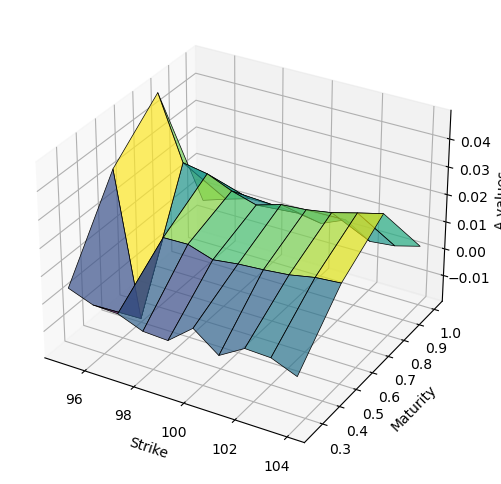

In [134]:
surface(strikes,maturities,a_values)

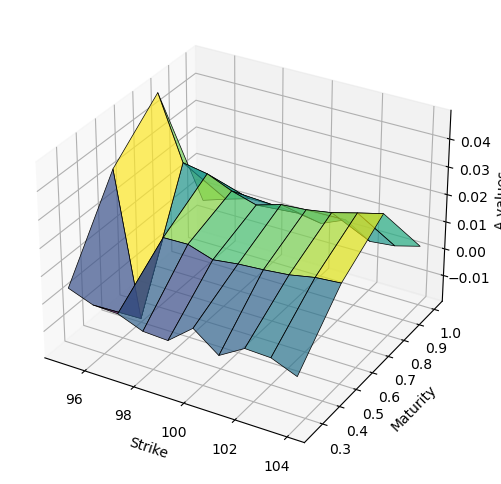

In [135]:
surface(strikes,maturities,result_reg_a)

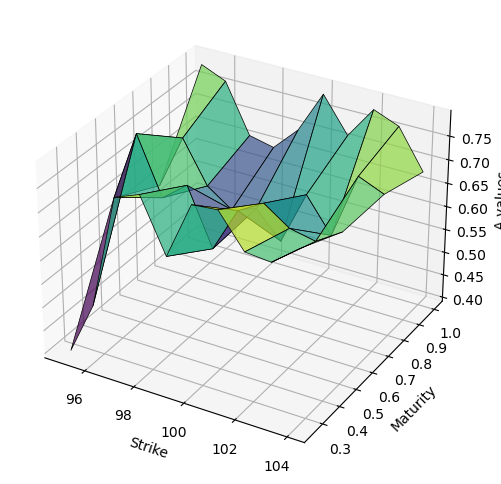

In [136]:
surface(strikes,maturities,b_values)

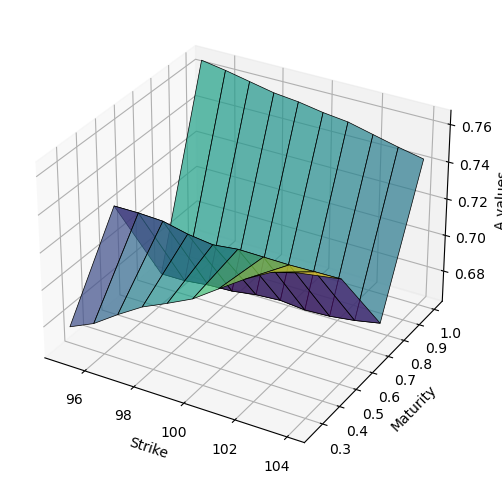

In [137]:
surface(strikes,maturities,result_reg_b)

5/ En utilisant les nappes obtenues pour le modèle SVI (à la dernière étape), proposer encore un prix, le plus juste possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue).

In [138]:
df_concatenated['a_values'] = a_values
df_concatenated['b_values'] = b_values

In [139]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values))
                                        ]                 
                               )
z2_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values))
                                        ]                 
                               )

In [140]:
forward_price = forward_price_calculation(S0, r, 1)
log_moneyness = log_moneyness_calculation(99, forward_price)
test_imp = svi_model(log_moneyness, calibrated_params_svi[0])
price = black_scholes_call_price(100,99,1,0,test_imp)
price

6.956420019657095

In [141]:
float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['prices'].values)

6.86

In [142]:
x_val = 99.5
y_val = 8/12
a_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 100)]['a_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 100)]['a_values'].values))
                                        ]                 
                               )
b_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 100)]['b_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 100)]['b_values'].values))
                                        ]                 
                               )

In [143]:
def linear_interpolation(x0, y0, x1, y1, x):
    slope = (y1 - y0) / (x1 - x0)
    y = y0 + slope * (x - x0)
    return y

In [144]:
rho_8m = linear_interpolation(6,calibrated_params_svi[2][2],9,calibrated_params_svi[1][2],8)
m_8m = linear_interpolation(6,calibrated_params_svi[2][3],9,calibrated_params_svi[1][3],8)
sigma_8m = linear_interpolation(6,calibrated_params_svi[2][4],9,calibrated_params_svi[1][4],8)

In [145]:
forward_price = forward_price_calculation(S0, r, 1)
log_moneyness = log_moneyness_calculation(99.5, forward_price)
imp_vol_svi_8 = svi_fixed([a_val,b_val],calibrated_params_svi[3],log_moneyness)
price_svi = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8)
print(f"Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : {price_svi:.4f}")

forward_price_int = forward_price_calculation(S0, r, 1)
log_moneyness_int = log_moneyness_calculation(99.5, forward_price_int)
imp_vol_svi_8_int = svi_fixed([a_val,b_val],[0,0,rho_8m,m_8m,sigma_8m],log_moneyness_int)
price_svi_inter = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8_int)
print(f"Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : {price_svi_inter:.4f}")

Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : 4.9968
Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : 4.7942


4.7066 vrai prix

6/ écrire l’algorithme de valorisation d’une option avec le modèle PDV, par Monte Carlo (les seuls rendements considérés seront ceux simulés entre la date courante et la maturité) 

In [147]:
def K1(t,param):
    return abs(param[3]) * np.exp(-param[3] * t)

def K2(t,param):
    return abs(param[3]) * np.exp(-param[4] * t)

def R(x):
    epsilon = 1e-7  # Une petite constante
    return (x[:,1] / (x[:,0] + epsilon)) - 1
def PDV_model(param,x,t):  
    rt = R(x)
    sigma  = param[0] + param[1]*(sum(([K1(T-i/t,param)*rt for i in range(t)]))) + param[2]*(np.sqrt(sum([K2(T-i/t,param)*(rt**2) for i in range(t)])))
    #print(sigma)
    return sigma

In [148]:
def valorisation_MC_PDV(S, param,r, nb_simulations, pas, strike, T):
    dt=T/pas

    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0:2] = S 
        
    for i in range(1,pas):
        vol = PDV_model(param,paths[0:, i-1:i+1],pas)  #A chaque pas on calcule notre volatilité avec le modèle PDV
        paths[0:, i + 1] = paths[0:, i] * np.exp((r-0.5 * vol **2) * dt + vol * np.sqrt(dt) * np.random.normal(0,1,size=nb_simulations))
    option_payoffs = np.maximum(paths[0:, -1] - strike, 0)
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  #payoff actualisé
    return option_value,paths

In [149]:
def cost_function_PDV(param,args):
    S0,r, nb_simulations, pas, strikes, maturity,market_prices = args
    dt=maturity/pas
    model_prices = []
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0:2] = S0 
    for strike in strikes:
        for i in range(1,pas):
            vol = PDV_model(param,paths[0:, i-1:i+1],pas)  #A chaque pas on calcule notre volatilité avec le modèle PDV
            paths[0:, i + 1] = paths[0:, i] * np.exp((r-0.5 * vol **2) * dt + vol * np.sqrt(dt) * np.random.normal(0,1,size=nb_simulations))
        option_payoffs = np.maximum(paths[0:, -1] - strike, 0)
        model_prices.append(np.exp(-r * maturity) * np.mean(option_payoffs))  #payoff actualisé
    
    print(param,np.sum((model_prices - market_prices)**2))

    return np.sum((model_prices - market_prices)**2)

On valorise nos options 1 an et les comparons à notre prix de marché

In [150]:
# Parameters for the PDV model
lambda_1 = 0.5 # Lambda 1 ne peut pas etre negatif
lambda_2 = 0.3
beta_0 = 0.1 
beta_1 = 0.2  
beta_2 = 0.3   

In [151]:
def check_result_PDV(param,data,maturity):
    nb_simulations = 1000
    maturity=1
    pas=100
    opt = []
    #paths_PDV = []
    total_error = 0
    for strike,price in zip(data["strikes"],data["prices"]):
        option_price,paths = valorisation_MC_PDV(S0, param,r, nb_simulations, pas, strike, maturity)
        #paths_PDV.append(paths)
        print(f"Prix par simulation de Monte Carlo pour K = {strike} : {option_price:.2f}")
        opt.append(option_price)
        print(f"Market Price = {price:.2f}, Difference = {abs(option_price-price):.2f}")
        total_error+=abs(option_price-price)
    print(f'total error :{total_error:.2f}')
    fig, ax = plt.subplots()

    rects1 = ax.plot(data["strikes"], data["prices"], '-o',label='Market Prices',color='red')
    rects2 = ax.plot(data["strikes"], opt, label='Option Prices MC (PDV)')

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Prices')
    ax.set_title('Market Prices vs Option Prices from Monte Carlo Simulations')
    ax.legend()
    plt.show()

Prix par simulation de Monte Carlo pour K = 95 : 7.06
Market Price = 10.93, Difference = 3.87
Prix par simulation de Monte Carlo pour K = 96 : 6.56
Market Price = 9.55, Difference = 2.99
Prix par simulation de Monte Carlo pour K = 97 : 5.84
Market Price = 8.28, Difference = 2.44
Prix par simulation de Monte Carlo pour K = 98 : 5.25
Market Price = 7.40, Difference = 2.15
Prix par simulation de Monte Carlo pour K = 99 : 4.54
Market Price = 6.86, Difference = 2.32
Prix par simulation de Monte Carlo pour K = 100 : 4.09
Market Price = 6.58, Difference = 2.49
Prix par simulation de Monte Carlo pour K = 101 : 3.56
Market Price = 6.52, Difference = 2.96
Prix par simulation de Monte Carlo pour K = 102 : 3.40
Market Price = 6.49, Difference = 3.09
Prix par simulation de Monte Carlo pour K = 103 : 2.78
Market Price = 6.47, Difference = 3.69
Prix par simulation de Monte Carlo pour K = 104 : 2.45
Market Price = 6.46, Difference = 4.01
total error :30.02


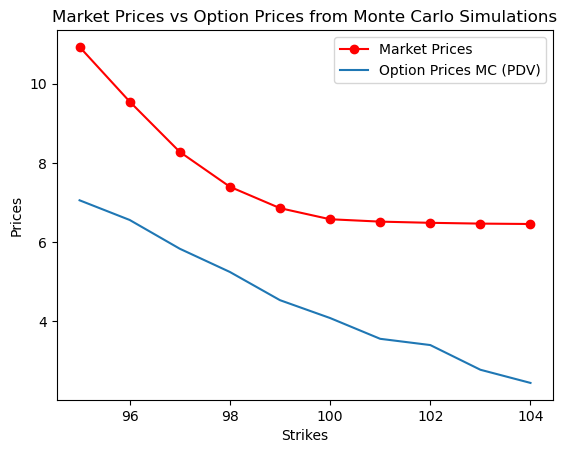

In [153]:
check_result_PDV([0.1]*5,df_12_months,1)

In [155]:
result_PDV_12 = [ 0.18646891,  0.28063193, -0.13846817,  0.05205   , -0.146798]

Prix par simulation de Monte Carlo pour K = 95 : 9.36
Market Price = 10.93, Difference = 1.57
Prix par simulation de Monte Carlo pour K = 96 : 9.29
Market Price = 9.55, Difference = 0.26
Prix par simulation de Monte Carlo pour K = 97 : 7.71
Market Price = 8.28, Difference = 0.57
Prix par simulation de Monte Carlo pour K = 98 : 8.31
Market Price = 7.40, Difference = 0.91
Prix par simulation de Monte Carlo pour K = 99 : 7.34
Market Price = 6.86, Difference = 0.48
Prix par simulation de Monte Carlo pour K = 100 : 7.47
Market Price = 6.58, Difference = 0.89
Prix par simulation de Monte Carlo pour K = 101 : 6.79
Market Price = 6.52, Difference = 0.27
Prix par simulation de Monte Carlo pour K = 102 : 6.68
Market Price = 6.49, Difference = 0.19
Prix par simulation de Monte Carlo pour K = 103 : 5.79
Market Price = 6.47, Difference = 0.68
Prix par simulation de Monte Carlo pour K = 104 : 5.33
Market Price = 6.46, Difference = 1.13
total error :6.95


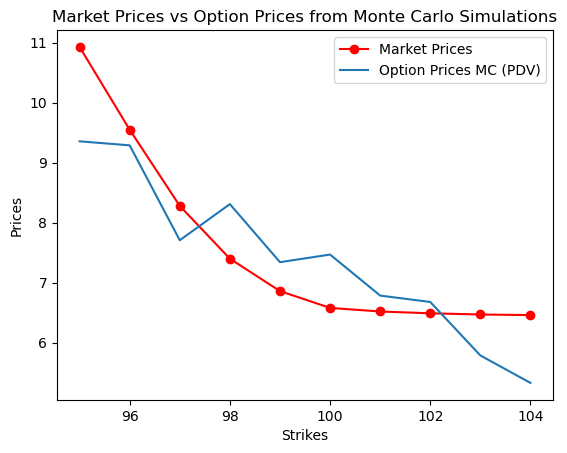

In [156]:
check_result_PDV(result_PDV_12,df_12_months,1)

In [ ]:
result_PDV_9 = nelder_mead_gpt(cost_function_PDV,np.array(initial_params),S0,r,2000, 100, df_9_months['strikes'], 0.75,df['prices'])

In [ ]:
result_PDV_6 = nelder_mead_gpt(cost_function_PDV,np.array(initial_params),S0,r, 1000, 100, df_6_months['strikes'],0.5,df['prices'])
result_PDV_3 = nelder_mead_gpt(cost_function_PDV,np.array(initial_params),S0,r, 1000, 100, df_3_months['strikes'],0.25,df['prices'])                                                                                                                         

Prix par simulation de Monte Carlo pour K = 95 : 9.33
Market Price = 11.79, Difference = 2.46
Prix par simulation de Monte Carlo pour K = 96 : 8.86
Market Price = 8.95, Difference = 0.09
Prix par simulation de Monte Carlo pour K = 97 : 7.81
Market Price = 8.07, Difference = 0.26
Prix par simulation de Monte Carlo pour K = 98 : 7.81
Market Price = 7.03, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 99 : 6.49
Market Price = 6.18, Difference = 0.31
Prix par simulation de Monte Carlo pour K = 100 : 6.82
Market Price = 6.04, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 101 : 6.18
Market Price = 5.76, Difference = 0.42
Prix par simulation de Monte Carlo pour K = 102 : 6.10
Market Price = 5.50, Difference = 0.60
Prix par simulation de Monte Carlo pour K = 103 : 5.49
Market Price = 5.50, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 104 : 4.52
Market Price = 5.39, Difference = 0.87
total error :6.60


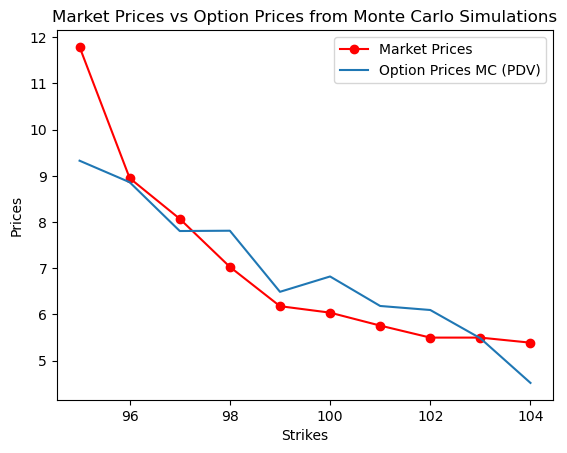

In [163]:
result_PDV_9 = [ 0.16203291  ,0.35743993  ,0.08174383 ,-0.03467    , 0.170222  ]
check_result_PDV(result_PDV_9,df_9_months,0.75)

Prix par simulation de Monte Carlo pour K = 95 : 7.67
Market Price = 10.71, Difference = 3.04
Prix par simulation de Monte Carlo pour K = 96 : 6.87
Market Price = 8.28, Difference = 1.41
Prix par simulation de Monte Carlo pour K = 97 : 6.71
Market Price = 6.91, Difference = 0.20
Prix par simulation de Monte Carlo pour K = 98 : 5.68
Market Price = 6.36, Difference = 0.68
Prix par simulation de Monte Carlo pour K = 99 : 5.59
Market Price = 5.29, Difference = 0.30
Prix par simulation de Monte Carlo pour K = 100 : 5.20
Market Price = 5.07, Difference = 0.13
Prix par simulation de Monte Carlo pour K = 101 : 4.58
Market Price = 4.76, Difference = 0.18
Prix par simulation de Monte Carlo pour K = 102 : 4.24
Market Price = 4.47, Difference = 0.23
Prix par simulation de Monte Carlo pour K = 103 : 3.70
Market Price = 4.35, Difference = 0.65
Prix par simulation de Monte Carlo pour K = 104 : 3.12
Market Price = 4.14, Difference = 1.02
total error :7.84


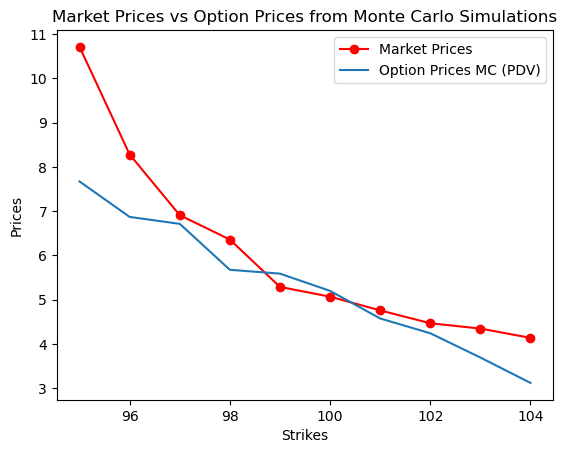

In [162]:
result_PDV_6 = [ 0.12203291  ,0.35743993  ,0.05174383 ,-0.03467    , 0.170222  ]
check_result_PDV(result_PDV_6,df_6_months,0.5)

In [174]:
result_PDV_3 = [ 0.08646891,  0.28063193, -0.13846817,  0.05205   , -0.146798  ]

Prix par simulation de Monte Carlo pour K = 95 : 6.25
Market Price = 8.67, Difference = 2.42
Prix par simulation de Monte Carlo pour K = 96 : 5.50
Market Price = 7.14, Difference = 1.64
Prix par simulation de Monte Carlo pour K = 97 : 4.95
Market Price = 5.98, Difference = 1.03
Prix par simulation de Monte Carlo pour K = 98 : 4.44
Market Price = 4.93, Difference = 0.49
Prix par simulation de Monte Carlo pour K = 99 : 3.75
Market Price = 4.09, Difference = 0.34
Prix par simulation de Monte Carlo pour K = 100 : 3.54
Market Price = 3.99, Difference = 0.45
Prix par simulation de Monte Carlo pour K = 101 : 3.13
Market Price = 3.43, Difference = 0.30
Prix par simulation de Monte Carlo pour K = 102 : 2.65
Market Price = 3.01, Difference = 0.36
Prix par simulation de Monte Carlo pour K = 103 : 2.29
Market Price = 2.72, Difference = 0.43
Prix par simulation de Monte Carlo pour K = 104 : 1.94
Market Price = 2.53, Difference = 0.59
total error :8.04


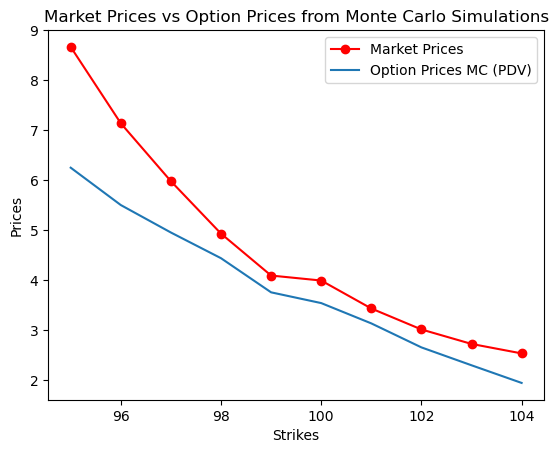

In [175]:
check_result_PDV(result_PDV_3,df_3_months,0.25)

Question 8

In [290]:
def recuit_simule(f, x0,*args, q=0.2, c0=1e-2, alpha=0.99, max_iter=2000):
    # q = variance de la gaussienne
    # c0 = critère d'arret
    # alpha = taux d'acceptation

    for _ in range(max_iter):
        x_new = np.random.normal(x0, q)  # Tirez un nouveau x à partir d'une distribution q(x|xk)

        delta_f = f(x_new,args) - f(x0,args)

        """
        La probabilité que xk +1 soit accepé est :
                    1 si f (xk +1 ) ≤f (xk ) ;
                    exp(−f (xk +1 )−f (xk ) / ck) sinon;
        """
        if delta_f <= 0 or np.random.rand() < np.exp(-delta_f / c0):
            x0 = x_new

        """
        Parametre de controle initialement grand 
        (grand taux d’acceptation) puis
        décroissance lente : 
        ck +1 = α * ck 
        avec α = 0.99
        """
        c0 *= alpha 

    result = {'x': x0, 'fun': f(x0,args)}
    return result

In [286]:
while result_svi_6m_recuit['fun'] > 1e-4:
    result_svi_6m_recuit = recuit_simule(cost_function_SVI,np.array(result_svi_6m_recuit['x']),df_6_months["strikes"],df_6_months["implied_vol"],0.5)
    print(result_svi_6m_recuit['fun'])                                                                                                          
                                                                                                                                                          
                                                                                                                             
                                                                                                                           

0.003123195917157312
0.002210248595335743
0.0023162116896975524
0.0


In [294]:
result_svi_12m_recuit = recuit_simule(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_12_months["strikes"],df_12_months["implied_vol"],1)

result_svi_6m_recuit = recuit_simule(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_6_months["strikes"],df_6_months["implied_vol"],0.5)
result_svi_3m_recuit = recuit_simule(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_3_months["strikes"],df_3_months["implied_vol"],0.25)

In [298]:
result_svi_9m_recuit = recuit_simule(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_9_months["strikes"],df_9_months["implied_vol"],0.75)

In [308]:
result_concat_recuit= [result_svi_12m_recuit['x'] , result_svi_9m_recuit['x'] , result_svi_6m_recuit['x'] , result_svi_3m_recuit['x'] ]

res_recuit=pd.DataFrame(result_concat_recuit,index=["12 months","9 months","6 months","3 months"],columns=["a","b","rho","m","sigma"])
res_recuit

a         b       rho         m     sigma
12 months -0.028702  0.018917 -0.089245  0.199862  0.147001
9 months   0.025484  0.004331  0.242940 -0.518859 -0.182850
6 months   0.006497  0.134634  0.357474  0.168268  0.027189
3 months  -0.002747 -0.028190 -0.185034  0.229299 -0.034238

In [299]:
print(result_svi_12m_recuit)
print(result_svi_9m_recuit)
print(result_svi_6m_recuit)
print(result_svi_3m_recuit)

{'x': array([-0.02870154,  0.01891727, -0.08924501,  0.19986243,  0.14700117]), 'fun': 0.0030799196217569658}
{'x': array([ 0.02548357,  0.00433063,  0.24293963, -0.51885922, -0.18285041]), 'fun': 0.005931315040163971}
{'x': array([0.00649705, 0.13463386, 0.35747439, 0.16826822, 0.02718855]), 'fun': 0.004243089226153508}
{'x': array([-0.0027466 , -0.02818976, -0.18503445,  0.2292985 , -0.03423814]), 'fun': 0.002205559858733327}


Prix par simulation de Monte Carlo pour K = 95: 10.05
Market Price = 10.93, Difference = 0.88
Prix par simulation de Monte Carlo pour K = 96: 9.46
Market Price = 9.55, Difference = 0.09
Prix par simulation de Monte Carlo pour K = 97: 8.72
Market Price = 8.28, Difference = 0.44
Prix par simulation de Monte Carlo pour K = 98: 8.63
Market Price = 7.40, Difference = 1.23
Prix par simulation de Monte Carlo pour K = 99: 7.69
Market Price = 6.86, Difference = 0.83
Prix par simulation de Monte Carlo pour K = 100: 7.53
Market Price = 6.58, Difference = 0.95
Prix par simulation de Monte Carlo pour K = 101: 6.99
Market Price = 6.52, Difference = 0.47
Prix par simulation de Monte Carlo pour K = 102: 6.38
Market Price = 6.49, Difference = 0.11
Prix par simulation de Monte Carlo pour K = 103: 6.12
Market Price = 6.47, Difference = 0.35
Prix par simulation de Monte Carlo pour K = 104: 5.37
Market Price = 6.46, Difference = 1.09
6.440109813366777


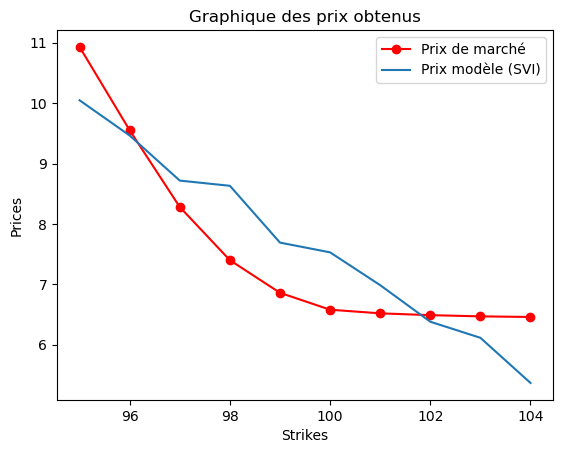

In [406]:
check_results_svi(result_svi_12m_recuit['x'],df_12_months)

Prix par simulation de Monte Carlo pour K = 95: 8.41
Market Price = 11.79, Difference = 3.38
Prix par simulation de Monte Carlo pour K = 96: 7.97
Market Price = 8.95, Difference = 0.98
Prix par simulation de Monte Carlo pour K = 97: 7.51
Market Price = 8.07, Difference = 0.56
Prix par simulation de Monte Carlo pour K = 98: 6.89
Market Price = 7.03, Difference = 0.14
Prix par simulation de Monte Carlo pour K = 99: 6.41
Market Price = 6.18, Difference = 0.23
Prix par simulation de Monte Carlo pour K = 100: 5.90
Market Price = 6.04, Difference = 0.14
Prix par simulation de Monte Carlo pour K = 101: 5.53
Market Price = 5.76, Difference = 0.23
Prix par simulation de Monte Carlo pour K = 102: 5.07
Market Price = 5.50, Difference = 0.43
Prix par simulation de Monte Carlo pour K = 103: 4.54
Market Price = 5.50, Difference = 0.96
Prix par simulation de Monte Carlo pour K = 104: 4.14
Market Price = 5.39, Difference = 1.25
8.306001098769688


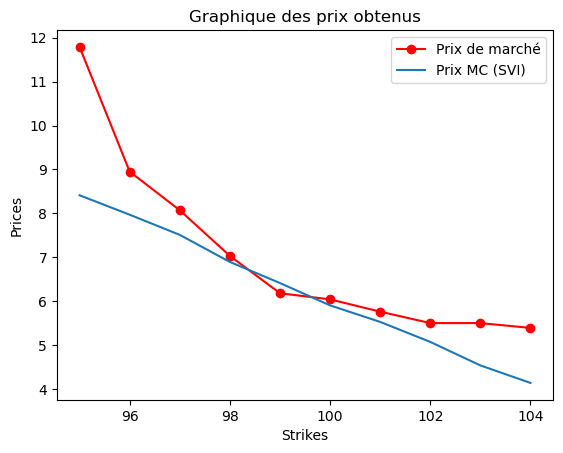

In [300]:
check_results_svi(result_svi_9m_recuit['x'],df_9_months)

Prix par simulation de Monte Carlo pour K = 95: 7.60
Market Price = 10.71, Difference = 3.11
Prix par simulation de Monte Carlo pour K = 96: 6.47
Market Price = 8.28, Difference = 1.81
Prix par simulation de Monte Carlo pour K = 97: 5.98
Market Price = 6.91, Difference = 0.93
Prix par simulation de Monte Carlo pour K = 98: 5.13
Market Price = 6.36, Difference = 1.23
Prix par simulation de Monte Carlo pour K = 99: 4.76
Market Price = 5.29, Difference = 0.53
Prix par simulation de Monte Carlo pour K = 100: 4.21
Market Price = 5.07, Difference = 0.86
Prix par simulation de Monte Carlo pour K = 101: 3.51
Market Price = 4.76, Difference = 1.25
Prix par simulation de Monte Carlo pour K = 102: 3.00
Market Price = 4.47, Difference = 1.47
Prix par simulation de Monte Carlo pour K = 103: 2.66
Market Price = 4.35, Difference = 1.69
Prix par simulation de Monte Carlo pour K = 104: 2.19
Market Price = 4.14, Difference = 1.95
14.828754703717543


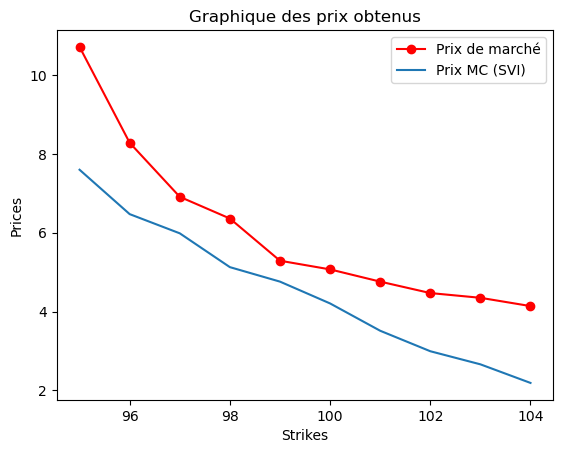

In [301]:
check_results_svi(result_svi_6m_recuit['x'],df_6_months)

Prix par simulation de Monte Carlo pour K = 95: 5.47
Market Price = 8.67, Difference = 3.20
Prix par simulation de Monte Carlo pour K = 96: 4.79
Market Price = 7.14, Difference = 2.35
Prix par simulation de Monte Carlo pour K = 97: 3.86
Market Price = 5.98, Difference = 2.12
Prix par simulation de Monte Carlo pour K = 98: 3.23
Market Price = 4.93, Difference = 1.70
Prix par simulation de Monte Carlo pour K = 99: 2.55
Market Price = 4.09, Difference = 1.54
Prix par simulation de Monte Carlo pour K = 100: 2.02
Market Price = 3.99, Difference = 1.97
Prix par simulation de Monte Carlo pour K = 101: 1.60
Market Price = 3.43, Difference = 1.83
Prix par simulation de Monte Carlo pour K = 102: 1.12
Market Price = 3.01, Difference = 1.89
Prix par simulation de Monte Carlo pour K = 103: 0.88
Market Price = 2.72, Difference = 1.84
Prix par simulation de Monte Carlo pour K = 104: 0.59
Market Price = 2.53, Difference = 1.94
20.381165271319382


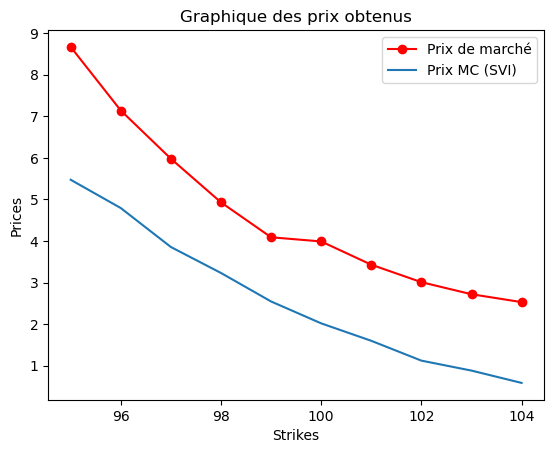

In [302]:
check_results_svi(result_svi_3m_recuit['x'],df_3_months)

In [ ]:
result_svi_6m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_6_months["strikes"],df_6_months["implied_vol"],0.5)['x']
result_svi_3m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_3_months["strikes"],df_3_months["implied_vol"],0.25)['x']






In [187]:
def example_function(x,args):
    return x[0]**2+x[1]**2

In [188]:
x_optimal = recuit_simulé(example_function, x0=[10,10])

print(f'x : {x_optimal["x"]}')
print(f'fun : {x_optimal["fun"]}')

x : [-0.00688345  0.00891247]
fun : 0.0001268140178411552


In [354]:
import numpy as np
 
class Particle:
    def __init__(self, dim, min_bound, max_bound):
        self.position = np.random.uniform(min_bound, max_bound, dim)
        self.velocity = np.random.uniform(-1, 1, dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')
 
def particle_swarm_optimization(f, dim, min_bound, max_bound, swarm_size, max_iter, w, c1, c2, *args):
    swarm = [Particle(dim, min_bound, max_bound) for _ in range(swarm_size)]
    global_best_position = None
    global_best_score = float('inf')
 
    for _ in range(max_iter):
        for particle in swarm:
            score = f(particle.position, *args)  # Pass the parameters *args
 
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)
 
            if score < global_best_score:
                global_best_score = score
                global_best_position = np.copy(particle.position)
 
        for particle in swarm:
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            inertia = w * particle.velocity
            cognitive = c1 * r1 * (particle.best_position - particle.position)
            social = c2 * r2 * (global_best_position - particle.position)
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity
 
            # Ensure particles stay within the defined bounds
            particle.position = np.clip(particle.position, min_bound, max_bound)
 
    return global_best_position

In [328]:
result_svi_9m_recuit = recuit_simule(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_9_months["strikes"],df_9_months["implied_vol"],0.75)

In [384]:

# Define the Particle class
class Particle:
    def __init__(self, bounds):
        self.position = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=bounds.shape[0])
        self.velocity = np.random.uniform(low=-1, high=1, size=bounds.shape[0])
        self.best_position = np.copy(self.position)
        self.best_value = float('inf')
        self.bounds = bounds

    def update_velocity(self, global_best_position, w, phi_p, phi_g):
        r_p = np.random.uniform(0, phi_p, size=self.velocity.shape)
        r_g = np.random.uniform(0, phi_g, size=self.velocity.shape)
        cognitive_component = r_p * (self.best_position - self.position)
        social_component = r_g * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive_component + social_component

    def update_position(self):
        self.position += self.velocity
        self.position = np.clip(self.position, self.bounds[:, 0], self.bounds[:, 1])

# Define the PSO algorithm
class PSO:
    def __init__(self, objective_function, bounds, num_particles, w, phi_p, phi_g, max_iter,*args):
        self.objective_function = objective_function
        self.args =  args
        self.bounds = np.array(bounds)
        self.num_particles = num_particles
        self.w = w
        self.phi_p = phi_p
        self.phi_g = phi_g
        self.max_iter = max_iter
        self.global_best_position = None
        self.global_best_value = float('inf')
        self.swarm = [Particle(bounds) for _ in range(num_particles)]

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.swarm:
                value = self.objective_function(particle.position,*self.args)
                if value < particle.best_value:
                    particle.best_value = value
                    particle.best_position = np.copy(particle.position)
                if value < self.global_best_value:
                    self.global_best_value = value
                    self.global_best_position = np.copy(particle.position)

            for particle in self.swarm:
                particle.update_velocity(self.global_best_position, self.w, self.phi_p, self.phi_g)
                particle.update_position()


        return self.global_best_position, self.global_best_value


In [389]:

# Define the bounds for the problem, for example: [[-10, 10], [-10, 10]] for a 2-dimensional problem
problem_bounds = np.array([[-1, 1], [-1, 1],[-1, 1], [-1, 1],[-1, 1]])

num_particles=30
w=0.7
phi_p=2.05
phi_g=2.05
max_iter=1000

# Initialize PSO with the objective function and bounds
pso = PSO(cost_function_SVI, problem_bounds,num_particles, w, phi_p, phi_g, max_iter,(df_9_months["strikes"],
    df_9_months["implied_vol"],
    0.75))

# Run optimization
best_position, best_value = pso.optimize()

# Display the results
best_position, best_value

Iteration 1/1000, best value: 0.3074677502219904
Iteration 2/1000, best value: 0.10675459787537635
Iteration 3/1000, best value: 0.009707633062645726
Iteration 4/1000, best value: 0.009707633062645726
Iteration 5/1000, best value: 0.009707633062645726
Iteration 6/1000, best value: 0.009707633062645726
Iteration 7/1000, best value: 0.009707633062645726
Iteration 8/1000, best value: 0.006442987286847617
Iteration 9/1000, best value: 0.006442987286847617
Iteration 10/1000, best value: 0.006442987286847617
Iteration 11/1000, best value: 0.006442987286847617
Iteration 12/1000, best value: 0.006442987286847617
Iteration 13/1000, best value: 0.006027979635047601
Iteration 14/1000, best value: 0.006027979635047601
Iteration 15/1000, best value: 0.006027979635047601
Iteration 16/1000, best value: 0.006027979635047601
Iteration 17/1000, best value: 0.006027979635047601
Iteration 18/1000, best value: 0.006027979635047601
Iteration 19/1000, best value: 0.006027979635047601
Iteration 20/1000, best 

Iteration 160/1000, best value: 0.005443433589122914
Iteration 161/1000, best value: 0.005443433589122914
Iteration 162/1000, best value: 0.005443433589122914
Iteration 163/1000, best value: 0.005443433589122914
Iteration 164/1000, best value: 0.005443433589122914
Iteration 165/1000, best value: 0.005443433589122914
Iteration 166/1000, best value: 0.005443433589122914
Iteration 167/1000, best value: 0.005443433589122914
Iteration 168/1000, best value: 0.005443433589122914
Iteration 169/1000, best value: 0.005443433589122914
Iteration 170/1000, best value: 0.005443433589122914
Iteration 171/1000, best value: 0.005443433589122914
Iteration 172/1000, best value: 0.0054418675448222
Iteration 173/1000, best value: 0.005439772036766274
Iteration 174/1000, best value: 0.005436510140453059
Iteration 175/1000, best value: 0.005433251199839274
Iteration 176/1000, best value: 0.005433042519864576
Iteration 177/1000, best value: 0.005433042519864576
Iteration 178/1000, best value: 0.00543041986605

Iteration 320/1000, best value: 0.00462285763841692
Iteration 321/1000, best value: 0.00462285763841692
Iteration 322/1000, best value: 0.00462285763841692
Iteration 323/1000, best value: 0.00462285763841692
Iteration 324/1000, best value: 0.00462285763841692
Iteration 325/1000, best value: 0.00462285763841692
Iteration 326/1000, best value: 0.00462285763841692
Iteration 327/1000, best value: 0.00462285763841692
Iteration 328/1000, best value: 0.00462285763841692
Iteration 329/1000, best value: 0.004617209027211697
Iteration 330/1000, best value: 0.004617209027211697
Iteration 331/1000, best value: 0.004617209027211697
Iteration 332/1000, best value: 0.004617209027211697
Iteration 333/1000, best value: 0.004617209027211697
Iteration 334/1000, best value: 0.004617209027211697
Iteration 335/1000, best value: 0.004617209027211697
Iteration 336/1000, best value: 0.004617209027211697
Iteration 337/1000, best value: 0.004617209027211697
Iteration 338/1000, best value: 0.004617209027211697
It

Iteration 480/1000, best value: 0.0012851938616421752
Iteration 481/1000, best value: 0.0012851938616421752
Iteration 482/1000, best value: 0.0012851938616421752
Iteration 483/1000, best value: 0.0012851938616421752
Iteration 484/1000, best value: 0.0012851938616421752
Iteration 485/1000, best value: 0.0012851938616421752
Iteration 486/1000, best value: 0.0012851938616421752
Iteration 487/1000, best value: 0.0012851938616421752
Iteration 488/1000, best value: 0.0012851938616421752
Iteration 489/1000, best value: 0.0012851938616421752
Iteration 490/1000, best value: 0.0011406082203386418
Iteration 491/1000, best value: 0.0011406082203386418
Iteration 492/1000, best value: 0.0011406082203386418
Iteration 493/1000, best value: 0.0011406082203386418
Iteration 494/1000, best value: 0.0011406082203386418
Iteration 495/1000, best value: 0.0011406082203386418
Iteration 496/1000, best value: 0.0011406082203386418
Iteration 497/1000, best value: 0.0011406082203386418
Iteration 498/1000, best val

Iteration 635/1000, best value: 0.0009320592728939701
Iteration 636/1000, best value: 0.0009320592728939701
Iteration 637/1000, best value: 0.0009320592728939701
Iteration 638/1000, best value: 0.0009320592728939701
Iteration 639/1000, best value: 0.0009320592728939701
Iteration 640/1000, best value: 0.0009320592728939701
Iteration 641/1000, best value: 0.0009320592728939701
Iteration 642/1000, best value: 0.0009320592728939701
Iteration 643/1000, best value: 0.0009320592728939701
Iteration 644/1000, best value: 0.0009320592728939701
Iteration 645/1000, best value: 0.0009320592728939701
Iteration 646/1000, best value: 0.0009320592728939701
Iteration 647/1000, best value: 0.000931727615523005
Iteration 648/1000, best value: 0.000931727615523005
Iteration 649/1000, best value: 0.000931727615523005
Iteration 650/1000, best value: 0.000931727615523005
Iteration 651/1000, best value: 0.000931727615523005
Iteration 652/1000, best value: 0.000931727615523005
Iteration 653/1000, best value: 0.

Iteration 796/1000, best value: 0.0009314293604355696
Iteration 797/1000, best value: 0.0009314293604355696
Iteration 798/1000, best value: 0.0009314293604355696
Iteration 799/1000, best value: 0.0009314293604355696
Iteration 800/1000, best value: 0.0009314293604355696
Iteration 801/1000, best value: 0.00093142936043204
Iteration 802/1000, best value: 0.00093142936043204
Iteration 803/1000, best value: 0.00093142936043204
Iteration 804/1000, best value: 0.00093142936043204
Iteration 805/1000, best value: 0.0009314293604183823
Iteration 806/1000, best value: 0.0009314293604183823
Iteration 807/1000, best value: 0.0009314293604183823
Iteration 808/1000, best value: 0.0009314293604183823
Iteration 809/1000, best value: 0.0009314293604183823
Iteration 810/1000, best value: 0.0009314293604162408
Iteration 811/1000, best value: 0.0009314293604162408
Iteration 812/1000, best value: 0.0009314293604162408
Iteration 813/1000, best value: 0.0009314293604004763
Iteration 814/1000, best value: 0.00

Iteration 950/1000, best value: 0.0009314293603822068
Iteration 951/1000, best value: 0.0009314293603822068
Iteration 952/1000, best value: 0.0009314293603822068
Iteration 953/1000, best value: 0.0009314293603822065
Iteration 954/1000, best value: 0.0009314293603822065
Iteration 955/1000, best value: 0.0009314293603822063
Iteration 956/1000, best value: 0.0009314293603822063
Iteration 957/1000, best value: 0.0009314293603822063
Iteration 958/1000, best value: 0.0009314293603822063
Iteration 959/1000, best value: 0.0009314293603822063
Iteration 960/1000, best value: 0.0009314293603822063
Iteration 961/1000, best value: 0.0009314293603822063
Iteration 962/1000, best value: 0.0009314293603822063
Iteration 963/1000, best value: 0.0009314293603822063
Iteration 964/1000, best value: 0.0009314293603822063
Iteration 965/1000, best value: 0.0009314293603822063
Iteration 966/1000, best value: 0.0009314293603822063
Iteration 967/1000, best value: 0.0009314293603822063
Iteration 968/1000, best val

(array([-2.53918772e-02, -1.00000000e+00, -1.00000000e+00, -3.78291277e-02,
         5.92205444e-11]),
 0.0009314293603822062)

In [390]:
best_position

array([-2.53918772e-02, -1.00000000e+00, -1.00000000e+00, -3.78291277e-02,
        5.92205444e-11])

Prix par simulation de Monte Carlo pour K = 95: 10.43
Market Price = 11.79, Difference = 1.36
Prix par simulation de Monte Carlo pour K = 96: 8.14
Market Price = 8.95, Difference = 0.81
Prix par simulation de Monte Carlo pour K = 97: 7.06
Market Price = 8.07, Difference = 1.01
Prix par simulation de Monte Carlo pour K = 98: 6.25
Market Price = 7.03, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 99: 5.99
Market Price = 6.18, Difference = 0.19
Prix par simulation de Monte Carlo pour K = 100: 5.66
Market Price = 6.04, Difference = 0.38
Prix par simulation de Monte Carlo pour K = 101: 4.93
Market Price = 5.76, Difference = 0.83
Prix par simulation de Monte Carlo pour K = 102: 4.51
Market Price = 5.50, Difference = 0.99
Prix par simulation de Monte Carlo pour K = 103: 4.15
Market Price = 5.50, Difference = 1.35
Prix par simulation de Monte Carlo pour K = 104: 3.95
Market Price = 5.39, Difference = 1.44
9.140518939058925


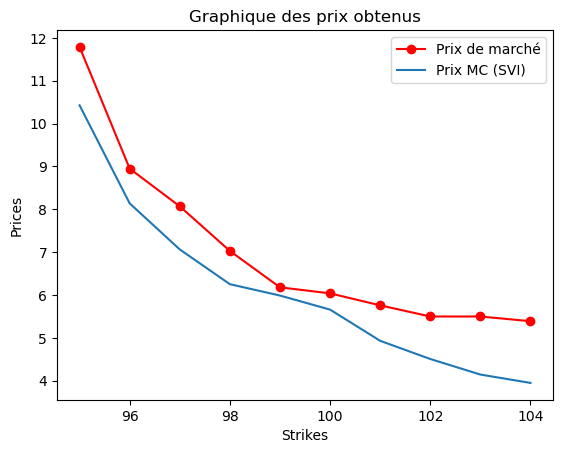

In [391]:
check_results_svi(best_position,df_9_months)

In [394]:
def PSO_SVI(cost_function_SVI, problem_bounds,num_particles, w, phi_p, phi_g, max_iter,*args):
    bounds = np.array(problem_bounds)
    global_best_position = None
    global_best_value = float('inf')
    
    swarm = []
    for i in range(num_particles):
        position = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=bounds.shape[0])
        velocity = np.random.uniform(low=-1, high=1, size=bounds.shape[0])
        best_position = np.copy(position)
        best_value = float('inf')
        swarm.append([position,velocity,best_position,best_value])
        
    for iteration in range(max_iter):
        for particle in swarm:
            value = cost_function_SVI(particle[0],args)
            if value < particle[3]:
                particle[3] = value
                particle[2] = np.copy(particle[0])
            if value < global_best_value:
                global_best_value = value
                global_best_position = np.copy(particle[0])

        for particle in swarm:
            r_p = np.random.uniform(0, phi_p, size=particle[1].shape)
            r_g = np.random.uniform(0, phi_g, size=particle[1].shape)
            cognitive_component = r_p * (particle[2] - particle[0])
            social_component = r_g * (global_best_position - particle[0])
            particle[1] = w * particle[1] + cognitive_component + social_component
            
            particle[0] += particle[1]
            particle[0] = np.clip(particle[0],bounds[:,0],bounds[:,1])
            
    result = {'x': global_best_position, 'fun': global_best_value}
    return result



In [397]:

# Define the bounds for the problem, for example: [[-10, 10], [-10, 10]] for a 2-dimensional problem
problem_bounds = np.array([[-1, 1], [-1, 1],[-1, 1], [-1, 1],[-1, 1]])

num_particles=30
w=0.7
phi_p=2.05
phi_g=2.05
max_iter=1000

# Initialize PSO with the objective function and bounds
result_12m = PSO_SVI(cost_function_SVI, problem_bounds,num_particles, w, phi_p, phi_g, max_iter,df_12_months["strikes"],df_12_months["implied_vol"],1)
result_9m = PSO_SVI(cost_function_SVI, problem_bounds,num_particles, w, phi_p, phi_g, max_iter,df_9_months["strikes"],df_9_months["implied_vol"],0.75)
result_6m = PSO_SVI(cost_function_SVI, problem_bounds,num_particles, w, phi_p, phi_g, max_iter,df_6_months["strikes"],df_6_months["implied_vol"],0.5)
result_3m = PSO_SVI(cost_function_SVI, problem_bounds,num_particles, w, phi_p, phi_g, max_iter,df_3_months["strikes"],df_3_months["implied_vol"],0.25)






print(result_12m)
print(result_9m)
print(result_6m)
print(result_3m)







{'x': array([-0.01485796, -0.64274462, -0.33572636, -0.02071   ,  0.01694396]), 'fun': 8.394203457590783e-06}
{'x': array([ 2.82846087e-02, -1.84768459e-16,  1.00000000e+00,  9.99878018e-01,
       -1.00000000e+00]), 'fun': 0.005846145635096485}
{'x': array([-9.72697770e-17,  1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        2.02744769e-01]), 'fun': 0.004724105449812294}
{'x': array([-1.85429746e-05, -9.23026102e-01, -1.00000000e+00, -1.00000000e+00,
        1.58199014e-01]), 'fun': 0.002527609477505412}


In [398]:
param_PSO_concat = [result_12m['x'] , result_9m['x'] , result_6m['x'] , result_3m['x'] ]

PSO=pd.DataFrame(param_PSO_concat,index=["12 months","9 months","6 months","3 months"],columns=["a","b","rho","m","sigma"])
PSO

a             b       rho         m     sigma
12 months -1.485796e-02 -6.427446e-01 -0.335726 -0.020710  0.016944
9 months   2.828461e-02 -1.847685e-16  1.000000  0.999878 -1.000000
6 months  -9.726978e-17  1.000000e+00 -1.000000 -1.000000  0.202745
3 months  -1.854297e-05 -9.230261e-01 -1.000000 -1.000000  0.158199

Prix par simulation de Monte Carlo pour K = 95: 10.00
Market Price = 11.79, Difference = 1.79
Prix par simulation de Monte Carlo pour K = 96: 8.38
Market Price = 8.95, Difference = 0.57
Prix par simulation de Monte Carlo pour K = 97: 7.11
Market Price = 8.07, Difference = 0.96
Prix par simulation de Monte Carlo pour K = 98: 6.15
Market Price = 7.03, Difference = 0.88
Prix par simulation de Monte Carlo pour K = 99: 5.82
Market Price = 6.18, Difference = 0.36
Prix par simulation de Monte Carlo pour K = 100: 5.14
Market Price = 6.04, Difference = 0.90
Prix par simulation de Monte Carlo pour K = 101: 4.92
Market Price = 5.76, Difference = 0.84
Prix par simulation de Monte Carlo pour K = 102: 4.72
Market Price = 5.50, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 103: 4.48
Market Price = 5.50, Difference = 1.02
Prix par simulation de Monte Carlo pour K = 104: 4.41
Market Price = 5.39, Difference = 0.98
9.08642927054929


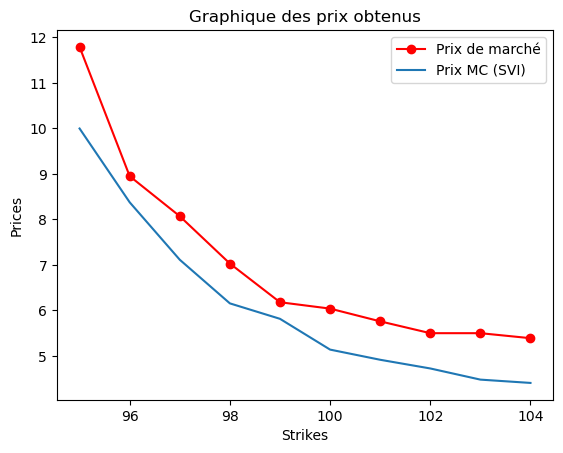

In [396]:
check_results_svi(result['x'],df_9_months)

Prix par simulation de Monte Carlo pour K = 95: 10.71
Market Price = 10.93, Difference = 0.22
Prix par simulation de Monte Carlo pour K = 96: 9.34
Market Price = 9.55, Difference = 0.21
Prix par simulation de Monte Carlo pour K = 97: 8.33
Market Price = 8.28, Difference = 0.05
Prix par simulation de Monte Carlo pour K = 98: 7.42
Market Price = 7.40, Difference = 0.02
Prix par simulation de Monte Carlo pour K = 99: 6.55
Market Price = 6.86, Difference = 0.31
Prix par simulation de Monte Carlo pour K = 100: 6.61
Market Price = 6.58, Difference = 0.03
Prix par simulation de Monte Carlo pour K = 101: 6.75
Market Price = 6.52, Difference = 0.23
Prix par simulation de Monte Carlo pour K = 102: 6.62
Market Price = 6.49, Difference = 0.13
Prix par simulation de Monte Carlo pour K = 103: 6.25
Market Price = 6.47, Difference = 0.22
Prix par simulation de Monte Carlo pour K = 104: 6.59
Market Price = 6.46, Difference = 0.13
1.5382801161332722


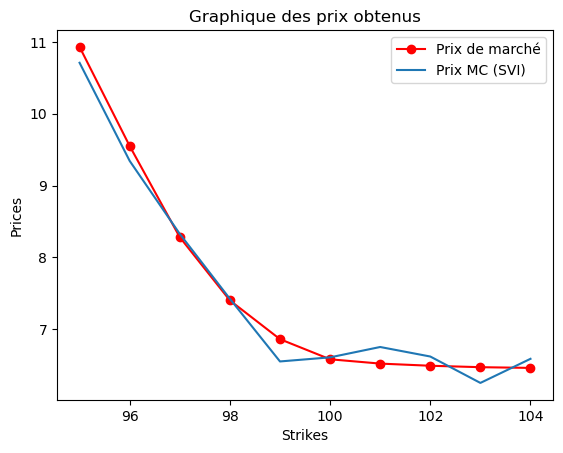

In [399]:
check_results_svi(result_12m['x'],df_12_months)

Prix par simulation de Monte Carlo pour K = 95: 6.98
Market Price = 10.71, Difference = 3.73
Prix par simulation de Monte Carlo pour K = 96: 6.57
Market Price = 8.28, Difference = 1.71
Prix par simulation de Monte Carlo pour K = 97: 5.49
Market Price = 6.91, Difference = 1.42
Prix par simulation de Monte Carlo pour K = 98: 5.04
Market Price = 6.36, Difference = 1.32
Prix par simulation de Monte Carlo pour K = 99: 4.62
Market Price = 5.29, Difference = 0.67
Prix par simulation de Monte Carlo pour K = 100: 3.99
Market Price = 5.07, Difference = 1.08
Prix par simulation de Monte Carlo pour K = 101: 3.64
Market Price = 4.76, Difference = 1.12
Prix par simulation de Monte Carlo pour K = 102: 3.16
Market Price = 4.47, Difference = 1.31
Prix par simulation de Monte Carlo pour K = 103: 2.63
Market Price = 4.35, Difference = 1.72
Prix par simulation de Monte Carlo pour K = 104: 2.38
Market Price = 4.14, Difference = 1.76
15.833473479198926


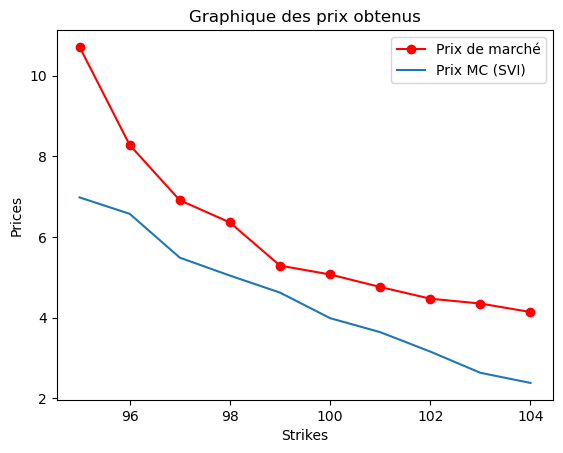

In [400]:
check_results_svi(result_6m['x'],df_6_months)

Prix par simulation de Monte Carlo pour K = 95: 5.59
Market Price = 8.67, Difference = 3.08
Prix par simulation de Monte Carlo pour K = 96: 4.71
Market Price = 7.14, Difference = 2.43
Prix par simulation de Monte Carlo pour K = 97: 3.96
Market Price = 5.98, Difference = 2.02
Prix par simulation de Monte Carlo pour K = 98: 3.28
Market Price = 4.93, Difference = 1.65
Prix par simulation de Monte Carlo pour K = 99: 2.59
Market Price = 4.09, Difference = 1.50
Prix par simulation de Monte Carlo pour K = 100: 2.20
Market Price = 3.99, Difference = 1.79
Prix par simulation de Monte Carlo pour K = 101: 1.66
Market Price = 3.43, Difference = 1.77
Prix par simulation de Monte Carlo pour K = 102: 1.26
Market Price = 3.01, Difference = 1.75
Prix par simulation de Monte Carlo pour K = 103: 0.98
Market Price = 2.72, Difference = 1.74
Prix par simulation de Monte Carlo pour K = 104: 0.75
Market Price = 2.53, Difference = 1.78
19.50562661196585


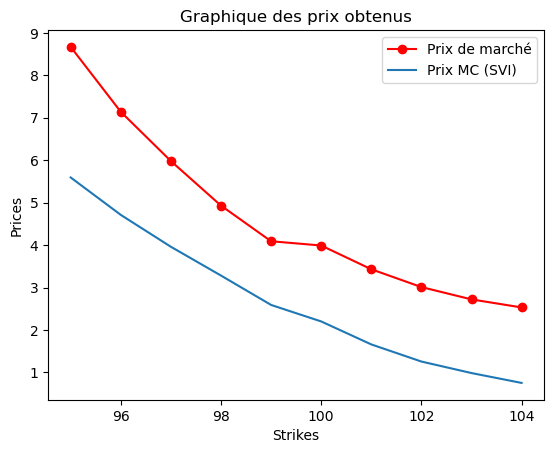

In [401]:
check_results_svi(result_3m['x'],df_3_months)